In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'accelerometer-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1830214%2F2986369%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T201356Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db9a4b03d376e7902391e0d3fe4e92d6716311d3e9adc3ab2e495bf20a8a8cb144b887ca81e521d2c54add4caf77b76086d44cf7e60ccc718d3943159fcba14670c3d9087773150f729fbd84e0171bd5c63e5b08279e68553c983d104cc42cdcabe21ec46b596da0d6c033d0ad90a2e49cc19a59e525223d89d6a5d00f3a461577abf437c5da4e597fabcd2220a5da0cffe1eece7fb21a139ff5ac54d8ce3ec125ded1217498f68e934b72db5692e8a2a59ea569302af519326267b90fbac2a1f36e729814001c9447d3c57cfa90199e223ff16b9217fef7bdca2879822ed9660dc9a538ea78b2df2e4d707f35aa925415551ecdc0d30c32a4206cca57d048033'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 859481 bytes downloaded
Downloaded and uncompressed: accelerometer-data-set
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


In [ ]:
pd.set_option("display.precision", 2)

In [ ]:
df = pd.read_csv("/kaggle/input/accelerometer-data-set/accelerometer.csv")
df.head()

wconfid  pctid     x     y     z
0        1     20  1.00  0.09 -0.12
1        1     20  1.00 -0.04 -0.12
2        1     20  0.97  0.09 -0.12
3        1     20  0.97 -0.01 -0.14
4        1     20  1.00 -0.02 -0.12

In [ ]:
print(df.shape)

(153000, 5)


In [ ]:
print(df.columns)


Index(['wconfid', 'pctid', 'x', 'y', 'z'], dtype='object')


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   wconfid  153000 non-null  int64  
 1   pctid    153000 non-null  int64  
 2   x        153000 non-null  float64
 3   y        153000 non-null  float64
 4   z        153000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 5.8 MB
None


In [ ]:
df.describe()

wconfid      pctid          x         y          z
count  153000.00  153000.00  153000.00  1.53e+05  153000.00
mean        2.00      60.00       1.00  5.35e-03      -0.12
std         0.82      24.49       0.77  7.43e-01       0.52
min         1.00      20.00      -8.00 -8.00e+00      -5.87
25%         1.00      40.00       0.94 -7.80e-02      -0.17
50%         2.00      60.00       0.99  8.00e-03      -0.12
75%         3.00      80.00       1.04  1.05e-01      -0.07
max         3.00     100.00       8.00  8.00e+00       6.09

<Axes: >

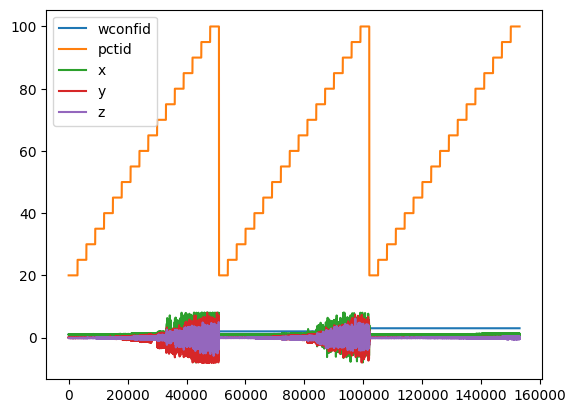

In [ ]:
df.plot()

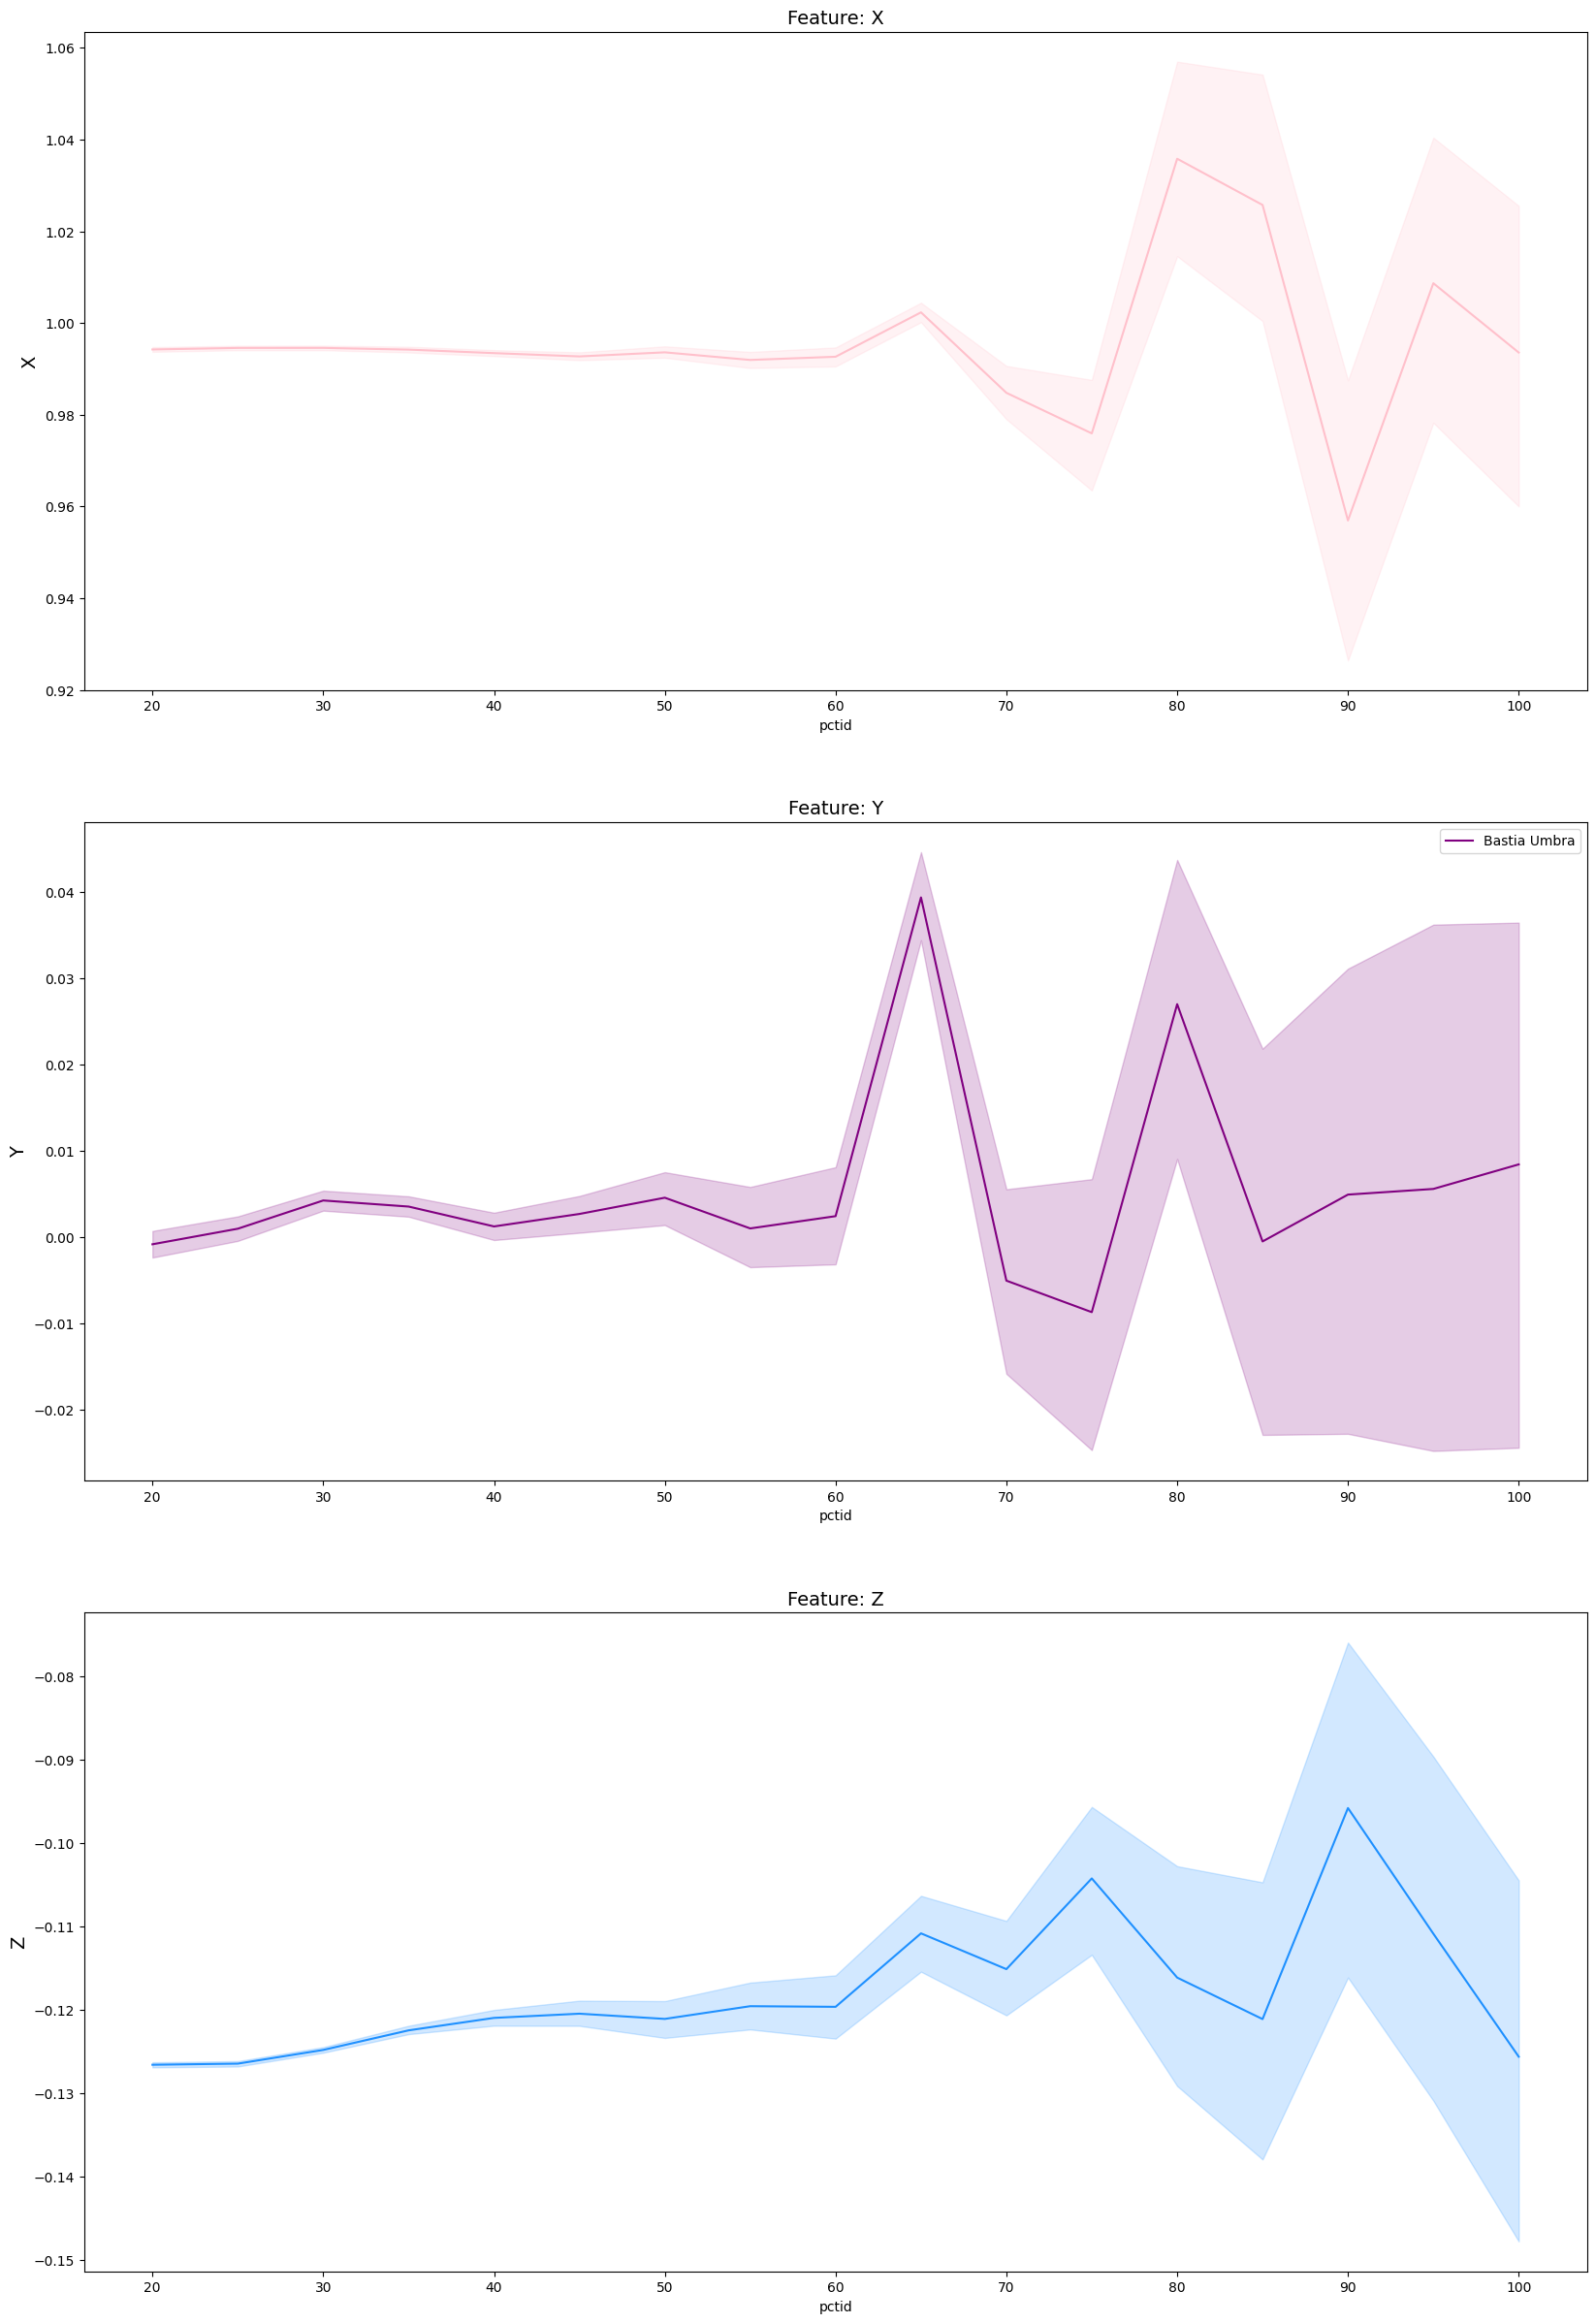

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

sns.lineplot(x=df.pctid, y=df.x.fillna(np.inf), ax=ax[0], color='pink')
ax[0].set_title('Feature: X', fontsize=14)
ax[0].set_ylabel(ylabel='X', fontsize=14)


sns.lineplot(x=df.pctid, y=df.y.fillna(np.inf), ax=ax[1], color='purple',label='Bastia Umbra')
ax[1].set_title('Feature: Y', fontsize=14)
ax[1].set_ylabel(ylabel='Y', fontsize=14)


sns.lineplot(x=df.pctid, y=df.z.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Z', fontsize=14)
ax[2].set_ylabel(ylabel='Z', fontsize=14)

plt.show()

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

sns.lineplot(x=df.x, y=df.wconfid.fillna(np.inf), ax=ax[0], color='pink')
ax[0].set_title('Feature: X', fontsize=14)
ax[0].set_ylabel(ylabel='X', fontsize=14)


sns.lineplot(x=df.x, y=df.wconfid.fillna(np.inf), ax=ax[1], color='purple',label='Bastia Umbra')
ax[1].set_title('Feature: Y', fontsize=14)
ax[1].set_ylabel(ylabel='Y', fontsize=14)


sns.lineplot(x=df.x, y=df.wconfid.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Z', fontsize=14)
ax[2].set_ylabel(ylabel='Z', fontsize=14)

plt.show()

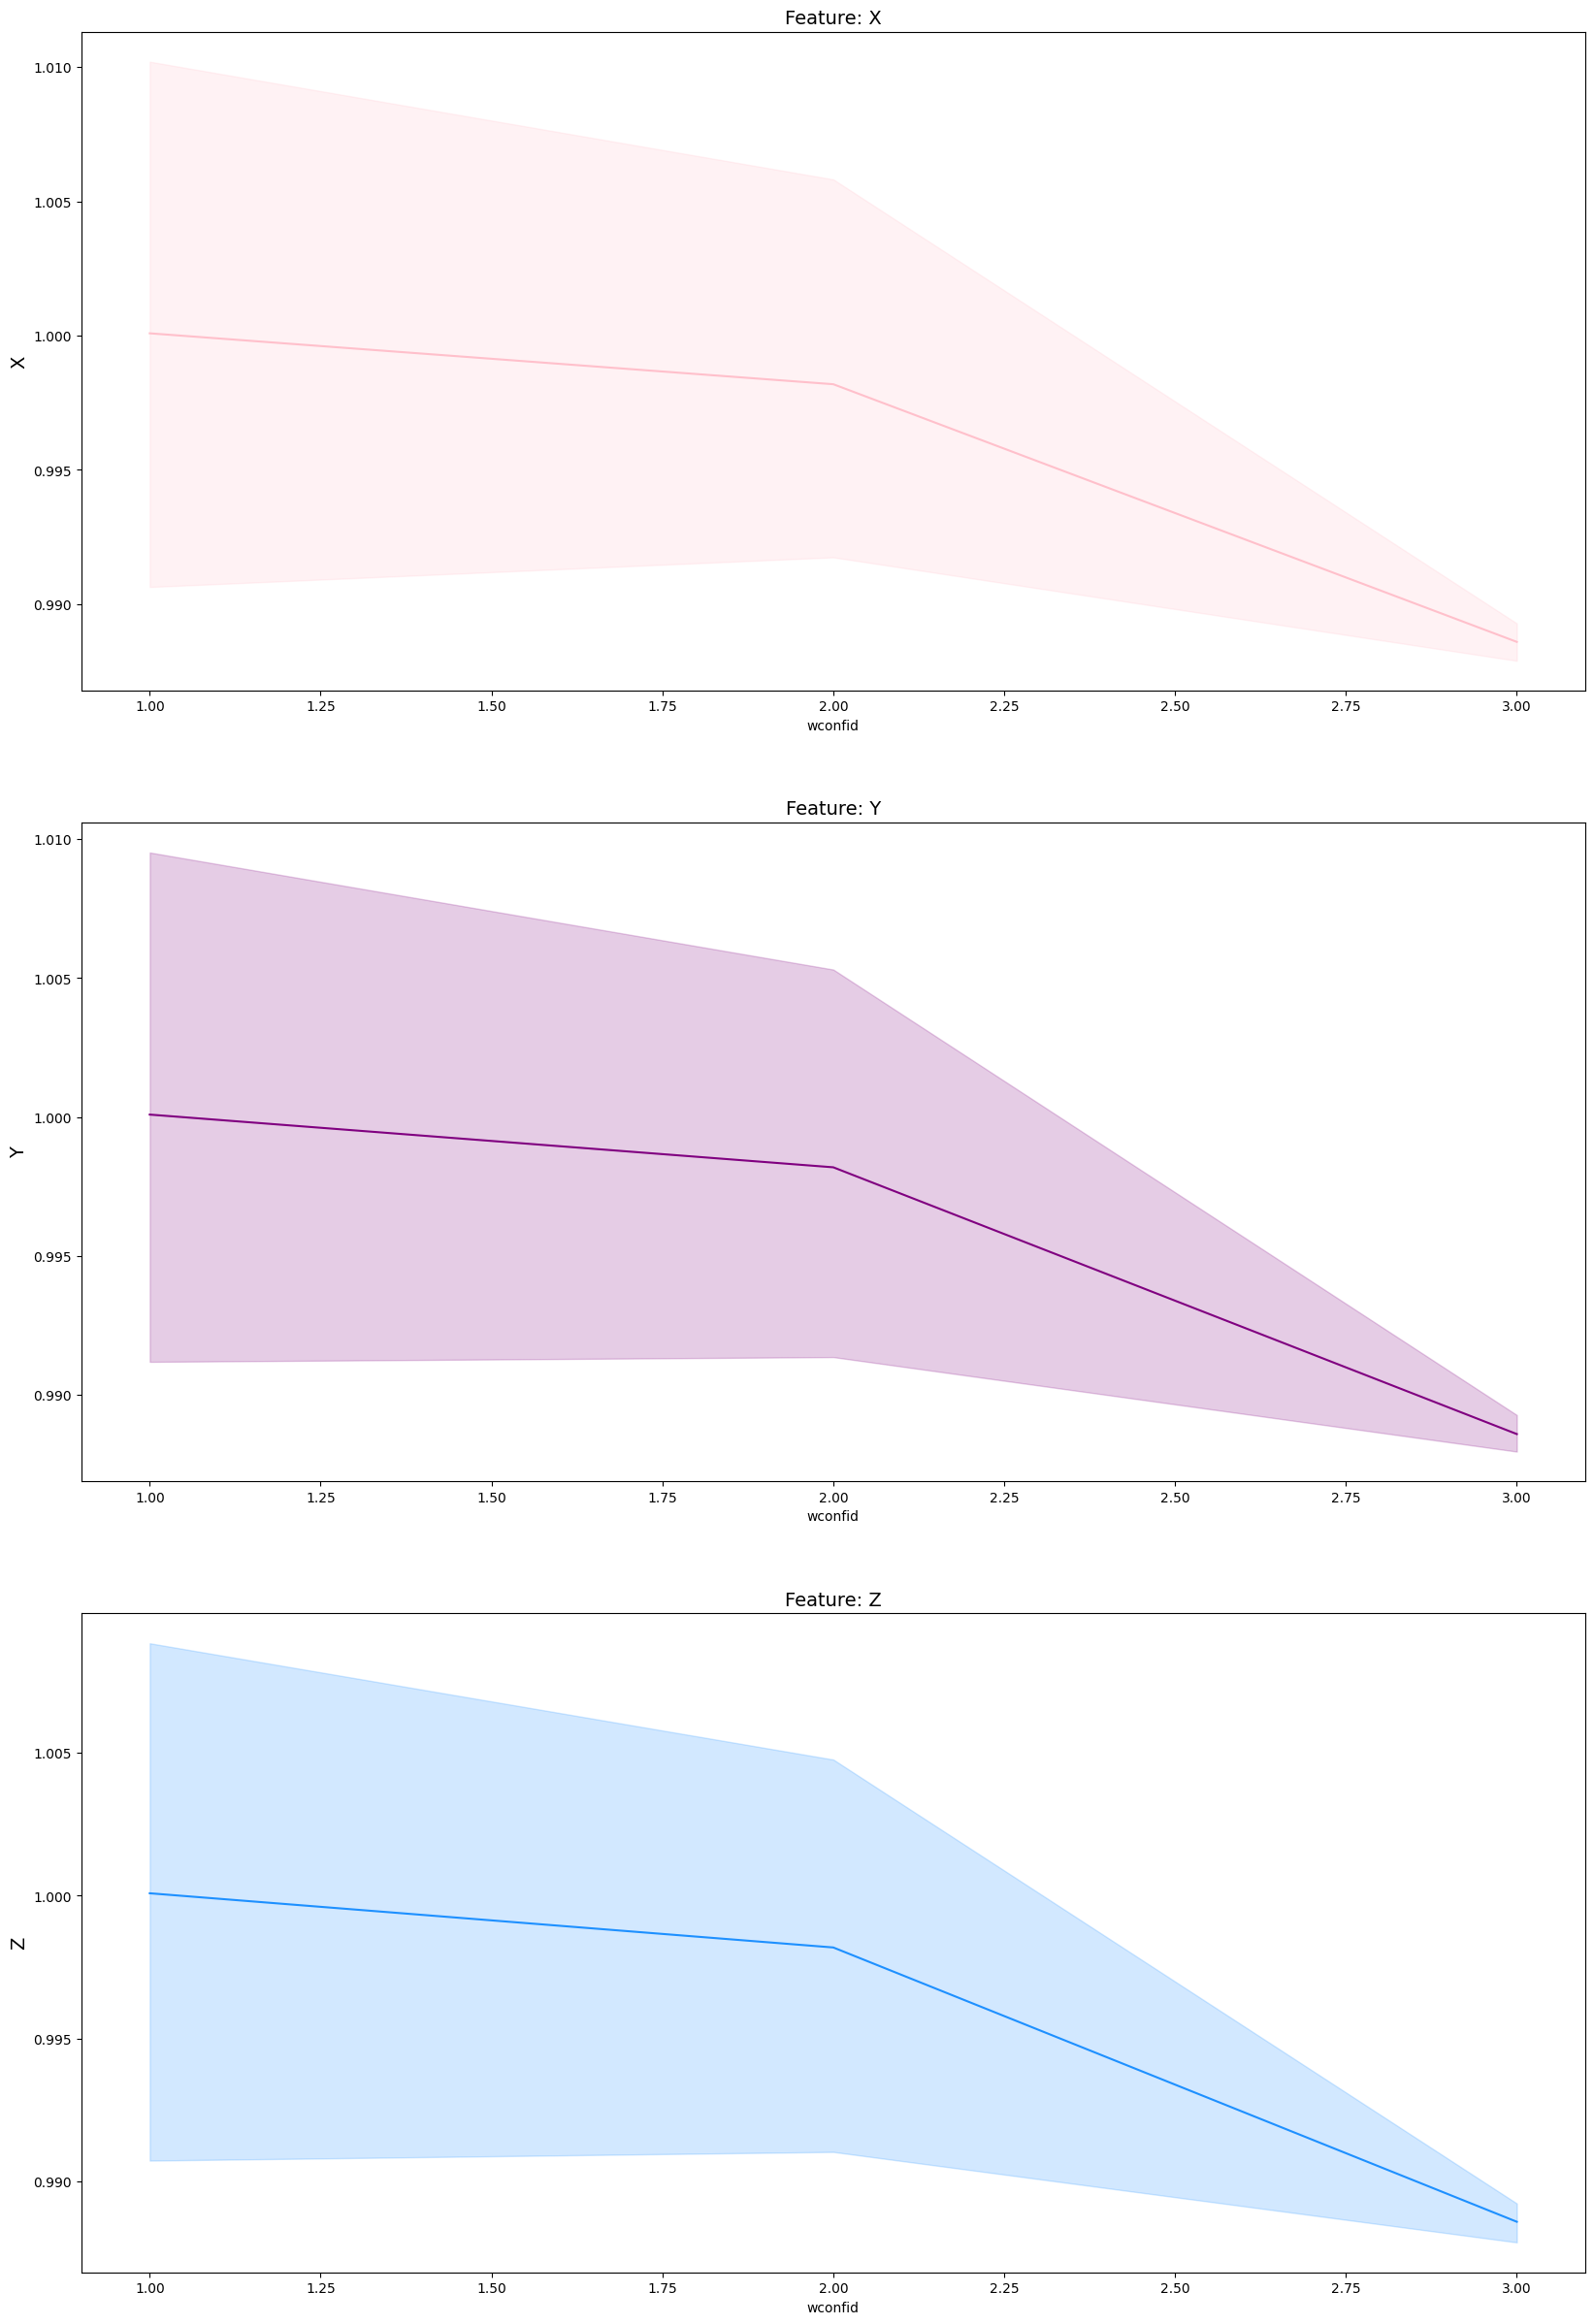

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

sns.lineplot(x=df.wconfid, y=df.x.fillna(np.inf), ax=ax[0], color='pink')
ax[0].set_title('Feature: X', fontsize=14)
ax[0].set_ylabel(ylabel='X', fontsize=14)


sns.lineplot(x=df.wconfid, y=df.x.fillna(np.inf), ax=ax[1], color='purple')
ax[1].set_title('Feature: Y', fontsize=14)
ax[1].set_ylabel(ylabel='Y', fontsize=14)


sns.lineplot(x=df.wconfid, y=df.x.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Z', fontsize=14)
ax[2].set_ylabel(ylabel='Z', fontsize=14)

plt.show()

<ipython-input-12-5060b7cebca5>:7: MatplotlibDeprecationWarning:

The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.



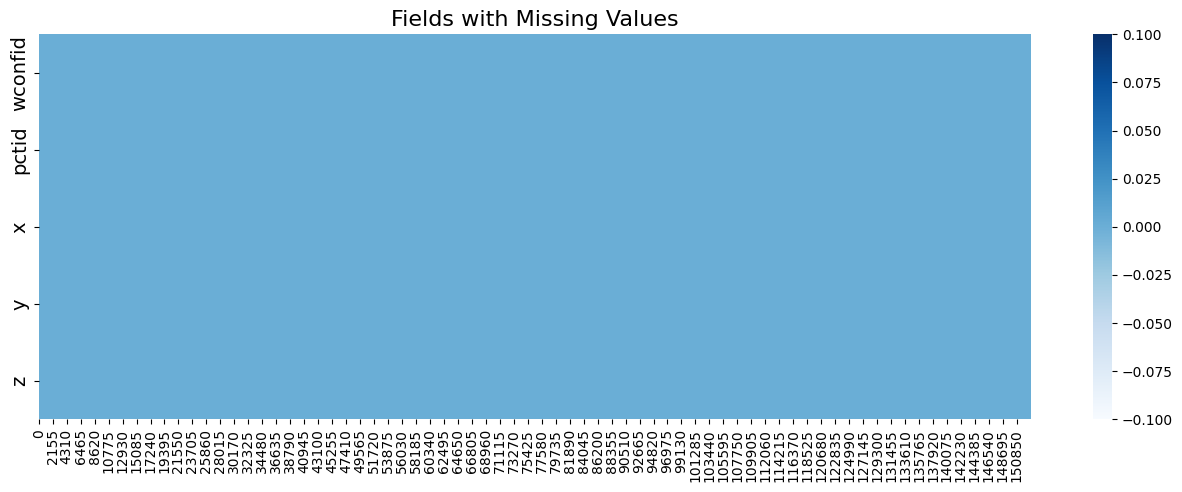

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

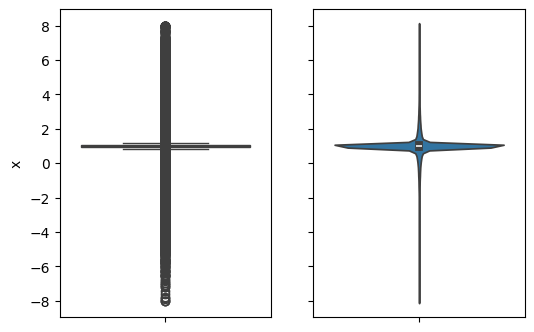

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=df["x"], ax=axes[0])
sns.violinplot(data=df["x"], ax=axes[1]);

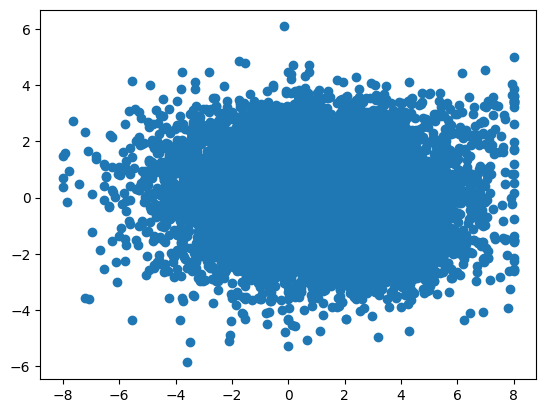

In [ ]:
plt.scatter(df["x"], df["z"]);

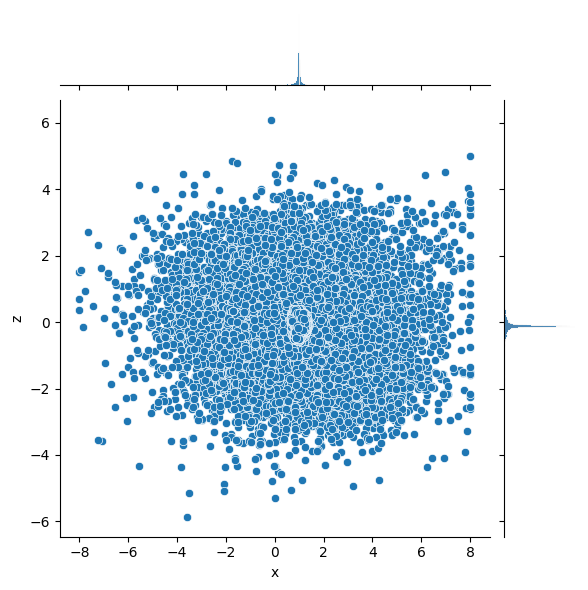

In [ ]:
sns.jointplot(x="x", y="z", data=df, kind="scatter");

In [ ]:
print( df.head(50))

    wconfid  pctid     x         y     z
0         1     20  1.00  9.00e-02 -0.12
1         1     20  1.00 -4.30e-02 -0.12
2         1     20  0.97  9.00e-02 -0.12
3         1     20  0.97 -1.20e-02 -0.14
4         1     20  1.00 -1.60e-02 -0.12
5         1     20  0.96  8.20e-02 -0.12
6         1     20  0.97 -5.50e-02 -0.11
7         1     20  1.00  1.20e-02 -0.13
8         1     20  0.97 -1.02e-01 -0.14
9         1     20  0.97 -5.90e-02 -0.12
10        1     20  1.01  4.30e-02 -0.13
11        1     20  1.00 -1.09e-01 -0.15
12        1     20  0.99 -2.00e-02 -0.12
13        1     20  1.01  4.30e-02 -0.13
14        1     20  1.00 -9.00e-02 -0.15
15        1     20  0.96 -1.02e-01 -0.12
16        1     20  1.00  5.50e-02 -0.12
17        1     20  0.99 -5.90e-02 -0.14
18        1     20  0.97 -8.60e-02 -0.12
19        1     20  1.04  9.40e-02 -0.12
20        1     20  0.98  1.13e-01 -0.15
21        1     20  1.01  1.20e-02 -0.14
22        1     20  1.00  3.50e-02 -0.14
23        1     

First second of x data
Second second of x data

<Axes: >

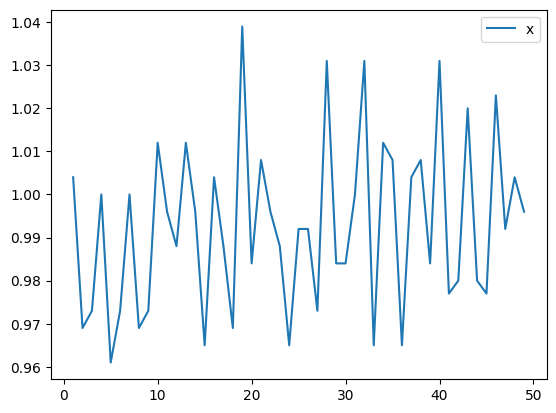

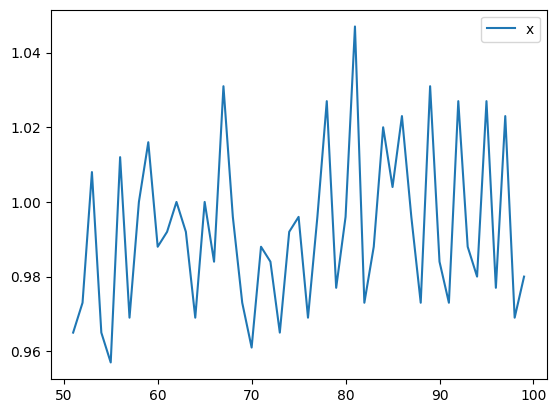

In [ ]:
df.iloc[1:50].plot(y='x')
df.iloc[51:100].plot(y='x')


<Axes: >

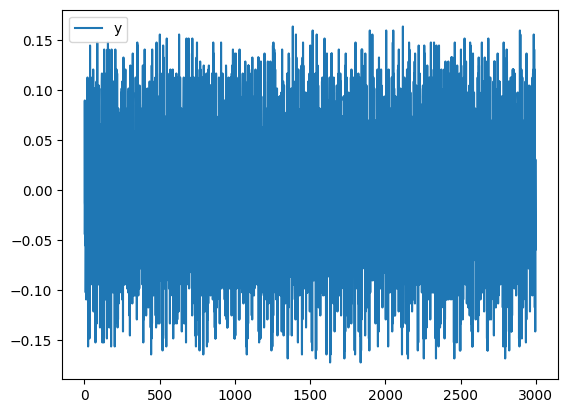

In [ ]:
df.iloc[1:3000].plot(y='y')

fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
window = 1
fs = 20
window_size = window * fs

In [ ]:
df.head(5)

wconfid  pctid     x     y     z
0        1     20  1.00  0.09 -0.12
1        1     20  1.00 -0.04 -0.12
2        1     20  0.97  0.09 -0.12
3        1     20  0.97 -0.01 -0.14
4        1     20  1.00 -0.02 -0.12

In [ ]:
# eval activities
speed_stats = df.pctid.value_counts()
print(speed_stats)
speeds = speed_stats.index.tolist()
print(speeds)

pctid
20     9000
25     9000
30     9000
35     9000
40     9000
45     9000
50     9000
55     9000
60     9000
65     9000
70     9000
75     9000
80     9000
85     9000
90     9000
95     9000
100    9000
Name: count, dtype: int64
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [ ]:
# eval activities
confid_stats = df.wconfid.value_counts()
print(confid_stats)
confids = confid_stats.index.tolist()
print(confids)

wconfid
1    51000
2    51000
3    51000
Name: count, dtype: int64
[1, 2, 3]


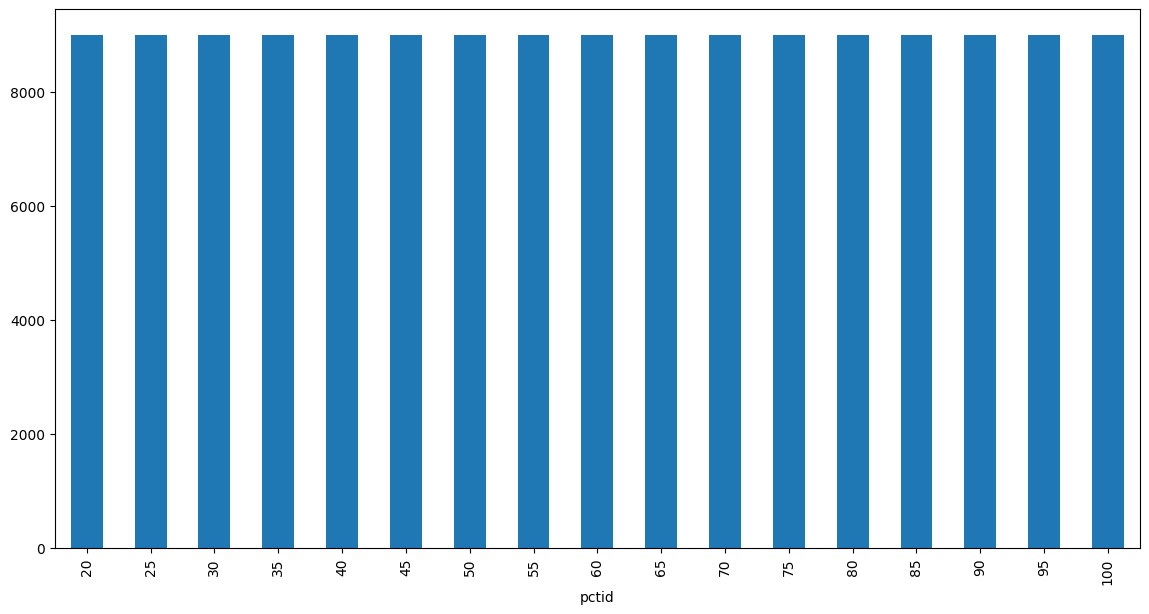

In [ ]:
speed_stats.plot(kind='bar',figsize=(14,7))
plt.show()

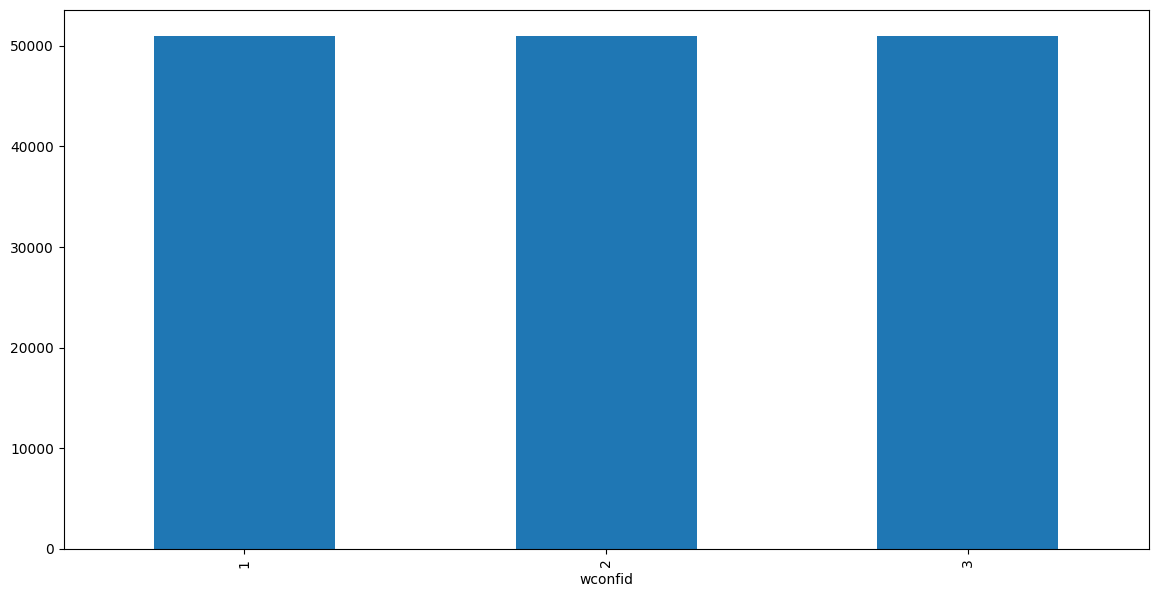

In [ ]:
confid_stats.plot(kind='bar',figsize=(14,7))
plt.show()

In [ ]:
# config vs.speed
pd.crosstab(df.wconfid, df.pctid)

pctid     20    25    30    35    40    45    50    55    60    65    70   \
wconfid                                                                     
1        3000  3000  3000  3000  3000  3000  3000  3000  3000  3000  3000   
2        3000  3000  3000  3000  3000  3000  3000  3000  3000  3000  3000   
3        3000  3000  3000  3000  3000  3000  3000  3000  3000  3000  3000   

pctid     75    80    85    90    95    100  
wconfid                                      
1        3000  3000  3000  3000  3000  3000  
2        3000  3000  3000  3000  3000  3000  
3        3000  3000  3000  3000  3000  3000

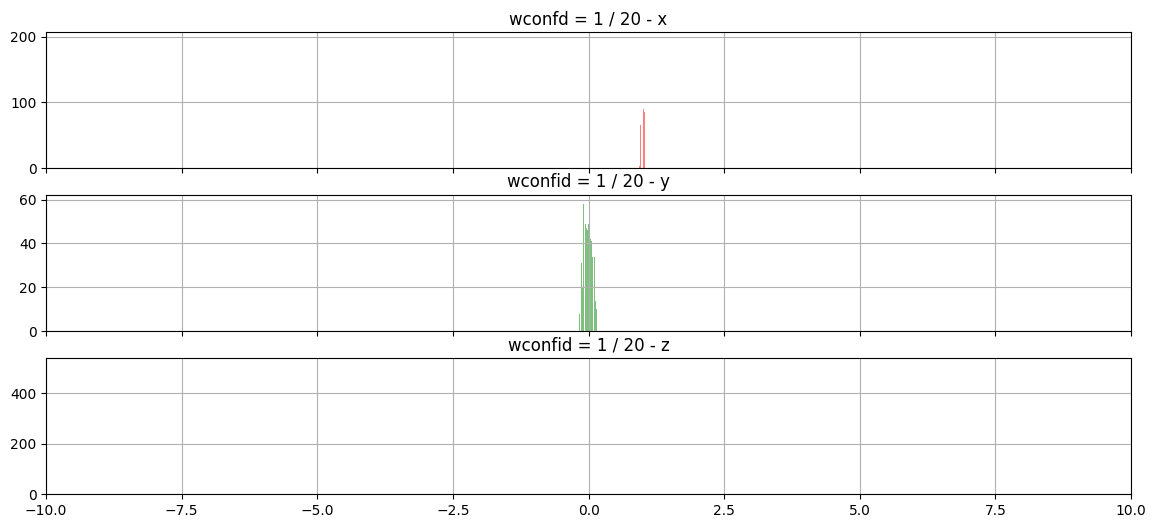

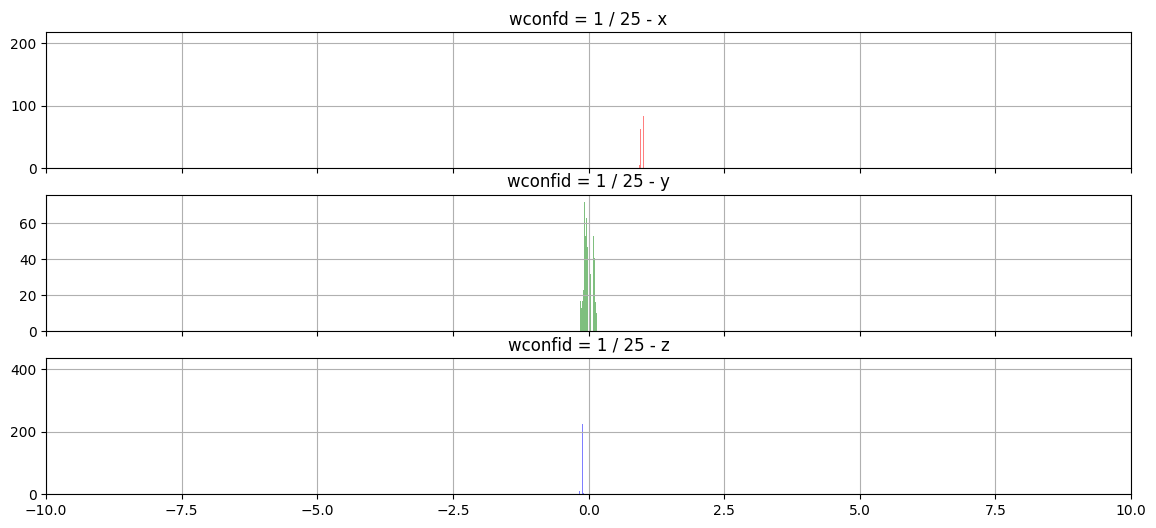

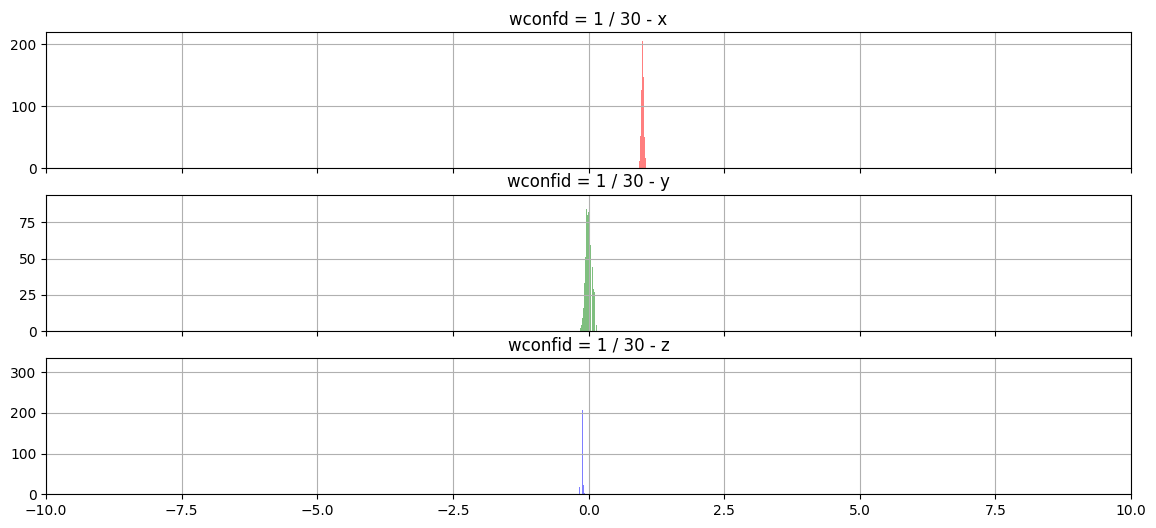

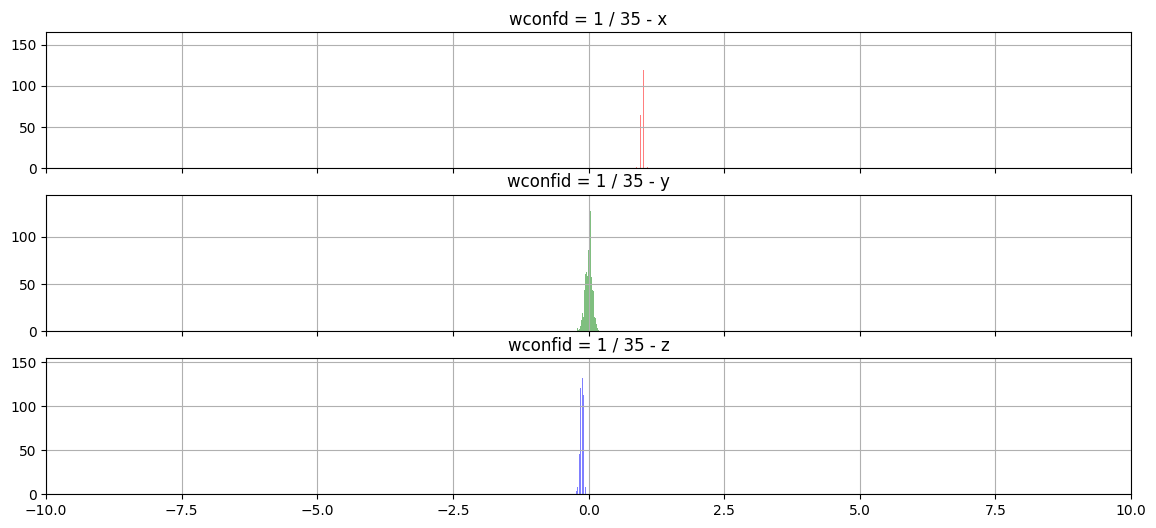

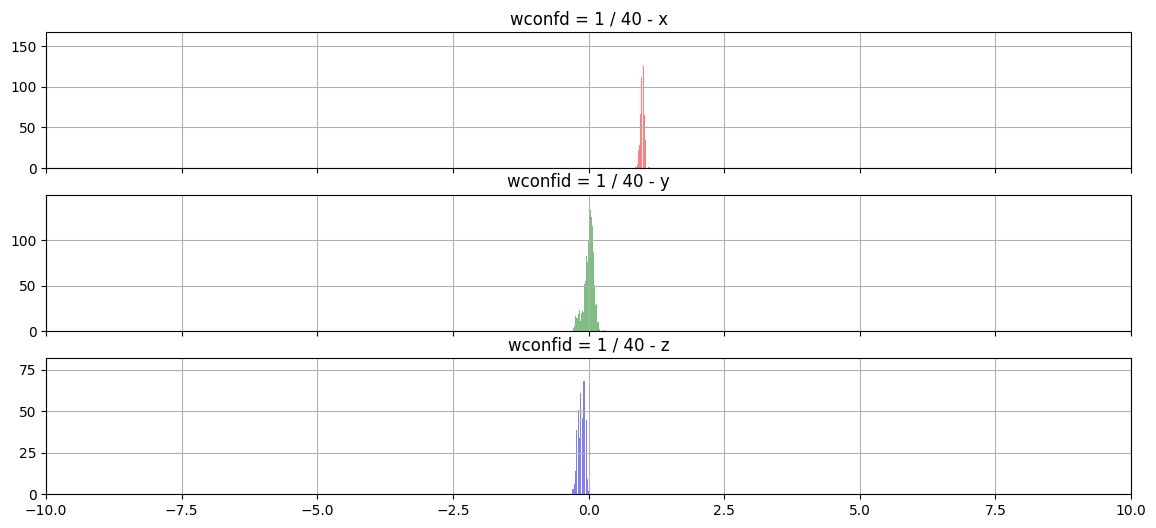

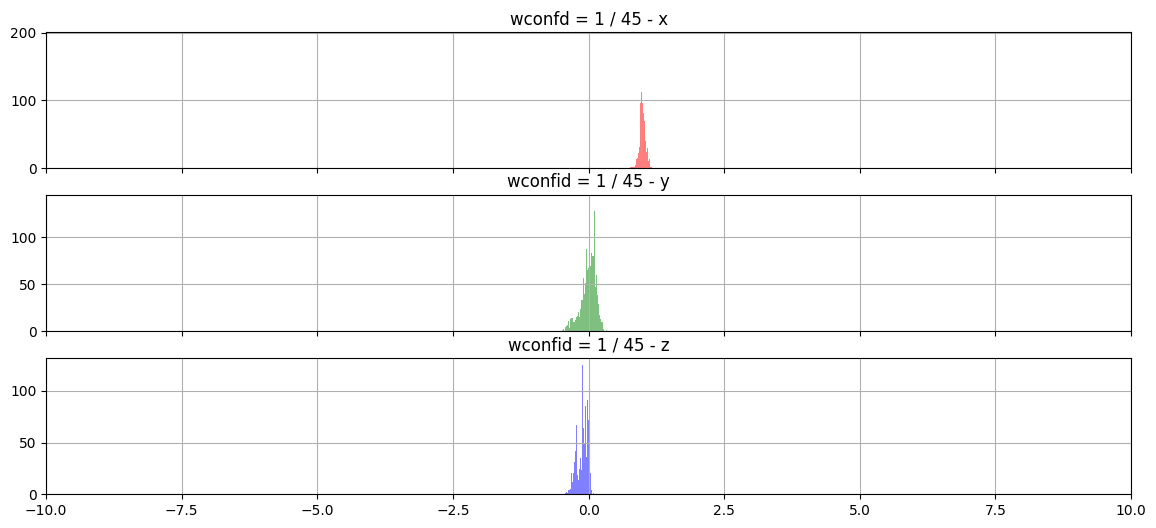

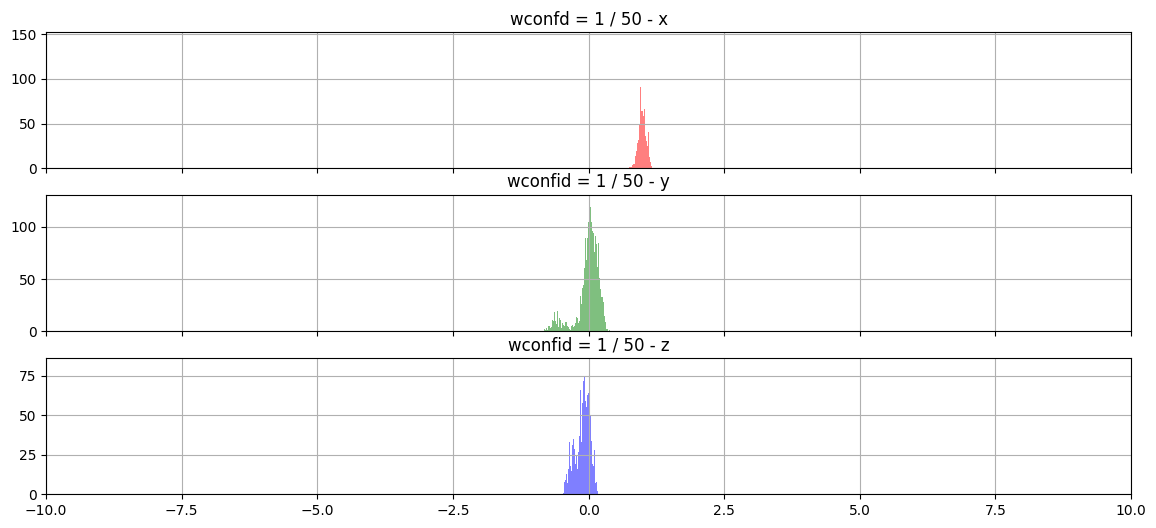

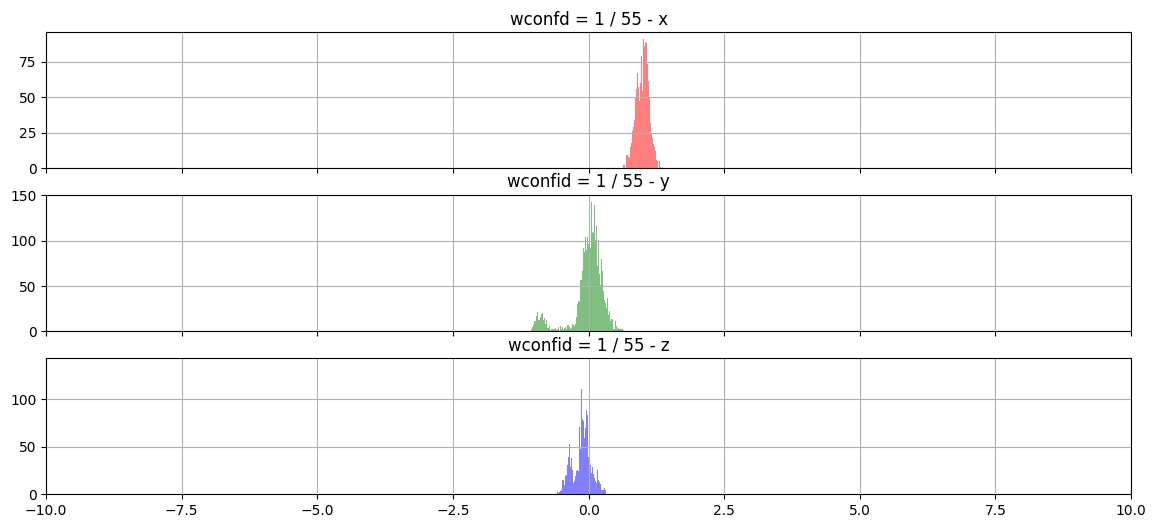

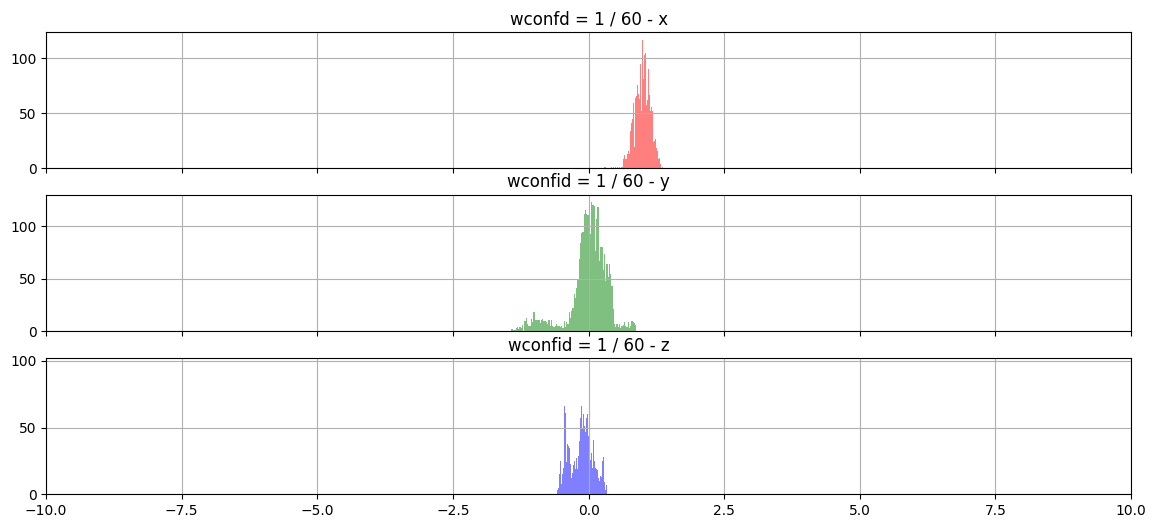

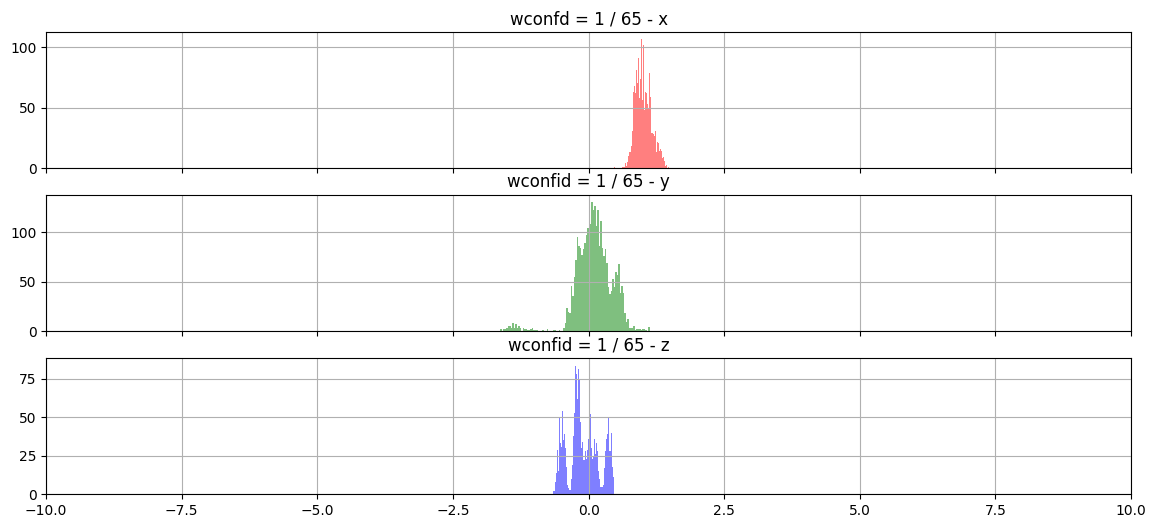

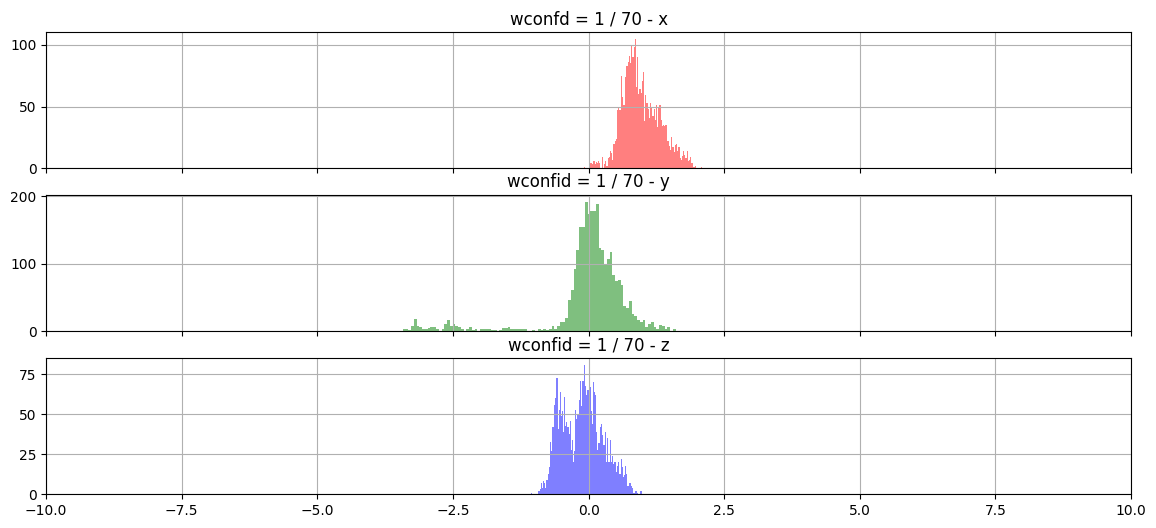

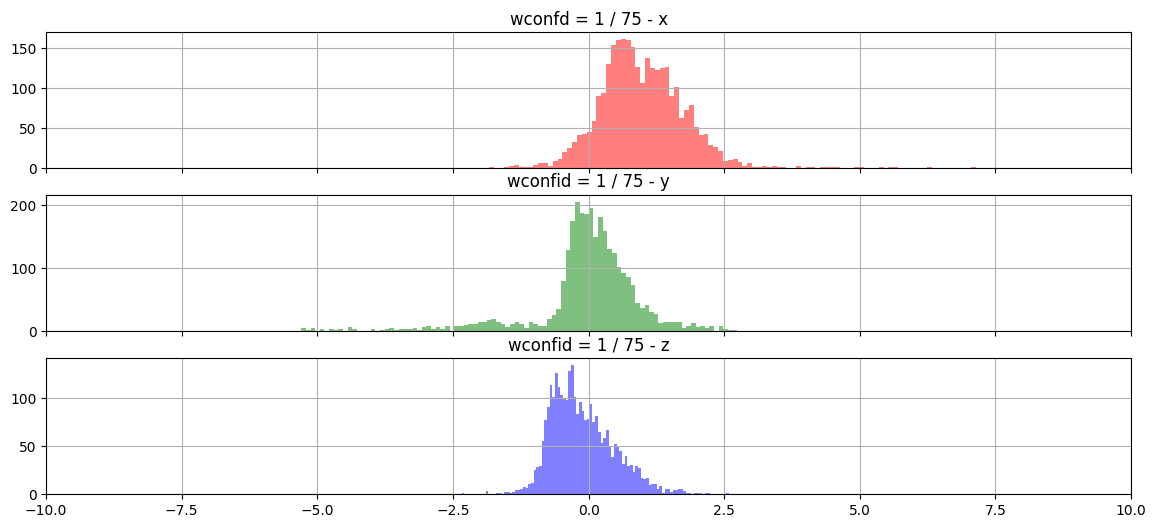

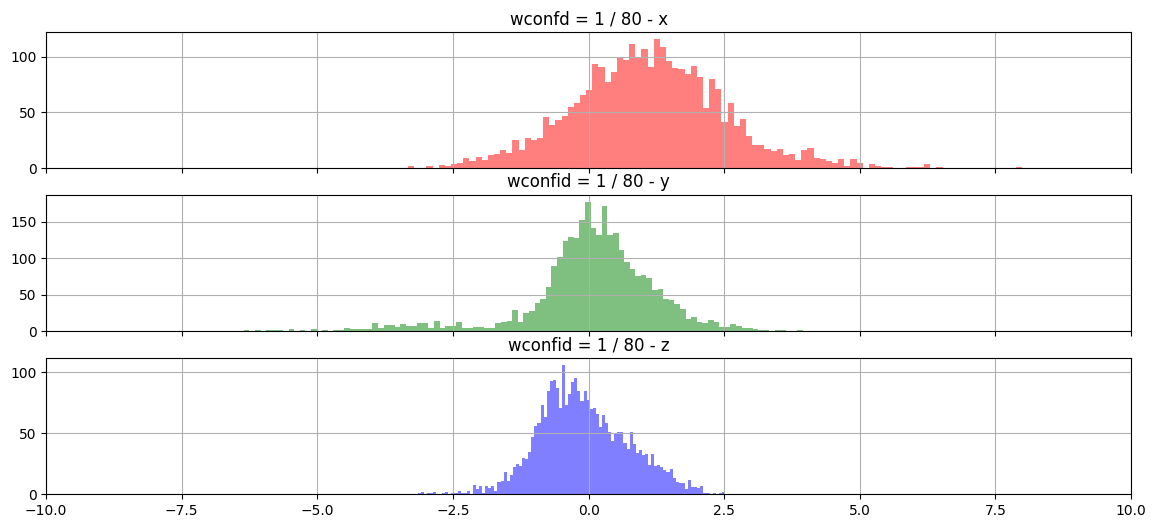

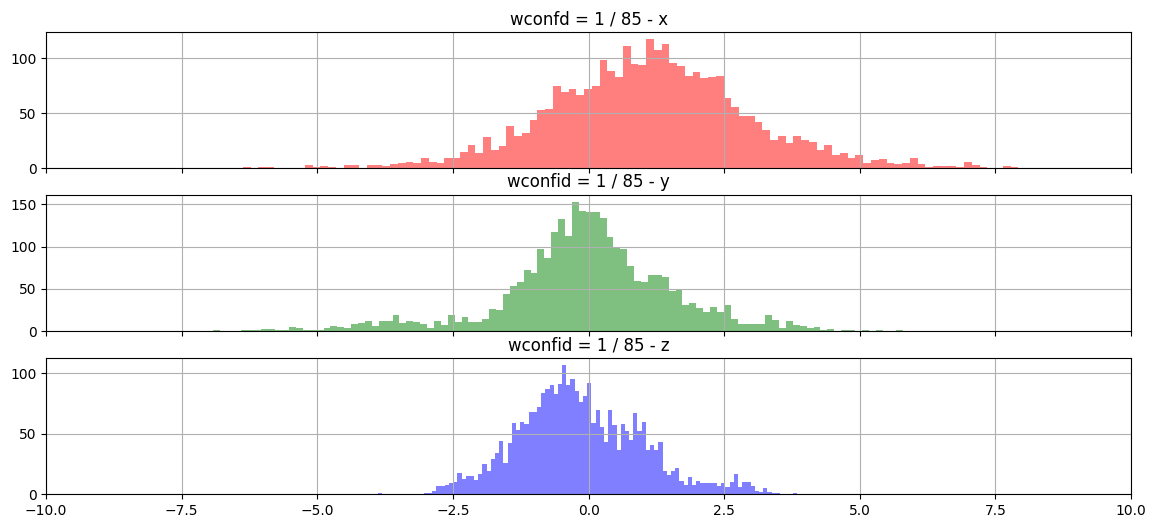

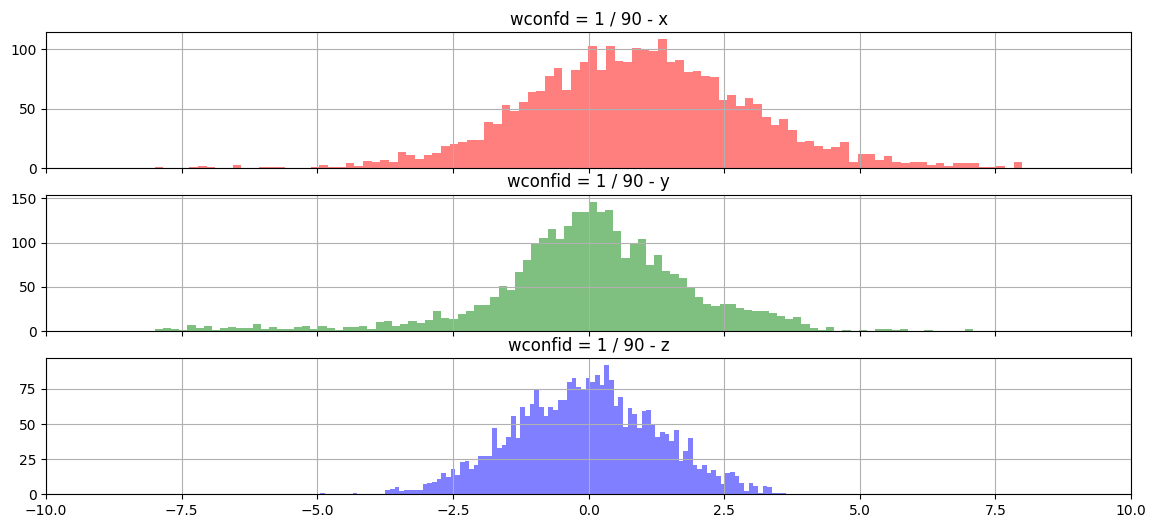

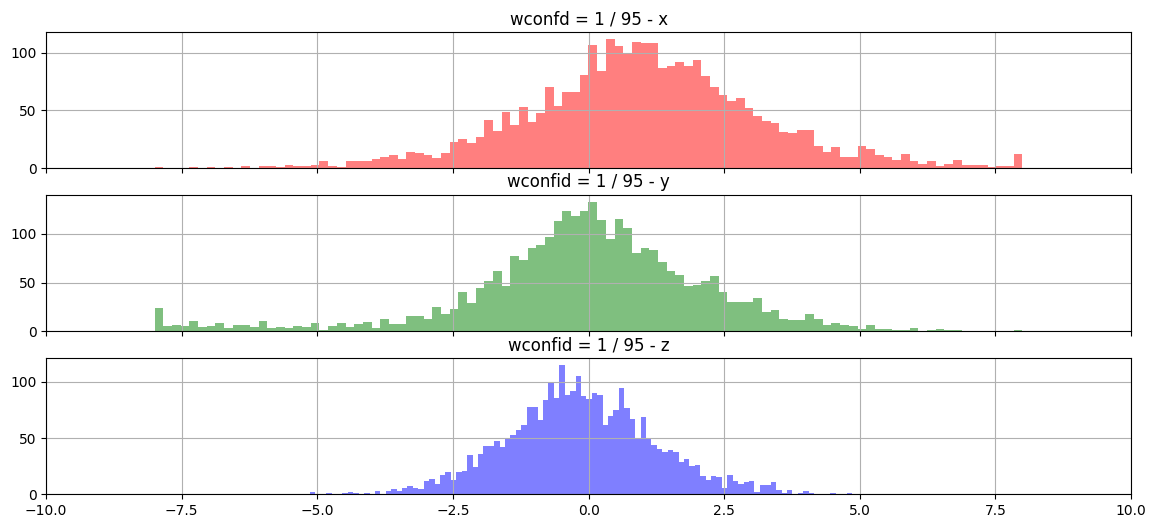

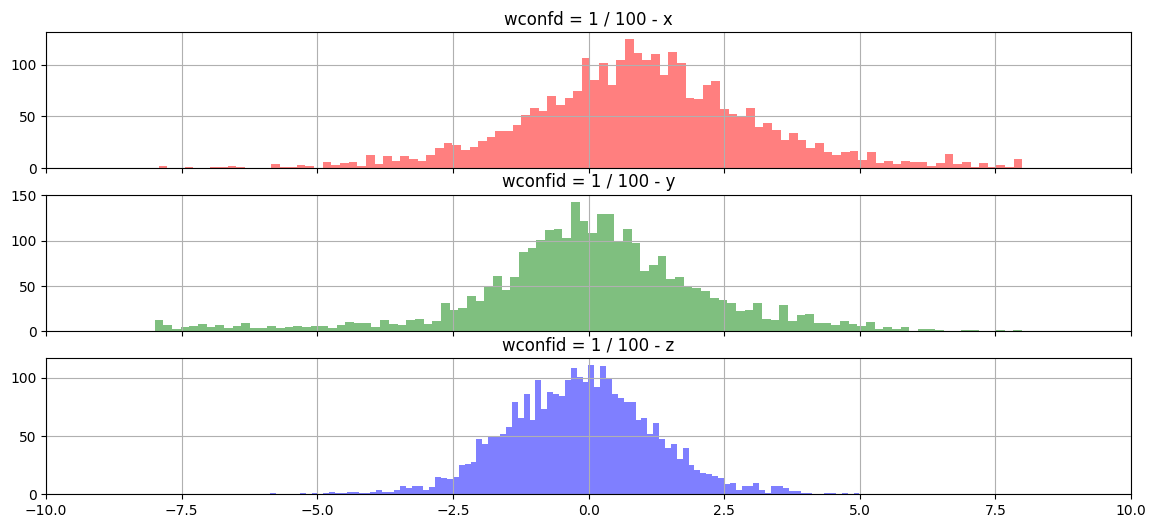

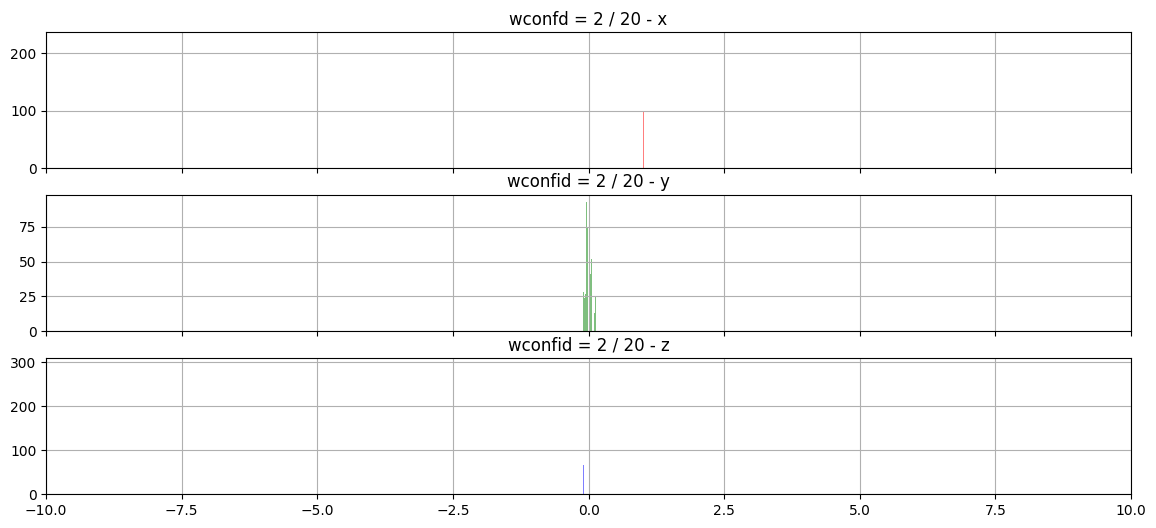

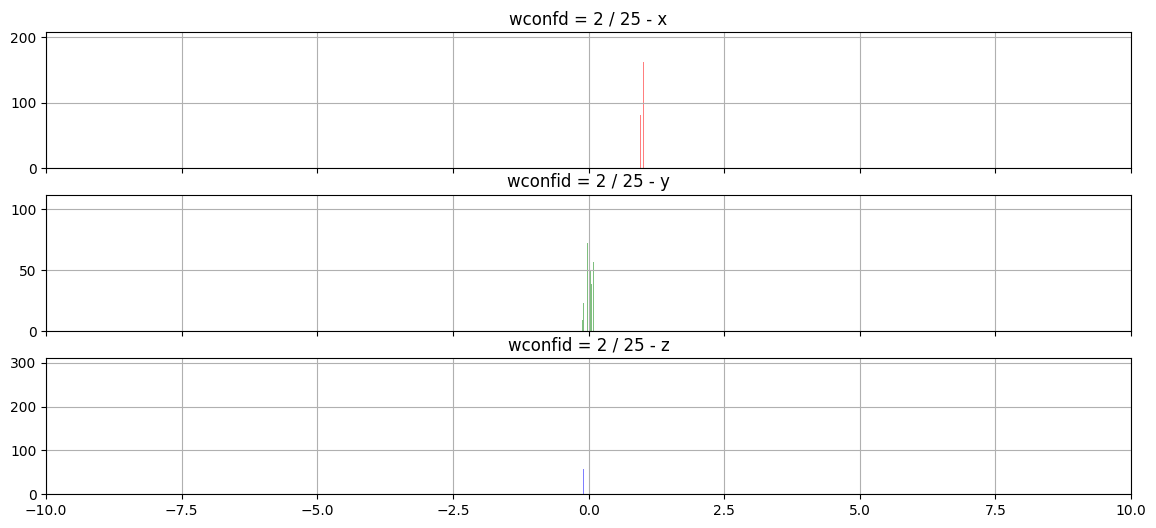

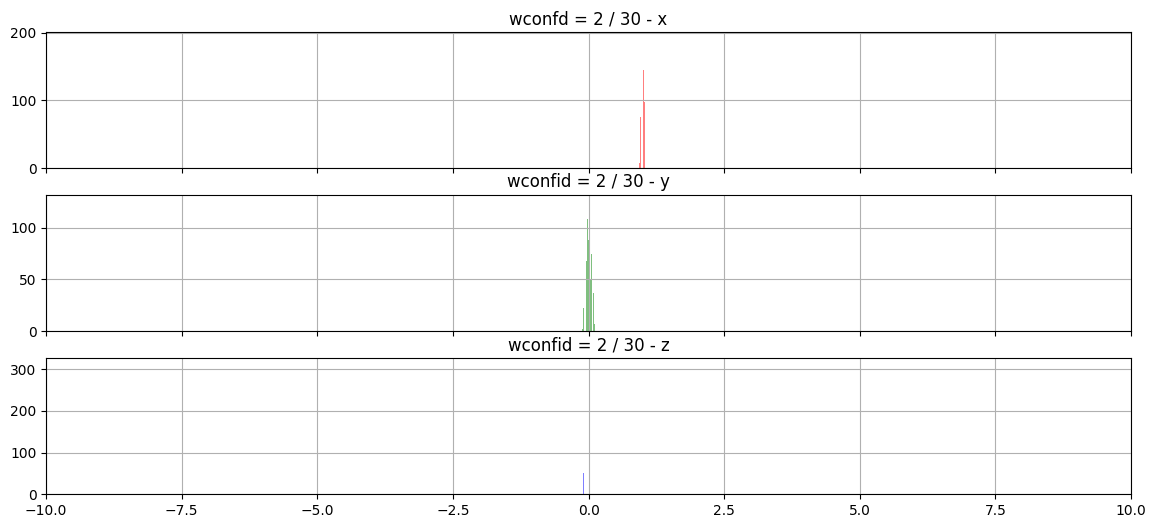

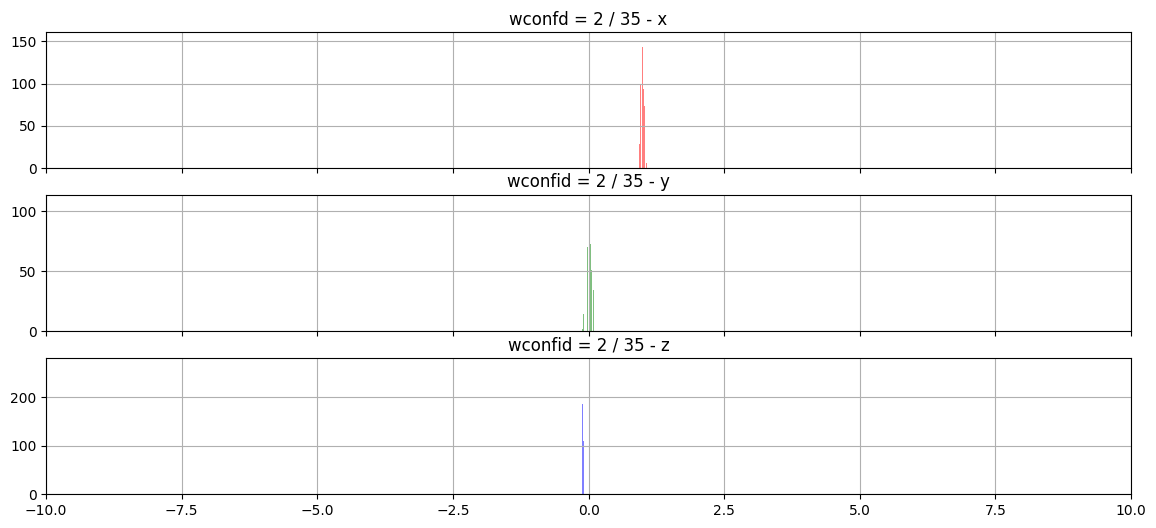

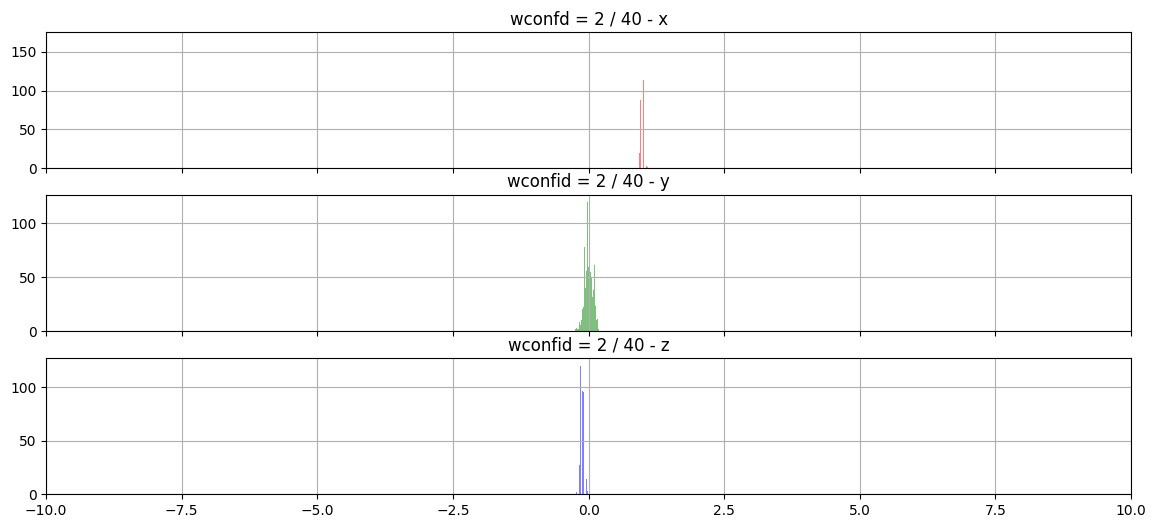

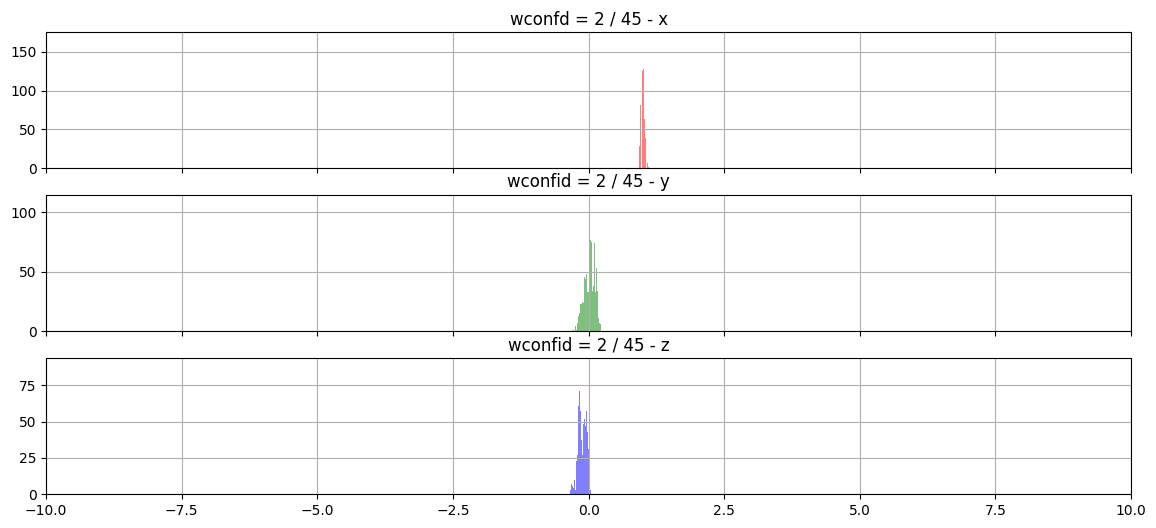

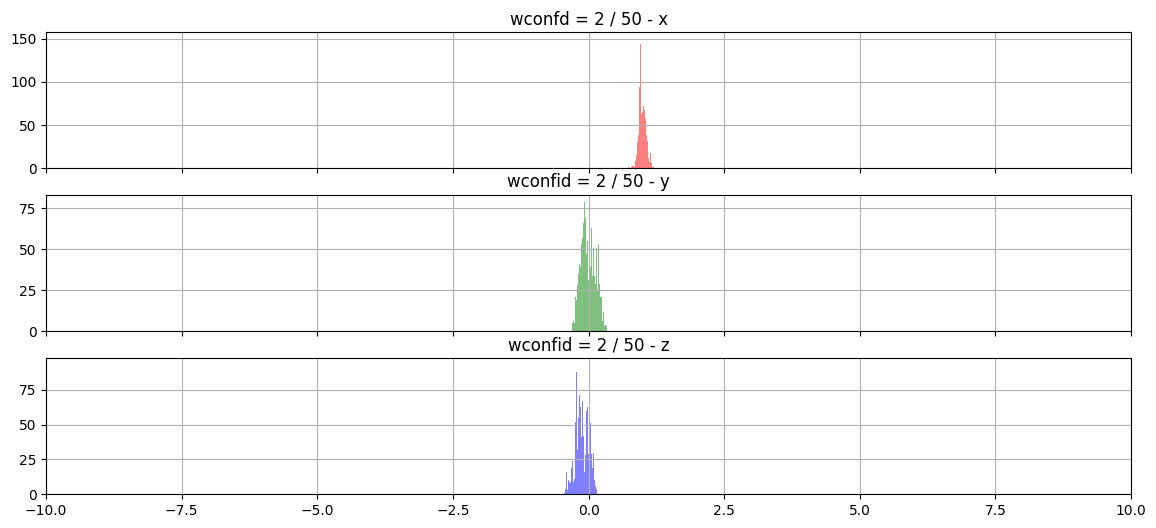

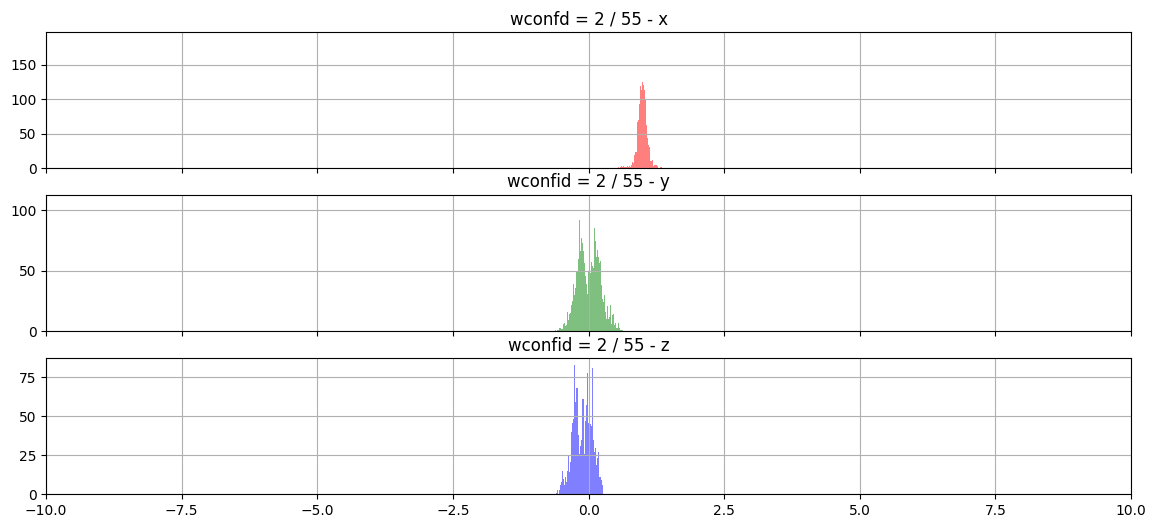

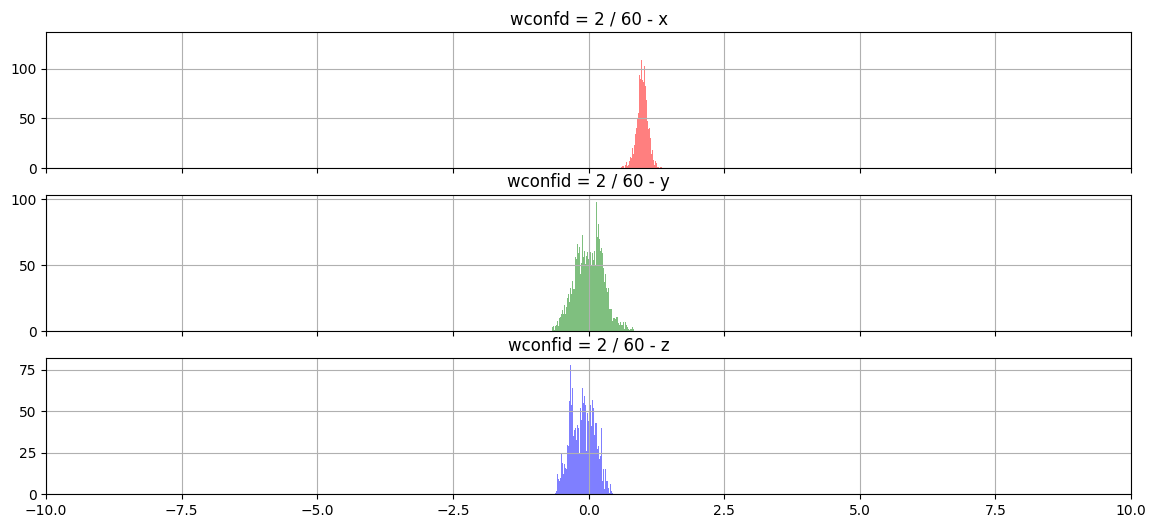

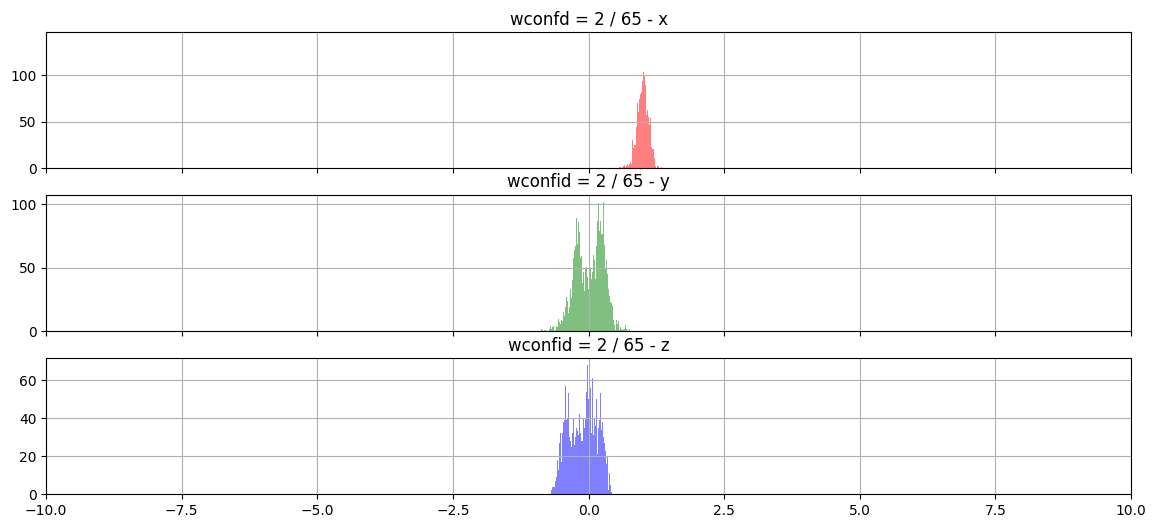

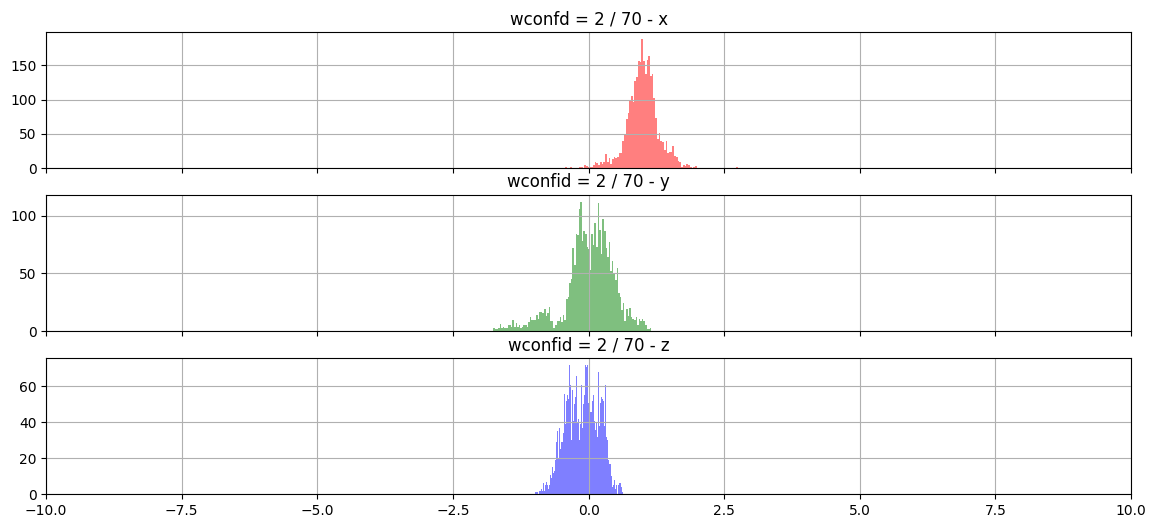

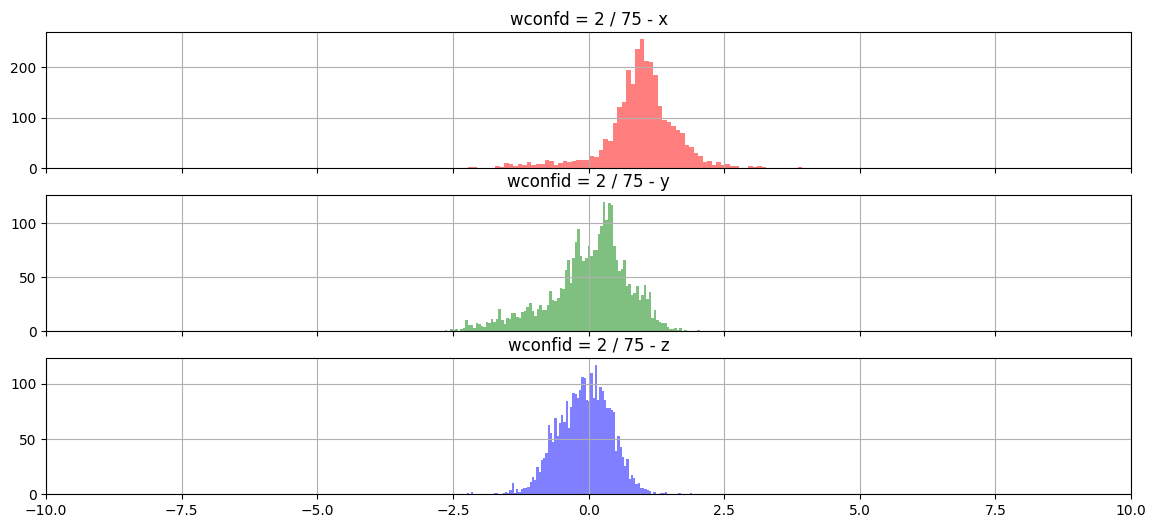

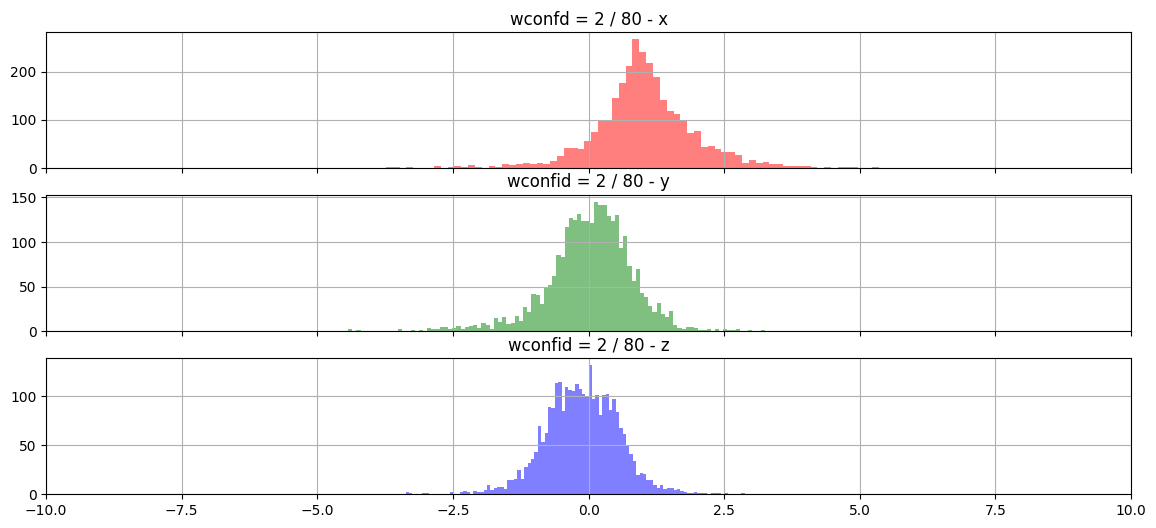

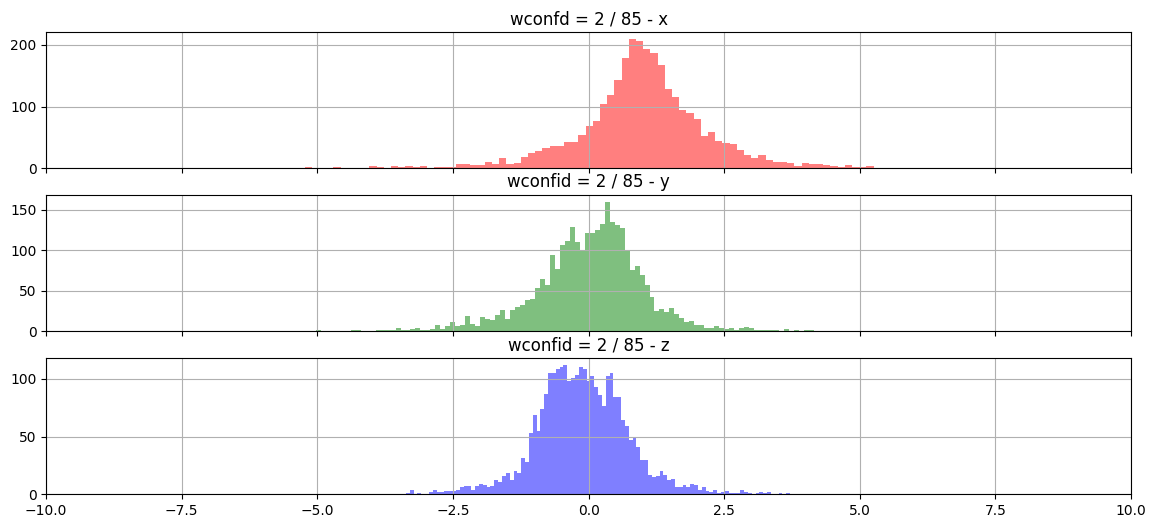

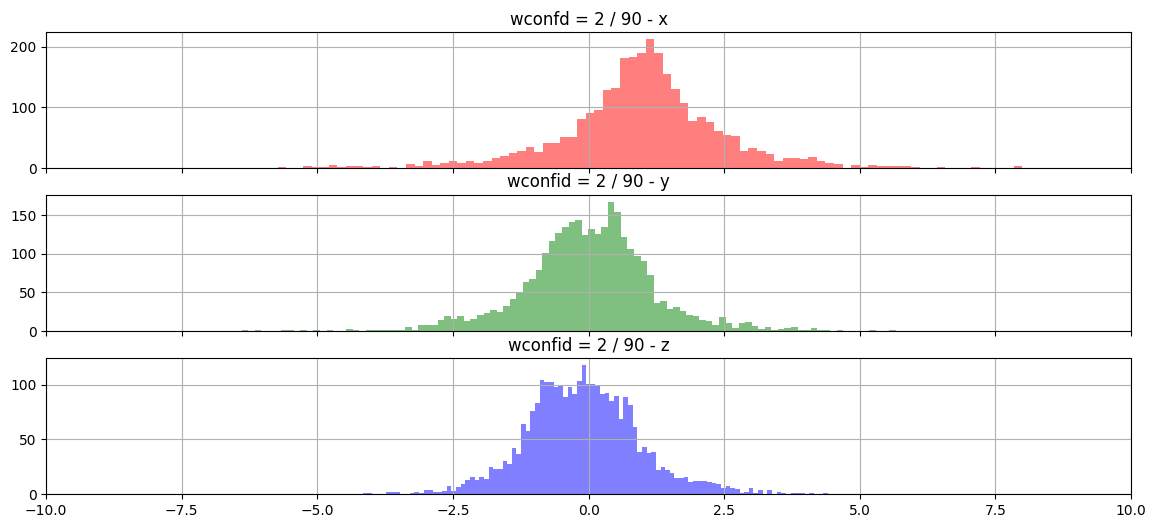

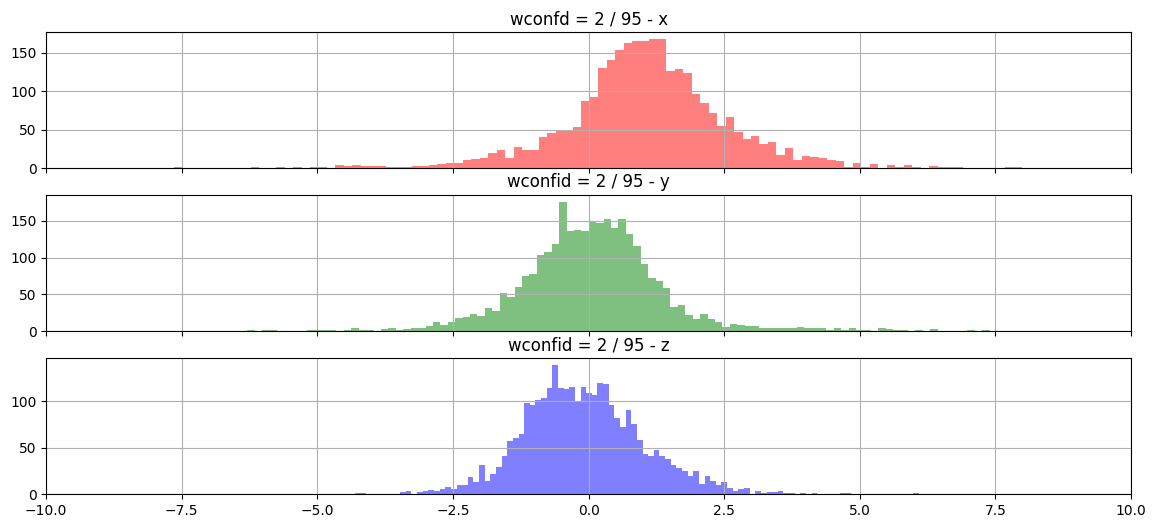

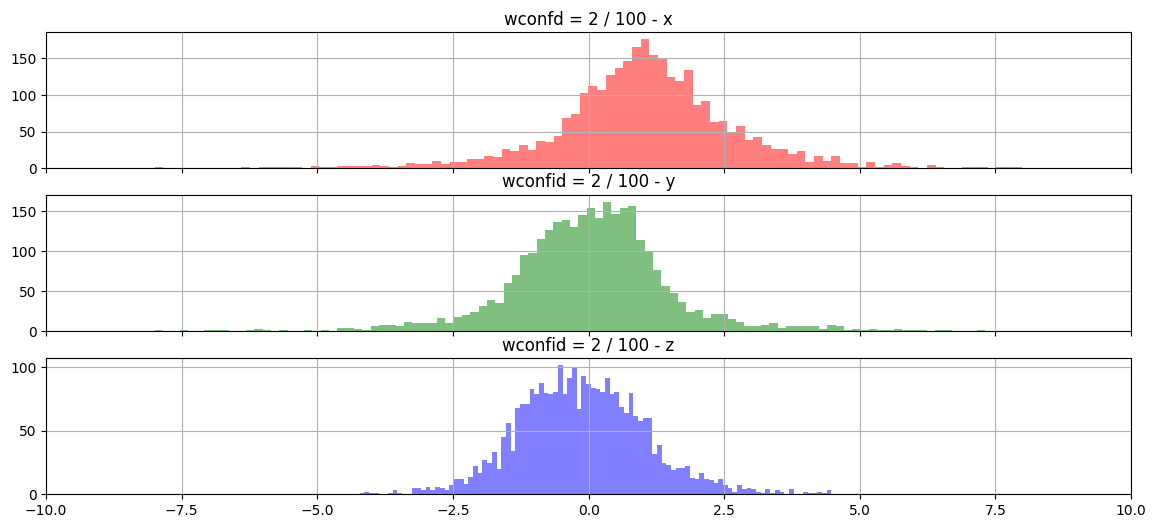

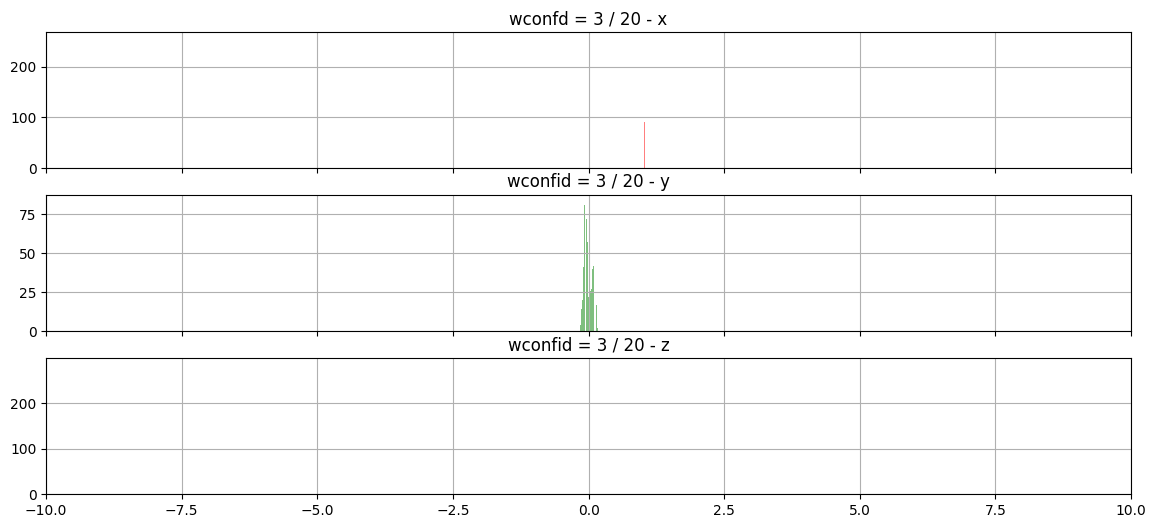

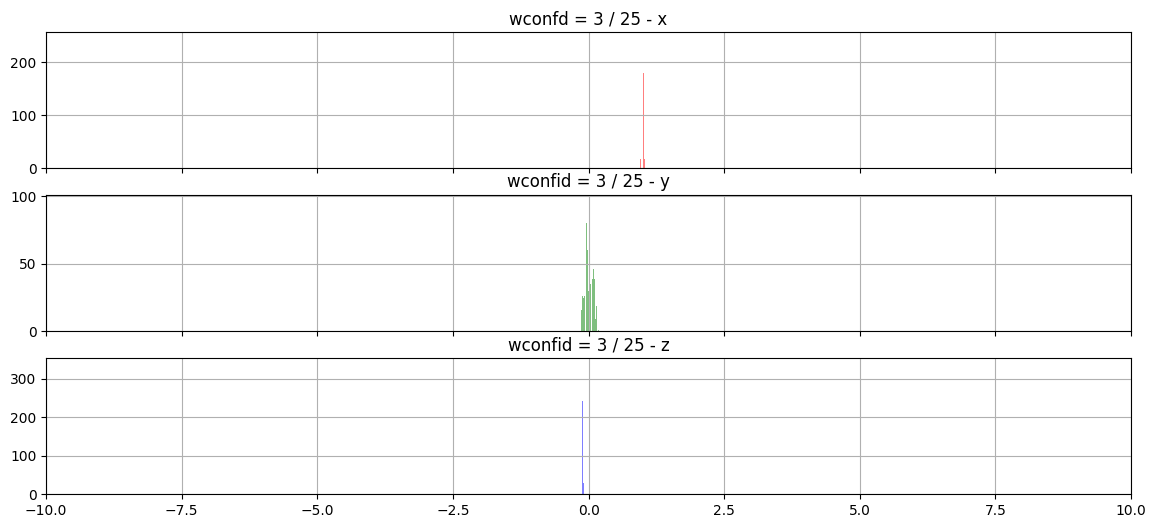

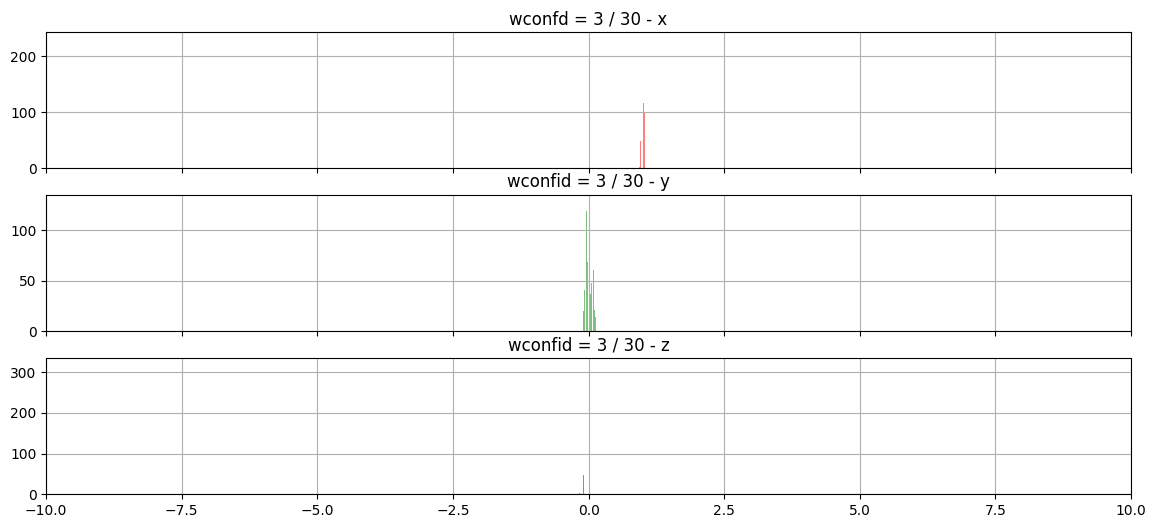

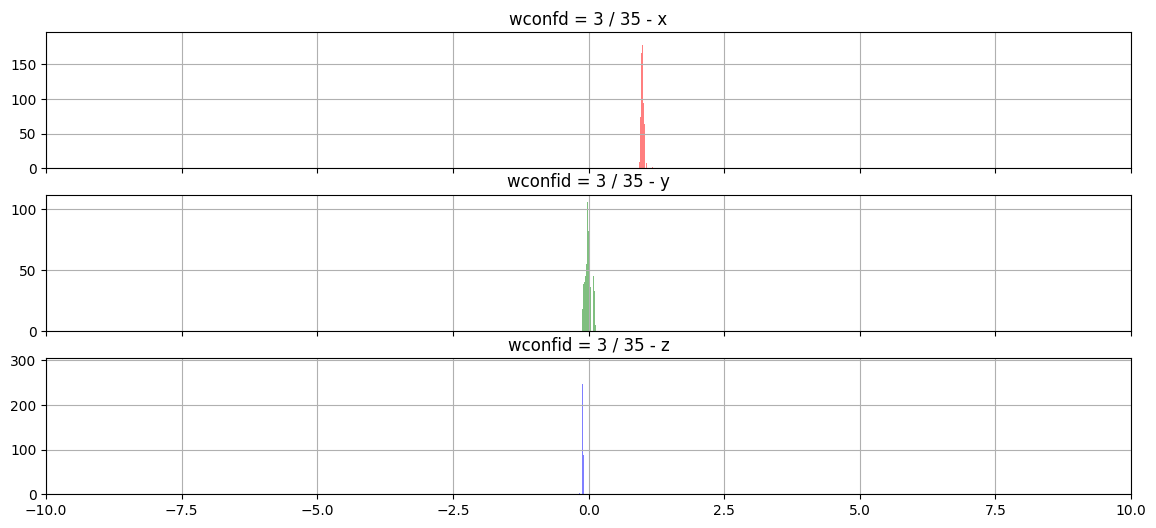

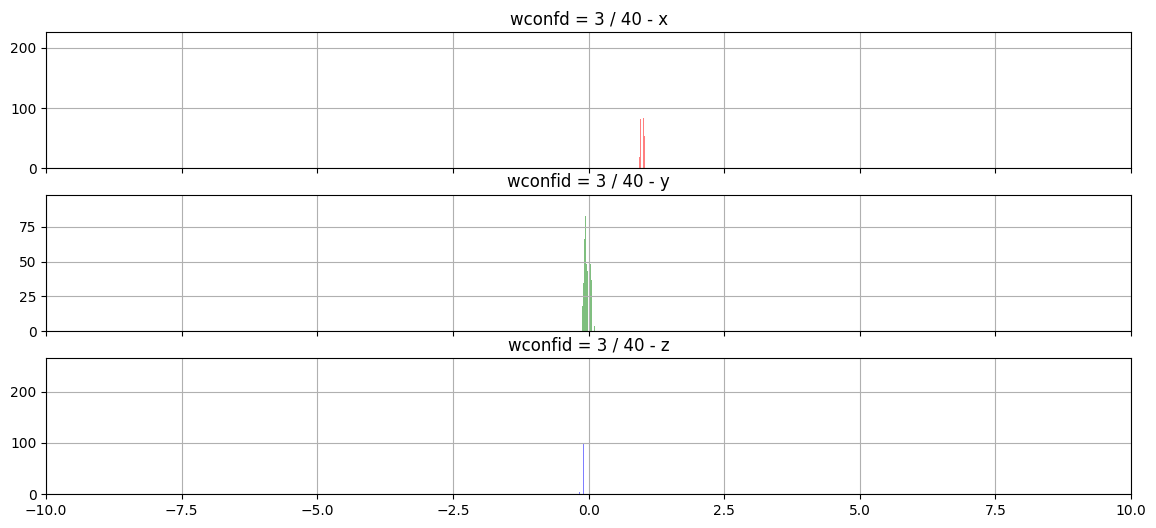

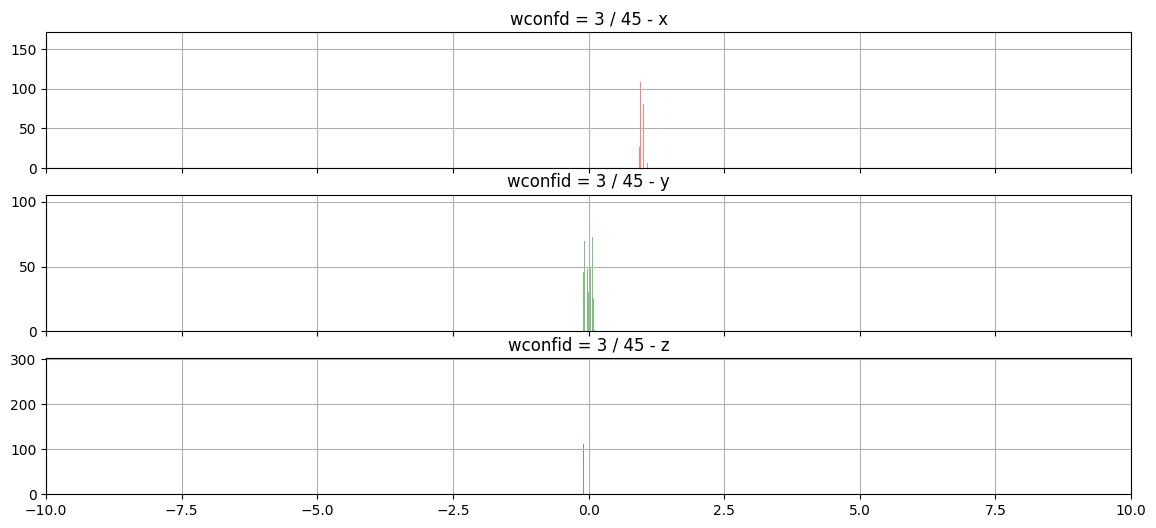

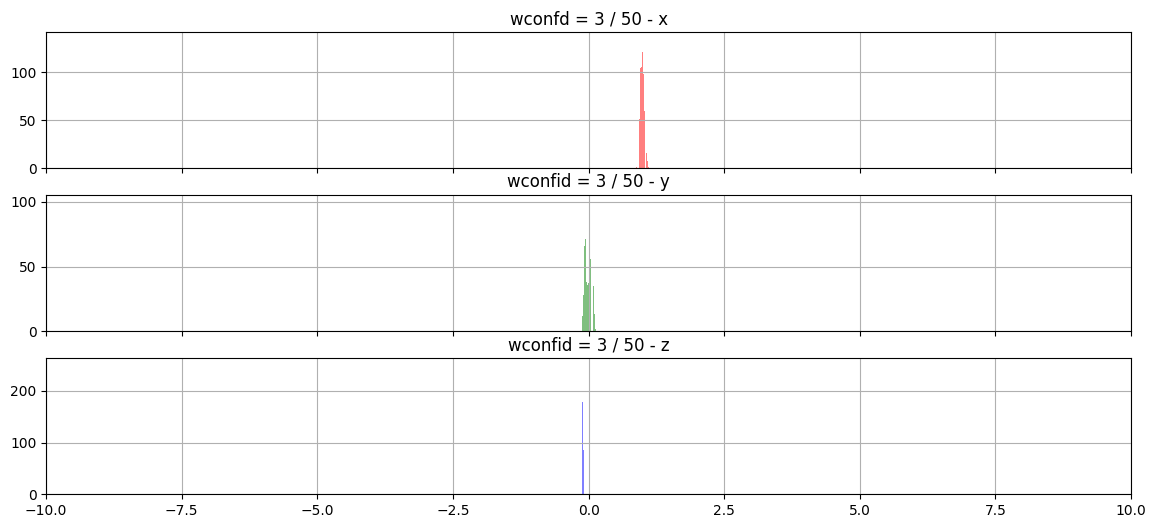

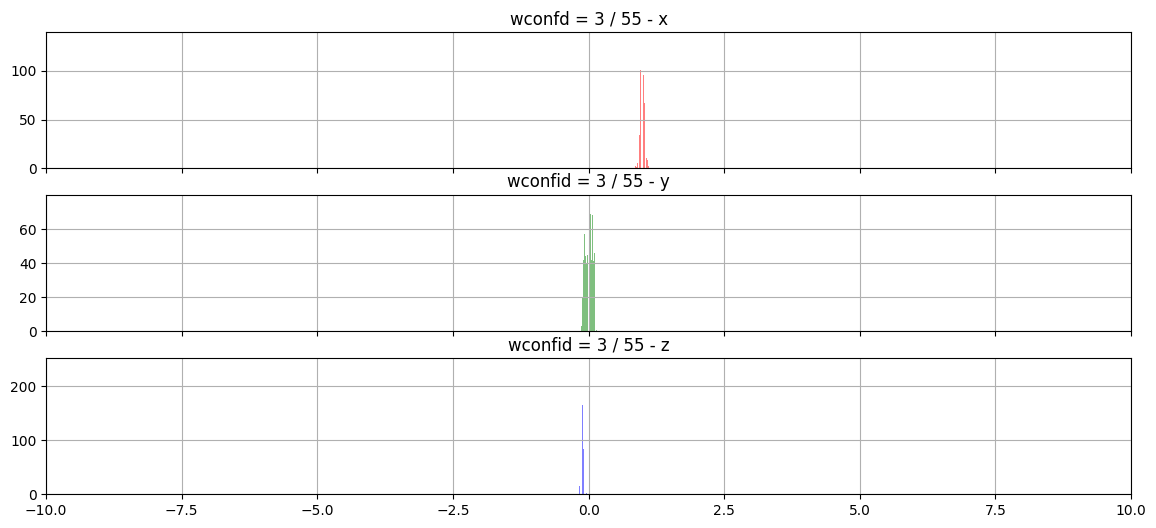

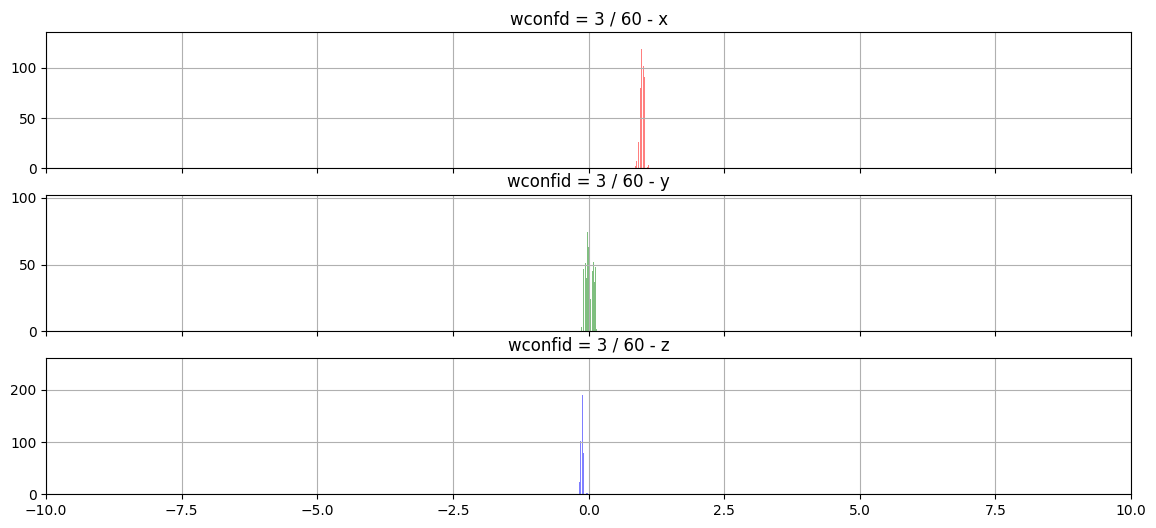

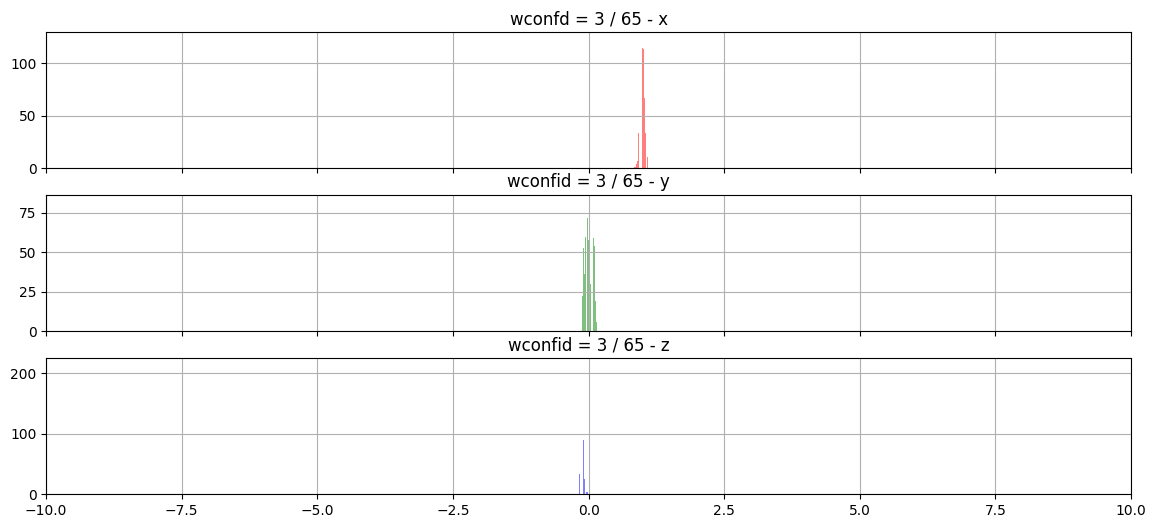

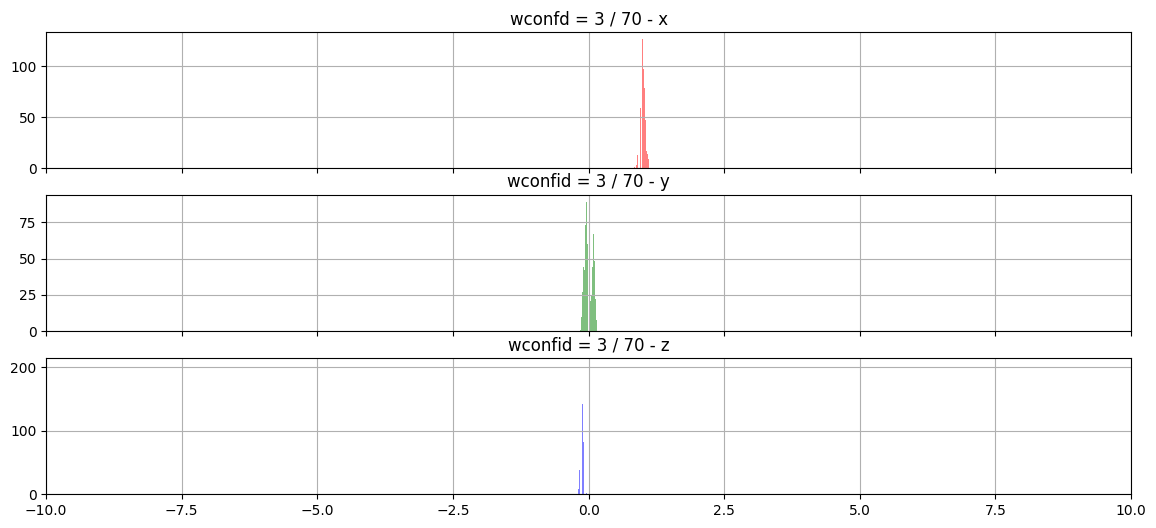

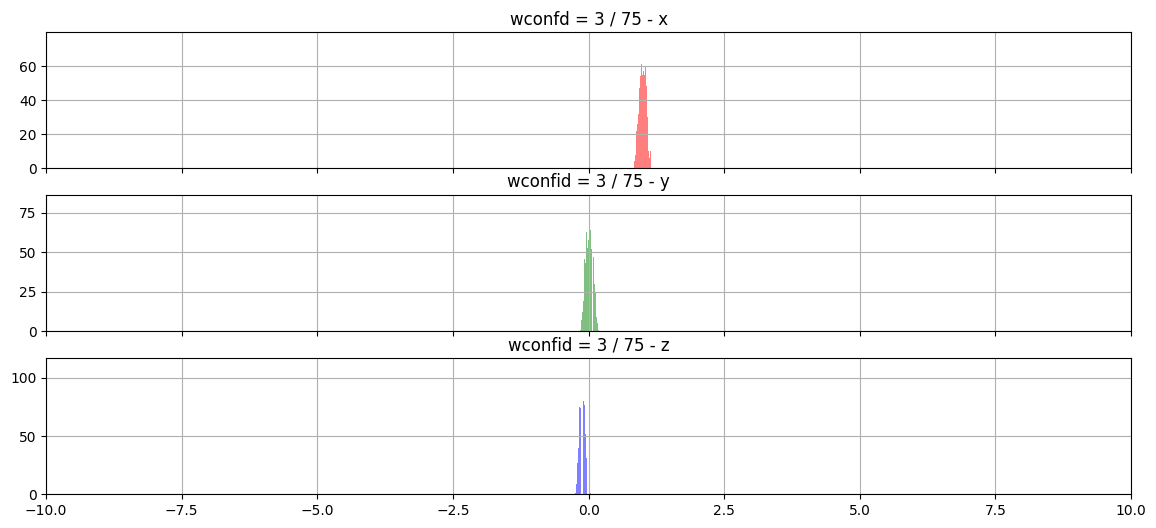

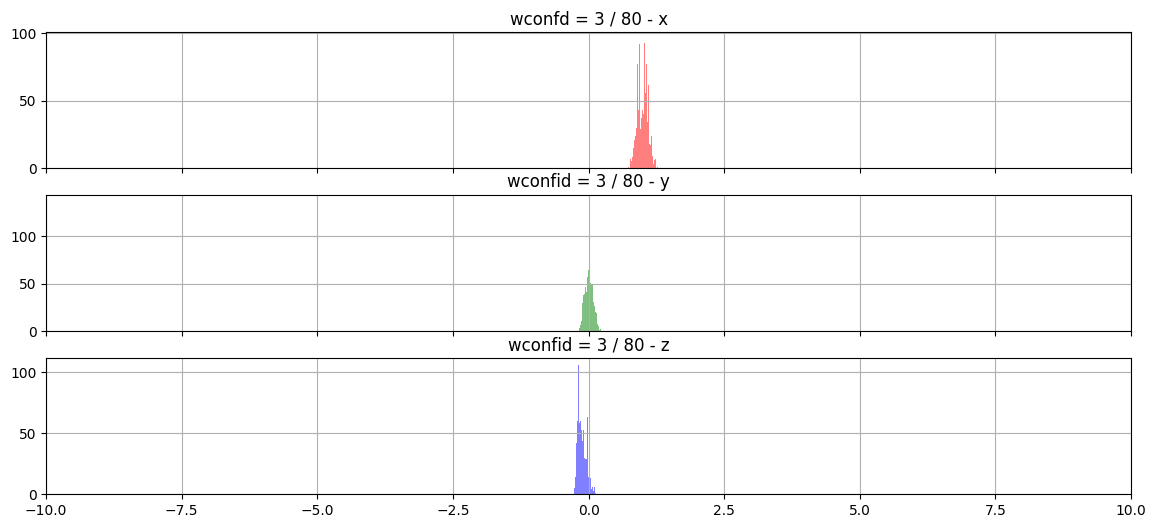

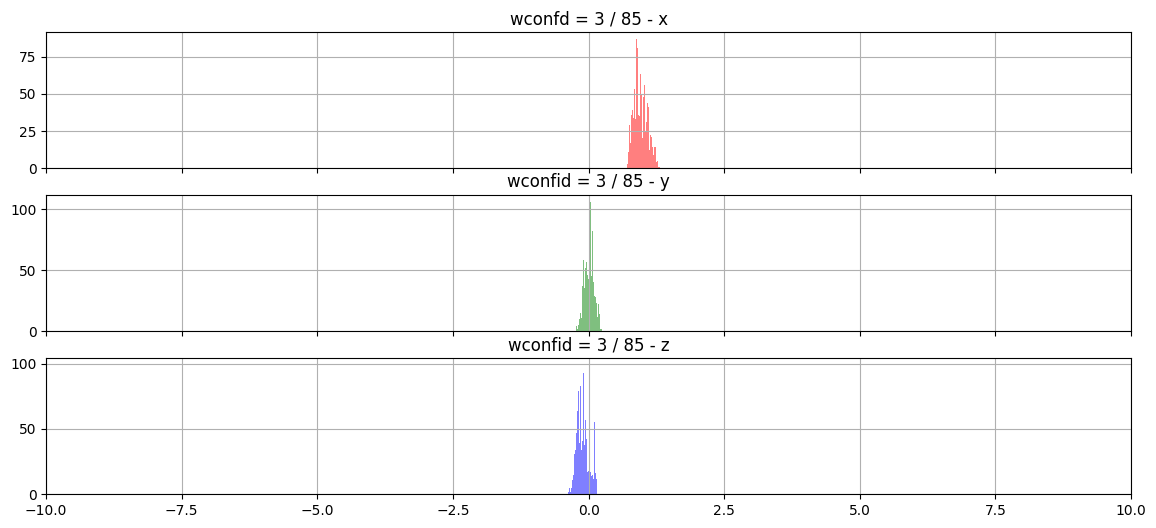

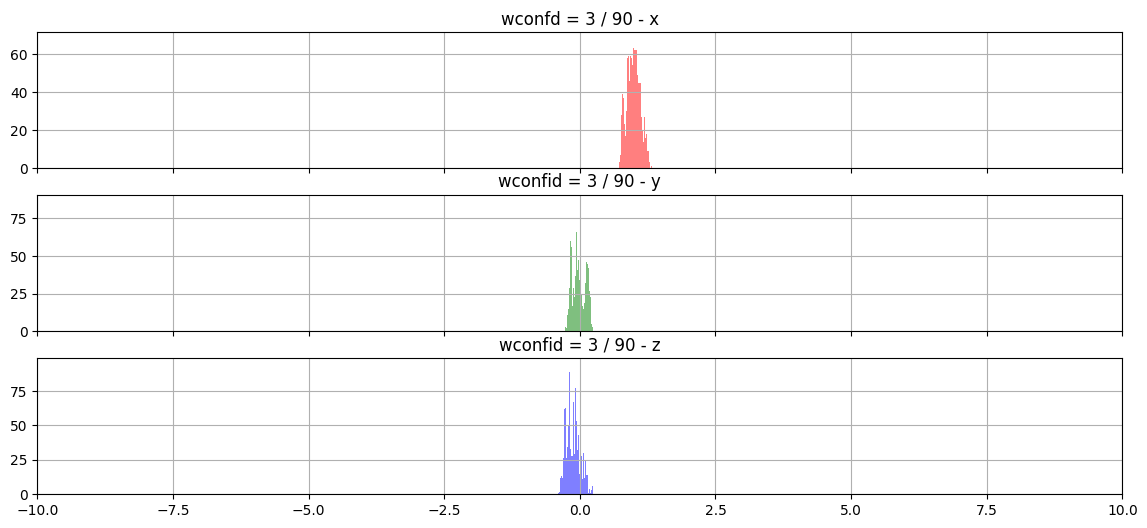

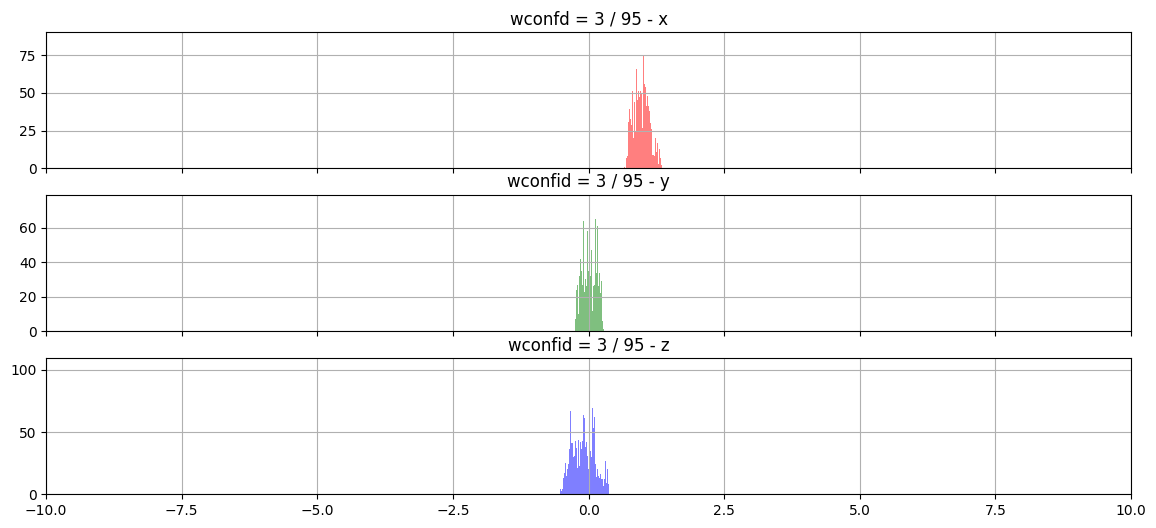

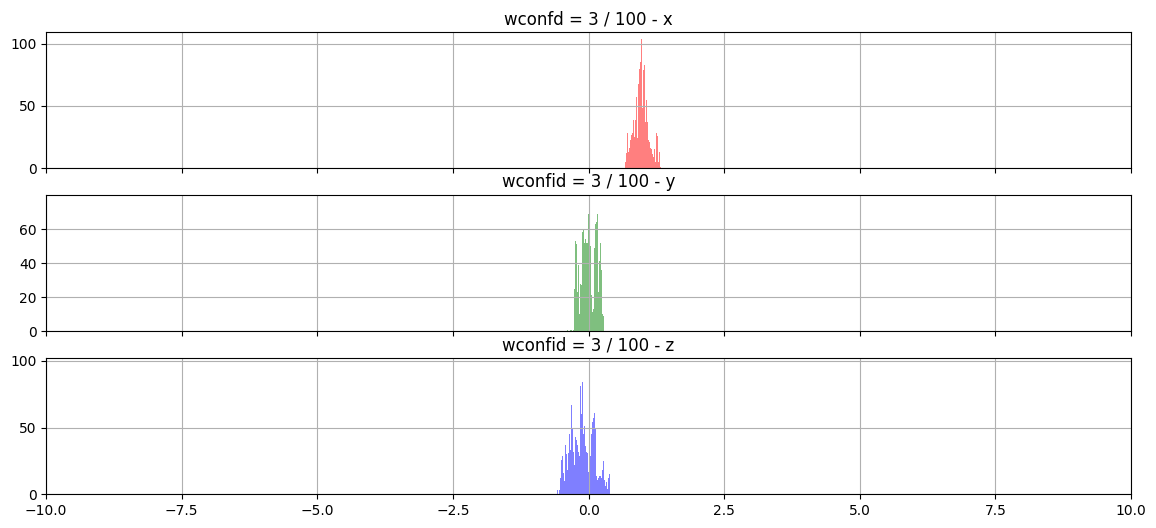

In [ ]:
# distribution plots
choice_confid = 1
n_bins = 100


while choice_confid <= 3:
    for act in speeds:
        df_temp = df[df.wconfid==choice_confid].loc[df.pctid==act].copy()
        df_temp.reset_index(inplace=True)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,6), sharex=True)

        ax1.hist(df_temp['x'], bins=n_bins, color='red', alpha=0.5)
        ax1.set_xlim(-10,10)
        ax1.set_title('wconfd = ' + str(choice_confid) + ' / ' + str(act) + ' - x')
        ax1.grid()

        ax2.hist(df_temp['y'], bins=n_bins, color='green', alpha=0.5)
        ax2.set_xlim(-10,10)
        ax2.set_title('wconfid = ' + str(choice_confid) + ' / ' + str(act) + ' - y')
        ax2.grid()

        ax3.hist(df_temp['z'], bins=n_bins, color='blue', alpha=0.5)
        ax3.set_xlim(-10,10)
        ax3.set_title('wconfid = ' + str(choice_confid) + ' / ' + str(act) + ' - z')
        ax3.grid()

        plt.show()
    choice_confid += 1

# pairwise scatter plots
for speed in speeds:
    df_temp = df[df.wconfid==choice_confid].loc[df.pctid==speed].copy()
    df_temp.reset_index(inplace=True)
    
    # convert time to seconds and start with 0
    t_min = df_temp.timestamp.min()
    df_temp['time_sec'] = (df_temp['timestamp'] - t_min)/1e9
    
    print(act,':')
    sns.pairplot(data = df_temp[['x','y','z']],
                 plot_kws = dict(s=2))
    plt.show()

1


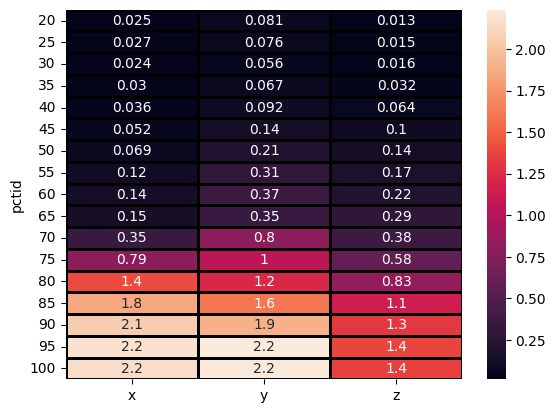

2


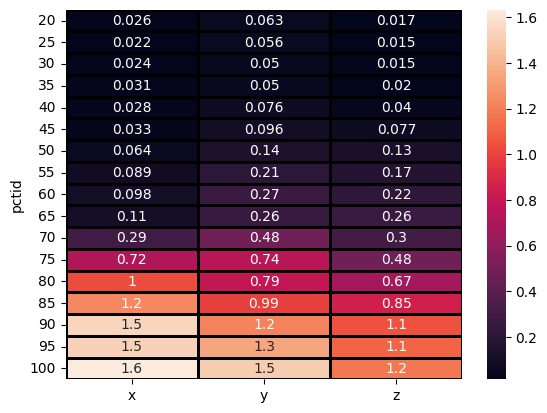

3


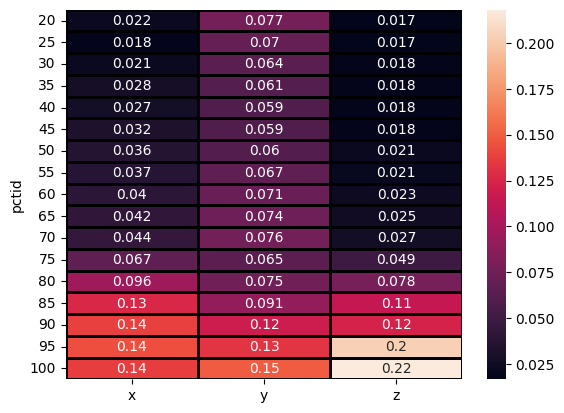

In [ ]:
i = 1

while i < 4:
    stats_by_speed = df[df.wconfid==i].groupby('pctid')[['x','y','z']].std()
    # print(stats_by_speed)
    print(i)
    i += 1
    sns.heatmap(stats_by_speed, annot=True, linewidths=1, linecolor='black')
    plt.show()


In [ ]:
df.shape

(153000, 5)

In [ ]:
df.columns[1:]

Index(['pctid', 'x', 'y', 'z'], dtype='object')

In [ ]:
df.columns[2:]

Index(['x', 'y', 'z'], dtype='object')

In [ ]:
windows_size = fs * window + 1
df_segments =  pd.DataFrame()
for speeds in df.pctid.unique():
    sub_segments = pd.DataFrame()
    # Extract the Speed classes for each created window
    tmp_class = df[df.pctid==speeds]['wconfid'].values
    tmp_class = tmp_class[0:int(len(tmp_class)/windows_size)*windows_size].reshape((int(len(tmp_class)/windows_size),windows_size))
    tmp_class = pd.DataFrame(tmp_class).mode(axis=1)

    for col_id in df.columns[2:]:
        # Create list with columns names
        columns = []
        for i in range(0,windows_size):
            columns.append(col_id + "-" + str(i))
        # Segment data for each column ofthe raw data
        tmp_vals = df[df.pctid==speeds][col_id].values
        tmp_vals = tmp_vals[0:int(len(tmp_vals)/windows_size)*windows_size].reshape((int(len(tmp_vals)/windows_size),windows_size))
        tmp_vals = pd.DataFrame(tmp_vals)
        tmp_vals.columns = columns

        sub_segments = pd.concat([sub_segments,tmp_vals],axis=1)

    sub_segments['wconfid'] = tmp_class
    sub_segments['pctid'] = speeds
    df_segments = pd.concat([df_segments,sub_segments],axis=0)

df_segments = df_segments.reset_index(drop=True)
display(df_segments)

x-0   x-1   x-2   x-3   x-4   x-5   x-6   x-7   x-8   x-9  ...  z-13  \
0     1.00  1.00  0.97  0.97  1.00  0.96  0.97  1.00  0.97  0.97  ... -0.13   
1     1.01  1.00  0.99  0.96  0.99  0.99  0.97  1.03  0.98  0.98  ... -0.13   
2     0.98  1.02  0.98  0.98  1.02  0.99  1.00  1.00  1.00  0.96  ... -0.11   
3     0.99  0.97  1.00  0.98  1.03  1.00  0.97  0.96  0.99  0.98  ... -0.15   
4     1.02  1.00  1.02  1.00  0.97  1.03  0.98  0.97  1.03  0.99  ... -0.12   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7271  1.08  0.86  1.18  0.88  0.99  0.90  1.05  1.23  0.97  1.02  ... -0.22   
7272  0.89  0.87  0.81  1.03  0.79  0.93  0.97  1.25  1.00  0.68  ... -0.12   
7273  1.06  1.02  0.85  1.20  0.90  1.01  0.86  1.08  1.27  0.95  ...  0.26   
7274  0.75  0.96  1.21  0.84  1.07  0.69  1.02  0.90  0.94  0.97  ... -0.16   
7275  1.02  1.01  1.07  1.03  0.77  1.03  1.05  1.24  0.93  0.91  ... -0.32   

      z-14  z-15  z-16  z-17  z-18  z-19  z-20  wconfid  pctid  
0    -0.15 -0.12 -0.12 -0.14 -0.12 -0.12 -0.15        1     20  
1    -0.13 -0.16 -0.12 -0.12 -0.12 -0.12 -0.15        1     20  
2    -0.12 -0.13 -0.12 -0.12 -0.16 -0.14 -0.12        1     20  
3    -0.14 -0.13 -0.14 -0.13 -0.11 -0.15 -0.13        1     20  
4    -0.10 -0.12 -0.12 -0.12 -0.12 -0.16 -0.12        1     20  
...    ...   ...   ...   ...   ...   ...   ...      ...    ...  
7271  0.11  0.06 -0.26  0.07 -0.38 -0.21  0.09        3    100  
7272  0.06 -0.48 -0.12 -0.12 -0.31  0.28 -0.49        3    100  
7273 -0.44  0.02 -0.13 -0.28 -0.04 -0.50  0.09        3    100  
7274 -0.07 -0.12 -0.38  0.28 -0.09 -0.22  0.09        3    100  
7275  0.28 -0.46  0.03 -0.14 -0.27 -0.02 -0.51        3    100  

[7276 rows x 65 columns]

In [ ]:
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7276 entries, 0 to 7275
Data columns (total 65 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x-0      7276 non-null   float64
 1   x-1      7276 non-null   float64
 2   x-2      7276 non-null   float64
 3   x-3      7276 non-null   float64
 4   x-4      7276 non-null   float64
 5   x-5      7276 non-null   float64
 6   x-6      7276 non-null   float64
 7   x-7      7276 non-null   float64
 8   x-8      7276 non-null   float64
 9   x-9      7276 non-null   float64
 10  x-10     7276 non-null   float64
 11  x-11     7276 non-null   float64
 12  x-12     7276 non-null   float64
 13  x-13     7276 non-null   float64
 14  x-14     7276 non-null   float64
 15  x-15     7276 non-null   float64
 16  x-16     7276 non-null   float64
 17  x-17     7276 non-null   float64
 18  x-18     7276 non-null   float64
 19  x-19     7276 non-null   float64
 20  x-20     7276 non-null   float64
 21  y-0      7276 

In [ ]:
whos

Variable               Type                     Data/Info
---------------------------------------------------------
CHUNK_SIZE             int                      40960
DATA_SOURCE_MAPPING    str                      accelerometer-data-set:ht<...>c0d30c32a4206cca57d048033
HTTPError              type                     <class 'urllib.error.HTTPError'>
KAGGLE_INPUT_PATH      str                      /kaggle/input
KAGGLE_SYMLINK         str                      kaggle
KAGGLE_WORKING_PATH    str                      /kaggle/working
NamedTemporaryFile     function                 <function NamedTemporaryFile at 0x7da1004a7130>
ZipFile                type                     <class 'zipfile.ZipFile'>
act                    int                      100
ax                     Axes                     Axes(0.125,0.11;0.62x0.77)
ax1                    Axes                     Axes(0.125,0.653529;0.775x0.226471)
ax2                    Axes                     Axes(0.125,0.381765;0.775x0.226471)

In [ ]:
!pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00


In [ ]:
import tsfel

In [ ]:
FEATURES = True
SAVE_FEATURES = True

In [ ]:
if FEATURES:
    # Python3 program to Convert a list to dictionary
    def Convert(lst):
        res_dct = {lst[i]: i for i in range(0, len(lst))}
        return res_dct

    # Driver code
    res_dct = Convert(df.pctid.unique())
    res_dct

In [ ]:
if FEATURES:
    t1 = time.time()
    # Retrieves a pre-defined feature configuration file to extract all available features
    # Available domains: "statistical"; "spectral"; "temporal"
    cfg_file = tsfel.get_features_by_domain()

    df_features =  []
    for speeds in df.pctid.unique():
        # Extract the Speed classes for each created window
        tmp_class = df[df.pctid==speeds]['wconfid'].values
        tmp_class = tmp_class[0:int(len(tmp_class)/windows_size)*windows_size].reshape((int(len(tmp_class)/windows_size),windows_size))
        tmp_class = pd.DataFrame(tmp_class).mode(axis=1)

        # Extract features
        tmp_features = tsfel.time_series_features_extractor(cfg_file, df[df.pctid==speeds].iloc[0:,3:], fs = fs, window_size=windows_size, header_names = df.columns[3:].values, n_jobs = -1)

        tmp_features['wconfid'] = tmp_class
        tmp_features['pctid'] = speeds
        df_features.append(tmp_features)

    df_features = pd.concat(df_features,axis=0)
    t2 = time.time()
    print('Elapsed time [s]:', np.round(t2-t1,4))

    del speeds, tmp_class, t1, t2, tmp_features

    display(df_features.head(5))
    display(df_features.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Elapsed time [s]: 338.8927


y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
0               0.11                    0.04                1.0   
1               0.15                    0.04                1.0   
2               0.10                    0.03                1.0   
3               0.15                    0.05                1.0   
4               0.12                    0.04                1.0   

   y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
0             0.11        0.58                        4.0   
1             0.15        0.50                        4.0   
2             0.10        0.48                        4.0   
3             0.15        0.53                        4.0   
4             0.12        0.46                        4.0   

   y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                       16.0                -0.09                 0.06   
1                       16.0                -0.13                 0.06   
2                       16.0                -0.05                 0.08   
3                       16.0                -0.09                 0.05   
4                       16.0                -0.08                 0.08   

   y_ECDF_0  ...  z_Wavelet variance_2  z_Wavelet variance_3  \
0      0.05  ...              1.17e-03              1.12e-03   
1      0.05  ...              1.26e-03              1.36e-03   
2      0.05  ...              2.48e-03              2.30e-03   
3      0.05  ...              1.88e-03              1.82e-03   
4      0.05  ...              1.41e-03              1.26e-03   

   z_Wavelet variance_4  z_Wavelet variance_5  z_Wavelet variance_6  \
0              1.46e-03              2.16e-03              2.97e-03   
1              1.53e-03              2.14e-03              2.97e-03   
2              1.71e-03              1.65e-03              2.08e-03   
3              1.68e-03              2.03e-03              2.74e-03   
4              1.41e-03              1.93e-03              2.64e-03   

   z_Wavelet variance_7  z_Wavelet variance_8  z_Zero crossing rate  wconfid  \
0              3.70e-03              4.27e-03                   0.0        1   
1              3.76e-03              4.39e-03                   0.0        1   
2              2.70e-03              3.30e-03                   0.0        1   
3              3.50e-03              4.15e-03                   0.0        1   
4              3.33e-03              3.89e-03                   0.0        1   

   pctid  
0     20  
1     20  
2     20  
3     20  
4     20  

[5 rows x 290 columns]

(7276, 290)

In [ ]:
from sklearn import preprocessing

In [ ]:
df_features

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
0                 0.11                    0.04                1.0   
1                 0.15                    0.04                1.0   
2                 0.10                    0.03                1.0   
3                 0.15                    0.05                1.0   
4                 0.12                    0.04                1.0   
..                 ...                     ...                ...   
423               0.67                    0.05                1.0   
424               0.28                    0.04                1.0   
425               0.65                    0.05                1.0   
426               0.49                    0.05                1.0   
427               0.45                    0.04                1.0   

     y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
0               0.11        0.58                        4.0   
1               0.15        0.50                        4.0   
2               0.10        0.48                        4.0   
3               0.15        0.53                        4.0   
4               0.12        0.46                        4.0   
..               ...         ...                        ...   
423             0.67        0.47                        4.0   
424             0.28        0.48                        4.0   
425             0.65        0.48                        4.0   
426             0.49        0.38                        4.0   
427             0.45        0.59                        4.0   

     y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         16.0                -0.09                 0.06   
1                         16.0                -0.13                 0.06   
2                         16.0                -0.05                 0.08   
3                         16.0                -0.09                 0.05   
4                         16.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                       16.0                -0.22                 0.19   
424                       16.0                -0.11                 0.13   
425                       16.0                -0.25                 0.19   
426                       16.0                -0.12                 0.12   
427                       16.0                -0.14                 0.15   

     y_ECDF_0  ...  z_Wavelet variance_2  z_Wavelet variance_3  \
0        0.05  ...              1.17e-03              1.12e-03   
1        0.05  ...              1.26e-03              1.36e-03   
2        0.05  ...              2.48e-03              2.30e-03   
3        0.05  ...              1.88e-03              1.82e-03   
4        0.05  ...              1.41e-03              1.26e-03   
..        ...  ...                   ...                   ...   
423      0.05  ...              1.33e-02              1.11e-02   
424      0.05  ...              5.93e-03              9.83e-03   
425      0.05  ...              7.24e-03              2.74e-03   
426      0.05  ...              5.67e-03              2.15e-03   
427      0.05  ...              5.44e-03              2.80e-03   

     z_Wavelet variance_4  z_Wavelet variance_5  z_Wavelet variance_6  \
0                1.46e-03              2.16e-03              2.97e-03   
1                1.53e-03              2.14e-03              2.97e-03   
2                1.71e-03              1.65e-03              2.08e-03   
3                1.68e-03              2.03e-03              2.74e-03   
4                1.41e-03              1.93e-03              2.64e-03   
..                    ...                   ...                   ...   
423              9.08e-03              7.43e-03              6.28e-03   
424              1.16e-02              1.15e-02              1.08e-02   
425              4.34e-03              6.51e-03         

In [ ]:
df_features.columns[:-2]

Index(['y_Absolute energy', 'y_Area under the curve', 'y_Autocorrelation',
       'y_Average power', 'y_Centroid', 'y_ECDF Percentile Count_0',
       'y_ECDF Percentile Count_1', 'y_ECDF Percentile_0',
       'y_ECDF Percentile_1', 'y_ECDF_0',
       ...
       'z_Wavelet variance_0', 'z_Wavelet variance_1', 'z_Wavelet variance_2',
       'z_Wavelet variance_3', 'z_Wavelet variance_4', 'z_Wavelet variance_5',
       'z_Wavelet variance_6', 'z_Wavelet variance_7', 'z_Wavelet variance_8',
       'z_Zero crossing rate'],
      dtype='object', length=288)

In [ ]:
corr_df = pd.DataFrame(columns=df_features.columns[:-1])
corr_df['pctid']=""
corr_df['pctid'] = df_features['pctid'].unique()
corr_df.set_index('pctid',inplace=True)
corr_df = corr_df.sort_index()
corr_df

y_Absolute energy y_Area under the curve y_Autocorrelation  \
pctid                                                              
20                  NaN                    NaN               NaN   
25                  NaN                    NaN               NaN   
30                  NaN                    NaN               NaN   
35                  NaN                    NaN               NaN   
40                  NaN                    NaN               NaN   
45                  NaN                    NaN               NaN   
50                  NaN                    NaN               NaN   
55                  NaN                    NaN               NaN   
60                  NaN                    NaN               NaN   
65                  NaN                    NaN               NaN   
70                  NaN                    NaN               NaN   
75                  NaN                    NaN               NaN   
80                  NaN                    NaN               NaN   
85                  NaN                    NaN               NaN   
90                  NaN                    NaN               NaN   
95                  NaN                    NaN               NaN   
100                 NaN                    NaN               NaN   

      y_Average power y_Centroid y_ECDF Percentile Count_0  \
pctid                                                        
20                NaN        NaN                       NaN   
25                NaN        NaN                       NaN   
30                NaN        NaN                       NaN   
35                NaN        NaN                       NaN   
40                NaN        NaN                       NaN   
45                NaN        NaN                       NaN   
50                NaN        NaN                       NaN   
55                NaN        NaN                       NaN   
60                NaN        NaN                       NaN   
65                NaN        NaN                       NaN   
70                NaN        NaN                       NaN   
75                NaN        NaN                       NaN   
80                NaN        NaN                       NaN   
85                NaN        NaN                       NaN   
90                NaN        NaN                       NaN   
95                NaN        NaN                       NaN   
100               NaN        NaN                       NaN   

      y_ECDF Percentile Count_1 y_ECDF Percentile_0 y_ECDF Percentile_1  \
pctid                                                                     
20                          NaN                 NaN                 NaN   
25                          NaN                 NaN                 NaN   
30                          NaN                 NaN                 NaN   
35                          NaN                 NaN                 NaN   
40                          NaN                 NaN                 NaN   
45                          NaN                 NaN                 NaN   
50                          NaN                 NaN                 NaN   
55                          NaN                 NaN                 NaN   
60                          NaN                 NaN                 NaN   
65                          NaN                 NaN                 NaN   
70                          NaN                 NaN                 NaN   
75                          NaN                 NaN                 NaN   
80                          NaN                 NaN                 NaN   
85                          NaN                 NaN                 NaN   
90                          NaN                 NaN                 NaN   
95                          NaN                 NaN                 NaN   
100                         NaN                 NaN                 NaN   

      y_ECDF_0  ... z_Wavelet variance_1 z_Wavelet variance_2  \
pctid           ...                        

In [ ]:
df_features.iloc[0:,0:-1]

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
0                 0.11                    0.04                1.0   
1                 0.15                    0.04                1.0   
2                 0.10                    0.03                1.0   
3                 0.15                    0.05                1.0   
4                 0.12                    0.04                1.0   
..                 ...                     ...                ...   
423               0.67                    0.05                1.0   
424               0.28                    0.04                1.0   
425               0.65                    0.05                1.0   
426               0.49                    0.05                1.0   
427               0.45                    0.04                1.0   

     y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
0               0.11        0.58                        4.0   
1               0.15        0.50                        4.0   
2               0.10        0.48                        4.0   
3               0.15        0.53                        4.0   
4               0.12        0.46                        4.0   
..               ...         ...                        ...   
423             0.67        0.47                        4.0   
424             0.28        0.48                        4.0   
425             0.65        0.48                        4.0   
426             0.49        0.38                        4.0   
427             0.45        0.59                        4.0   

     y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         16.0                -0.09                 0.06   
1                         16.0                -0.13                 0.06   
2                         16.0                -0.05                 0.08   
3                         16.0                -0.09                 0.05   
4                         16.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                       16.0                -0.22                 0.19   
424                       16.0                -0.11                 0.13   
425                       16.0                -0.25                 0.19   
426                       16.0                -0.12                 0.12   
427                       16.0                -0.14                 0.15   

     y_ECDF_0  ...  z_Wavelet variance_1  z_Wavelet variance_2  \
0        0.05  ...              1.21e-03              1.17e-03   
1        0.05  ...              9.92e-04              1.26e-03   
2        0.05  ...              1.69e-03              2.48e-03   
3        0.05  ...              1.25e-03              1.88e-03   
4        0.05  ...              1.48e-03              1.41e-03   
..        ...  ...                   ...                   ...   
423      0.05  ...              1.38e-02              1.33e-02   
424      0.05  ...              7.18e-03              5.93e-03   
425      0.05  ...              1.30e-02              7.24e-03   
426      0.05  ...              1.74e-02              5.67e-03   
427      0.05  ...              9.96e-03              5.44e-03   

     z_Wavelet variance_3  z_Wavelet variance_4  z_Wavelet variance_5  \
0                1.12e-03              1.46e-03              2.16e-03   
1                1.36e-03              1.53e-03              2.14e-03   
2                2.30e-03              1.71e-03              1.65e-03   
3                1.82e-03              1.68e-03              2.03e-03   
4                1.26e-03              1.41e-03              1.93e-03   
..                    ...                   ...                   ...   
423              1.11e-02              9.08e-03              7.43e-03   
424              9.83e-03              1.16e-02              1.15e-02   
425              2.74e-03              4.34e-03         

In [ ]:
df_features.iloc[0:,0:-1]

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
0                 0.11                    0.04                1.0   
1                 0.15                    0.04                1.0   
2                 0.10                    0.03                1.0   
3                 0.15                    0.05                1.0   
4                 0.12                    0.04                1.0   
..                 ...                     ...                ...   
423               0.67                    0.05                1.0   
424               0.28                    0.04                1.0   
425               0.65                    0.05                1.0   
426               0.49                    0.05                1.0   
427               0.45                    0.04                1.0   

     y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
0               0.11        0.58                        4.0   
1               0.15        0.50                        4.0   
2               0.10        0.48                        4.0   
3               0.15        0.53                        4.0   
4               0.12        0.46                        4.0   
..               ...         ...                        ...   
423             0.67        0.47                        4.0   
424             0.28        0.48                        4.0   
425             0.65        0.48                        4.0   
426             0.49        0.38                        4.0   
427             0.45        0.59                        4.0   

     y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         16.0                -0.09                 0.06   
1                         16.0                -0.13                 0.06   
2                         16.0                -0.05                 0.08   
3                         16.0                -0.09                 0.05   
4                         16.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                       16.0                -0.22                 0.19   
424                       16.0                -0.11                 0.13   
425                       16.0                -0.25                 0.19   
426                       16.0                -0.12                 0.12   
427                       16.0                -0.14                 0.15   

     y_ECDF_0  ...  z_Wavelet variance_1  z_Wavelet variance_2  \
0        0.05  ...              1.21e-03              1.17e-03   
1        0.05  ...              9.92e-04              1.26e-03   
2        0.05  ...              1.69e-03              2.48e-03   
3        0.05  ...              1.25e-03              1.88e-03   
4        0.05  ...              1.48e-03              1.41e-03   
..        ...  ...                   ...                   ...   
423      0.05  ...              1.38e-02              1.33e-02   
424      0.05  ...              7.18e-03              5.93e-03   
425      0.05  ...              1.30e-02              7.24e-03   
426      0.05  ...              1.74e-02              5.67e-03   
427      0.05  ...              9.96e-03              5.44e-03   

     z_Wavelet variance_3  z_Wavelet variance_4  z_Wavelet variance_5  \
0                1.12e-03              1.46e-03              2.16e-03   
1                1.36e-03              1.53e-03              2.14e-03   
2                2.30e-03              1.71e-03              1.65e-03   
3                1.82e-03              1.68e-03              2.03e-03   
4                1.26e-03              1.41e-03              1.93e-03   
..                    ...                   ...                   ...   
423              1.11e-02              9.08e-03              7.43e-03   
424              9.83e-03              1.16e-02              1.15e-02   
425              2.74e-03              4.34e-03         

In [ ]:
df_features

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
0                 0.11                    0.04                1.0   
1                 0.15                    0.04                1.0   
2                 0.10                    0.03                1.0   
3                 0.15                    0.05                1.0   
4                 0.12                    0.04                1.0   
..                 ...                     ...                ...   
423               0.67                    0.05                1.0   
424               0.28                    0.04                1.0   
425               0.65                    0.05                1.0   
426               0.49                    0.05                1.0   
427               0.45                    0.04                1.0   

     y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
0               0.11        0.58                        4.0   
1               0.15        0.50                        4.0   
2               0.10        0.48                        4.0   
3               0.15        0.53                        4.0   
4               0.12        0.46                        4.0   
..               ...         ...                        ...   
423             0.67        0.47                        4.0   
424             0.28        0.48                        4.0   
425             0.65        0.48                        4.0   
426             0.49        0.38                        4.0   
427             0.45        0.59                        4.0   

     y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         16.0                -0.09                 0.06   
1                         16.0                -0.13                 0.06   
2                         16.0                -0.05                 0.08   
3                         16.0                -0.09                 0.05   
4                         16.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                       16.0                -0.22                 0.19   
424                       16.0                -0.11                 0.13   
425                       16.0                -0.25                 0.19   
426                       16.0                -0.12                 0.12   
427                       16.0                -0.14                 0.15   

     y_ECDF_0  ...  z_Wavelet variance_2  z_Wavelet variance_3  \
0        0.05  ...              1.17e-03              1.12e-03   
1        0.05  ...              1.26e-03              1.36e-03   
2        0.05  ...              2.48e-03              2.30e-03   
3        0.05  ...              1.88e-03              1.82e-03   
4        0.05  ...              1.41e-03              1.26e-03   
..        ...  ...                   ...                   ...   
423      0.05  ...              1.33e-02              1.11e-02   
424      0.05  ...              5.93e-03              9.83e-03   
425      0.05  ...              7.24e-03              2.74e-03   
426      0.05  ...              5.67e-03              2.15e-03   
427      0.05  ...              5.44e-03              2.80e-03   

     z_Wavelet variance_4  z_Wavelet variance_5  z_Wavelet variance_6  \
0                1.46e-03              2.16e-03              2.97e-03   
1                1.53e-03              2.14e-03              2.97e-03   
2                1.71e-03              1.65e-03              2.08e-03   
3                1.68e-03              2.03e-03              2.74e-03   
4                1.41e-03              1.93e-03              2.64e-03   
..                    ...                   ...                   ...   
423              9.08e-03              7.43e-03              6.28e-03   
424              1.16e-02              1.15e-02              1.08e-02   
425              4.34e-03              6.51e-03         

In [ ]:
for speeds in df_features.pctid.unique():
    tmp_speed = df_features.iloc[0:,0:-1]
    tmp_speed = df_features[df_features.pctid==speeds]
    corr_features = tsfel.correlated_features(tmp_speed)
    corr_df.loc[speeds][corr_features] = 1

corr_df = corr_df.fillna(0)
corr_df

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
pctid                                                                 
20                     0                       0                  0   
25                     0                       0                  0   
30                     0                       0                  0   
35                     0                       0                  0   
40                     0                       0                  0   
45                     0                       1                  0   
50                     0                       0                  0   
55                     0                       0                  0   
60                     0                       1                  0   
65                     0                       0                  0   
70                     0                       0                  0   
75                     0                       0                  0   
80                     0                       0                  0   
85                     0                       0                  0   
90                     0                       0                  0   
95                     0                       1                  0   
100                    0                       1                  0   

       y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
pctid                                                           
20                   1           0                          0   
25                   1           0                          0   
30                   1           0                          0   
35                   1           0                          0   
40                   1           0                          0   
45                   1           0                          0   
50                   1           0                          0   
55                   1           0                          0   
60                   1           0                          0   
65                   1           0                          0   
70                   1           0                          0   
75                   1           0                          0   
80                   1           0                          0   
85                   1           0                          0   
90                   1           0                          0   
95                   1           0                          0   
100                  1           0                          0   

       y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
pctid                                                                        
20                             0                    0                    0   
25                             0                    0                    0   
30                             1                    0                    0   
35                             0                    0                    0   
40                             0                    0                    0   
45                             1                    0                    0   
50                             1                    0                    0   
55                             1                    0                    0   
60                             1                    0                    0   
65                             1                    0                    0   
70                             1                    0                    0   
75                             0                    0                    0   
80                             0                    0                    0   
85                             0                    0                    0   
90                             0                    0                    0   
95                             0                    0                    0   
100              

In [ ]:
corr_df = corr_df.drop('wconfid', axis=1)
corr_df

y_Absolute energy  y_Area under the curve  y_Autocorrelation  \
pctid                                                                 
20                     0                       0                  0   
25                     0                       0                  0   
30                     0                       0                  0   
35                     0                       0                  0   
40                     0                       0                  0   
45                     0                       1                  0   
50                     0                       0                  0   
55                     0                       0                  0   
60                     0                       1                  0   
65                     0                       0                  0   
70                     0                       0                  0   
75                     0                       0                  0   
80                     0                       0                  0   
85                     0                       0                  0   
90                     0                       0                  0   
95                     0                       1                  0   
100                    0                       1                  0   

       y_Average power  y_Centroid  y_ECDF Percentile Count_0  \
pctid                                                           
20                   1           0                          0   
25                   1           0                          0   
30                   1           0                          0   
35                   1           0                          0   
40                   1           0                          0   
45                   1           0                          0   
50                   1           0                          0   
55                   1           0                          0   
60                   1           0                          0   
65                   1           0                          0   
70                   1           0                          0   
75                   1           0                          0   
80                   1           0                          0   
85                   1           0                          0   
90                   1           0                          0   
95                   1           0                          0   
100                  1           0                          0   

       y_ECDF Percentile Count_1  y_ECDF Percentile_0  y_ECDF Percentile_1  \
pctid                                                                        
20                             0                    0                    0   
25                             0                    0                    0   
30                             1                    0                    0   
35                             0                    0                    0   
40                             0                    0                    0   
45                             1                    0                    0   
50                             1                    0                    0   
55                             1                    0                    0   
60                             1                    0                    0   
65                             1                    0                    0   
70                             1                    0                    0   
75                             0                    0                    0   
80                             0                    0                    0   
85                             0                    0                    0   
90                             0                    0                    0   
95                             0                    0                    0   
100              

In [ ]:
to_drop = corr_df.columns[corr_df.sum()>0]
print(len(to_drop),to_drop)
df_features = df_features.drop(to_drop,axis=1)
df_features

126 Index(['y_Area under the curve', 'y_Average power',
       'y_ECDF Percentile Count_1', 'y_FFT mean coefficient_4',
       'y_Histogram_5', 'y_LPCC_11', 'y_LPCC_2', 'y_LPCC_7', 'y_LPCC_8',
       'y_LPCC_9',
       ...
       'z_Wavelet variance_0', 'z_Wavelet variance_1', 'z_Wavelet variance_2',
       'z_Wavelet variance_3', 'z_Wavelet variance_4', 'z_Wavelet variance_5',
       'z_Wavelet variance_6', 'z_Wavelet variance_7', 'z_Wavelet variance_8',
       'z_Zero crossing rate'],
      dtype='object', length=126)


y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 0.11                1.0        0.58   
1                 0.15                1.0        0.50   
2                 0.10                1.0        0.48   
3                 0.15                1.0        0.53   
4                 0.12                1.0        0.46   
..                 ...                ...         ...   
423               0.67                1.0        0.47   
424               0.28                1.0        0.48   
425               0.65                1.0        0.48   
426               0.49                1.0        0.38   
427               0.45                1.0        0.59   

     y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          4.0                -0.09                 0.06   
1                          4.0                -0.13                 0.06   
2                          4.0                -0.05                 0.08   
3                          4.0                -0.09                 0.05   
4                          4.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                        4.0                -0.22                 0.19   
424                        4.0                -0.11                 0.13   
425                        4.0                -0.25                 0.19   
426                        4.0                -0.12                 0.12   
427                        4.0                -0.14                 0.15   

     y_ECDF_0  y_ECDF_1  y_ECDF_2  y_ECDF_3  ...  z_Spectral entropy  \
0        0.05       0.1      0.14      0.19  ...                0.75   
1        0.05       0.1      0.14      0.19  ...                0.69   
2        0.05       0.1      0.14      0.19  ...                0.82   
3        0.05       0.1      0.14      0.19  ...                0.72   
4        0.05       0.1      0.14      0.19  ...                0.82   
..        ...       ...       ...       ...  ...                 ...   
423      0.05       0.1      0.14      0.19  ...                0.61   
424      0.05       0.1      0.14      0.19  ...                0.55   
425      0.05       0.1      0.14      0.19  ...                0.65   
426      0.05       0.1      0.14      0.19  ...                0.57   
427      0.05       0.1      0.14      0.19  ...                0.54   

     z_Spectral positive turning points  z_Spectral roll-on  \
0                                   2.0                 0.0   
1                                   2.0                 0.0   
2                                   3.0                 0.0   
3                                   3.0                 0.0   
4                                   2.0                 0.0   
..                                  ...                 ...   
423                                 4.0                 0.0   
424                                 2.0                 0.0   
425                                 3.0                 0.0   
426                                 3.0                 0.0   
427                                 2.0                 0.0   

     z_Spectral variation  z_Wavelet absolute mean_0  \
0                    0.68                   9.46e-03   
1                    0.79                   1.01e-02   
2                    0.63                   1.02e-02   
3                    0.84                   1.11e-02   
4                    0.76                   1.07e-02   
..                    ...                        ...   
423                  0.35                   1.87e-02   
424                  0.44                   3.15e-03   
425                  0.37                   1.80e-02   
426                  0.41                   1.03e-02   
427                  0.53                   1.15e-02   

     z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  z_Wavelet energy_2  \
0                         0.03 

In [ ]:
to_drop = df_features.columns[df_features.std()==0]
print(len(to_drop),to_drop)
df_features = df_features.drop(to_drop,axis=1)
df_features

10 Index(['y_ECDF_0', 'y_ECDF_1', 'y_ECDF_3', 'y_ECDF_6', 'y_ECDF_7', 'z_ECDF_0',
       'z_ECDF_1', 'z_ECDF_3', 'z_ECDF_6', 'z_ECDF_7'],
      dtype='object')


y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 0.11                1.0        0.58   
1                 0.15                1.0        0.50   
2                 0.10                1.0        0.48   
3                 0.15                1.0        0.53   
4                 0.12                1.0        0.46   
..                 ...                ...         ...   
423               0.67                1.0        0.47   
424               0.28                1.0        0.48   
425               0.65                1.0        0.48   
426               0.49                1.0        0.38   
427               0.45                1.0        0.59   

     y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          4.0                -0.09                 0.06   
1                          4.0                -0.13                 0.06   
2                          4.0                -0.05                 0.08   
3                          4.0                -0.09                 0.05   
4                          4.0                -0.08                 0.08   
..                         ...                  ...                  ...   
423                        4.0                -0.22                 0.19   
424                        4.0                -0.11                 0.13   
425                        4.0                -0.25                 0.19   
426                        4.0                -0.12                 0.12   
427                        4.0                -0.14                 0.15   

     y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0        0.14      0.24      0.29      0.43  ...                0.75   
1        0.14      0.24      0.29      0.43  ...                0.69   
2        0.14      0.24      0.29      0.43  ...                0.82   
3        0.14      0.24      0.29      0.43  ...                0.72   
4        0.14      0.24      0.29      0.43  ...                0.82   
..        ...       ...       ...       ...  ...                 ...   
423      0.14      0.24      0.29      0.43  ...                0.61   
424      0.14      0.24      0.29      0.43  ...                0.55   
425      0.14      0.24      0.29      0.43  ...                0.65   
426      0.14      0.24      0.29      0.43  ...                0.57   
427      0.14      0.24      0.29      0.43  ...                0.54   

     z_Spectral positive turning points  z_Spectral roll-on  \
0                                   2.0                 0.0   
1                                   2.0                 0.0   
2                                   3.0                 0.0   
3                                   3.0                 0.0   
4                                   2.0                 0.0   
..                                  ...                 ...   
423                                 4.0                 0.0   
424                                 2.0                 0.0   
425                                 3.0                 0.0   
426                                 3.0                 0.0   
427                                 2.0                 0.0   

     z_Spectral variation  z_Wavelet absolute mean_0  \
0                    0.68                   9.46e-03   
1                    0.79                   1.01e-02   
2                    0.63                   1.02e-02   
3                    0.84                   1.11e-02   
4                    0.76                   1.07e-02   
..                    ...                        ...   
423                  0.35                   1.87e-02   
424                  0.44                   3.15e-03   
425                  0.37                   1.80e-02   
426                  0.41                   1.03e-02   
427                  0.53                   1.15e-02   

     z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  z_Wavelet energy_2  \
0                         0.03 

In [ ]:
features_columns = df_features.columns.values

# Normalising Features
scaler = preprocessing.StandardScaler()
df_features.iloc[0:,0:-2] = pd.DataFrame(scaler.fit_transform(df_features.iloc[0:,0:-2]))

df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                -0.42              -0.04        0.94   
1                -0.42              -0.04        0.07   
2                -0.42              -0.04       -0.22   
3                -0.42              -0.04        0.42   
4                -0.42              -0.04       -0.44   
..                 ...                ...         ...   
423              -0.40              -0.04       -0.33   
424              -0.41              -0.04       -0.18   
425              -0.40              -0.04       -0.17   
426              -0.41              -0.04       -1.43   
427              -0.41              -0.04        1.13   

     y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         0.04                 0.48                -0.58   
1                         0.04                 0.41                -0.57   
2                         0.04                 0.56                -0.52   
3                         0.04                 0.48                -0.60   
4                         0.04                 0.51                -0.52   
..                         ...                  ...                  ...   
423                       0.04                 0.23                -0.19   
424                       0.04                 0.44                -0.36   
425                       0.04                 0.17                -0.19   
426                       0.04                 0.41                -0.38   
427                       0.04                 0.38                -0.31   

     y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
..        ...       ...       ...       ...  ...                 ...   
423  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
424  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
425  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
426  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
427  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

     z_Spectral positive turning points  z_Spectral roll-on  \
0                                 -0.81               -0.29   
1                                 -0.81               -0.29   
2                                  0.54               -0.29   
3                                  0.54               -0.29   
4                                 -0.81               -0.29   
..                                  ...                 ...   
423                                1.88               -0.29   
424                               -0.81               -0.29   
425                                0.54               -0.29   
426                                0.54               -0.29   
427                               -0.81               -0.29   

     z_Spectral variation  z_Wavelet absolute mean_0  \
0                6.96e-01                      -0.34   
1                1.23e+00                      -0.30   
2                4.68e-01                      -0.30   
3                1.43e+00                      -0.24   
4                1.08e+00                      -0.27   
..                    ...                        ...   
423             -8.24e-01                       0.22   
424             -4.24e-01                      -0.72   
425             -7.16e-01                       0.17   
426             -5.66e-01                      -0.29   
427             -6.94e-03                      -0.21   

     z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  z_Wavelet energy_2  \
0                        -0.22 

In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                -0.42              -0.04        0.94   
1                -0.42              -0.04        0.07   
2                -0.42              -0.04       -0.22   
3                -0.42              -0.04        0.42   
4                -0.42              -0.04       -0.44   
..                 ...                ...         ...   
423              -0.40              -0.04       -0.33   
424              -0.41              -0.04       -0.18   
425              -0.40              -0.04       -0.17   
426              -0.41              -0.04       -1.43   
427              -0.41              -0.04        1.13   

     y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         0.04                 0.48                -0.58   
1                         0.04                 0.41                -0.57   
2                         0.04                 0.56                -0.52   
3                         0.04                 0.48                -0.60   
4                         0.04                 0.51                -0.52   
..                         ...                  ...                  ...   
423                       0.04                 0.23                -0.19   
424                       0.04                 0.44                -0.36   
425                       0.04                 0.17                -0.19   
426                       0.04                 0.41                -0.38   
427                       0.04                 0.38                -0.31   

     y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
..        ...       ...       ...       ...  ...                 ...   
423  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
424  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
425  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
426  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
427  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

     z_Spectral positive turning points  z_Spectral roll-on  \
0                                 -0.81               -0.29   
1                                 -0.81               -0.29   
2                                  0.54               -0.29   
3                                  0.54               -0.29   
4                                 -0.81               -0.29   
..                                  ...                 ...   
423                                1.88               -0.29   
424                               -0.81               -0.29   
425                                0.54               -0.29   
426                                0.54               -0.29   
427                               -0.81               -0.29   

     z_Spectral variation  z_Wavelet absolute mean_0  \
0                6.96e-01                      -0.34   
1                1.23e+00                      -0.30   
2                4.68e-01                      -0.30   
3                1.43e+00                      -0.24   
4                1.08e+00                      -0.27   
..                    ...                        ...   
423             -8.24e-01                       0.22   
424             -4.24e-01                      -0.72   
425             -7.16e-01                       0.17   
426             -5.66e-01                      -0.29   
427             -6.94e-03                      -0.21   

     z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  z_Wavelet energy_2  \
0                        -0.22 

In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7276 entries, 0 to 427
Columns: 154 entries, y_Absolute energy to pctid
dtypes: float64(152), int64(2)
memory usage: 8.6 MB


In [ ]:
if SAVE_FEATURES:
    df_features.to_csv('/kaggle/working/har_feturesv2.csv',index=False)

In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
df_features.describe().round(2)

y_Absolute energy  y_Autocorrelation  y_Centroid  \
count            7276.00            7276.00     7276.00   
mean                0.00               0.00        0.00   
std                 1.00               1.00        1.00   
min                -0.42              -0.04       -4.33   
25%                -0.42              -0.04       -0.60   
50%                -0.41              -0.04        0.02   
75%                -0.16              -0.04        0.60   
max                 7.18              53.36        4.43   

       y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
count                    7276.00              7276.00              7276.00   
mean                        0.00                -0.00                -0.00   
std                         1.00                 1.00                 1.00   
min                       -24.96               -10.16                -1.44   
25%                         0.04                 0.03                -0.57   
50%                         0.04                 0.45                -0.46   
75%                         0.04                 0.53                 0.15   
max                         0.04                 0.95                 6.89   

       y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
count    7276.0    7276.0    7276.0    7276.0  ...             7276.00   
mean        0.0      -0.0       0.0      -0.0  ...                0.00   
std         0.0       0.0       0.0       0.0  ...                1.00   
min         0.0      -0.0       0.0      -0.0  ...               -3.74   
25%         0.0      -0.0       0.0      -0.0  ...               -0.64   
50%         0.0      -0.0       0.0      -0.0  ...                0.24   
75%         0.0      -0.0       0.0      -0.0  ...                0.79   
max         0.0      -0.0       0.0      -0.0  ...                1.88   

       z_Spectral positive turning points  z_Spectral roll-on  \
count                             7276.00             7276.00   
mean                                -0.00                0.00   
std                                  1.00                1.00   
min                                 -2.15               -0.29   
25%                                 -0.81               -0.29   
50%                                  0.54               -0.29   
75%                                  0.54               -0.29   
max                                  3.23                6.30   

       z_Spectral variation  z_Wavelet absolute mean_0  \
count               7276.00                    7276.00   
mean                  -0.00                       0.00   
std                    1.00                       1.00   
min                   -2.26                      -0.91   
25%                   -0.78                      -0.39   
50%                    0.11                      -0.31   
75%                    0.82                      -0.06   
max                    2.04                      11.09   

       z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  \
count                    7276.00                    7276.00   
mean                        0.00                      -0.00   
std                         1.00                       1.00   
min                        -1.25                      -1.51   
25%                        -0.33                      -0.30   
50%                        -0.22                      -0.18   
75%                        -0.09                      -0.08   
max                        10.32                      11.56   

       z_Wavelet energy_2  wconfid   pctid  
count             7276.00  7276.00  7276.0  
mean                 0.00     2.00    60.0  
std                  1.00     0.82    24.5  
min                 -0.63     1.00    20.0  
25%                 -0.51     1.00    40.0  
50%                 -0.47     2.00    60.0  
75%                 -0.13     3.00    80.0  
max                  8.69     3.00   100.0  

[8 rows x 154 columns]

In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                -0.42              -0.04        0.94   
1                -0.42              -0.04        0.07   
2                -0.42              -0.04       -0.22   
3                -0.42              -0.04        0.42   
4                -0.42              -0.04       -0.44   
..                 ...                ...         ...   
423              -0.40              -0.04       -0.33   
424              -0.41              -0.04       -0.18   
425              -0.40              -0.04       -0.17   
426              -0.41              -0.04       -1.43   
427              -0.41              -0.04        1.13   

     y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                         0.04                 0.48                -0.58   
1                         0.04                 0.41                -0.57   
2                         0.04                 0.56                -0.52   
3                         0.04                 0.48                -0.60   
4                         0.04                 0.51                -0.52   
..                         ...                  ...                  ...   
423                       0.04                 0.23                -0.19   
424                       0.04                 0.44                -0.36   
425                       0.04                 0.17                -0.19   
426                       0.04                 0.41                -0.38   
427                       0.04                 0.38                -0.31   

     y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
..        ...       ...       ...       ...  ...                 ...   
423  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
424  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
425  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
426  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
427  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

     z_Spectral positive turning points  z_Spectral roll-on  \
0                                 -0.81               -0.29   
1                                 -0.81               -0.29   
2                                  0.54               -0.29   
3                                  0.54               -0.29   
4                                 -0.81               -0.29   
..                                  ...                 ...   
423                                1.88               -0.29   
424                               -0.81               -0.29   
425                                0.54               -0.29   
426                                0.54               -0.29   
427                               -0.81               -0.29   

     z_Spectral variation  z_Wavelet absolute mean_0  \
0                6.96e-01                      -0.34   
1                1.23e+00                      -0.30   
2                4.68e-01                      -0.30   
3                1.43e+00                      -0.24   
4                1.08e+00                      -0.27   
..                    ...                        ...   
423             -8.24e-01                       0.22   
424             -4.24e-01                      -0.72   
425             -7.16e-01                       0.17   
426             -5.66e-01                      -0.29   
427             -6.94e-03                      -0.21   

     z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  z_Wavelet energy_2  \
0                        -0.22 

In [ ]:
# df_features = df_features[~df_features.index.duplicated()]

In [ ]:
df_features.reset_index(drop=True, inplace=True)

In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 -0.42              -0.04        0.94   
1                 -0.42              -0.04        0.07   
2                 -0.42              -0.04       -0.22   
3                 -0.42              -0.04        0.42   
4                 -0.42              -0.04       -0.44   
...                 ...                ...         ...   
7271              -0.40              -0.04       -0.33   
7272              -0.41              -0.04       -0.18   
7273              -0.40              -0.04       -0.17   
7274              -0.41              -0.04       -1.43   
7275              -0.41              -0.04        1.13   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                 0.48                -0.58   
1                          0.04                 0.41                -0.57   
2                          0.04                 0.56                -0.52   
3                          0.04                 0.48                -0.60   
4                          0.04                 0.51                -0.52   
...                         ...                  ...                  ...   
7271                       0.04                 0.23                -0.19   
7272                       0.04                 0.44                -0.36   
7273                       0.04                 0.17                -0.19   
7274                       0.04                 0.41                -0.38   
7275                       0.04                 0.38                -0.31   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
...        ...       ...       ...       ...  ...                 ...   
7271  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
7272  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
7273  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
7274  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
7275  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                  -0.81               -0.29   
1                                  -0.81               -0.29   
2                                   0.54               -0.29   
3                                   0.54               -0.29   
4                                  -0.81               -0.29   
...                                  ...                 ...   
7271                                1.88               -0.29   
7272                               -0.81               -0.29   
7273                                0.54               -0.29   
7274                                0.54               -0.29   
7275                               -0.81               -0.29   

      z_Spectral variation  z_Wavelet absolute mean_0  \
0                 6.96e-01                      -0.34   
1                 1.23e+00                      -0.30   
2                 4.68e-01                      -0.30   
3                 1.43e+00                      -0.24   
4                 1.08e+00                      -0.27   
...                    ...                        ...   
7271             -8.24e-01                       0.22   
7272             -4.24e-01                      -0.72   
7273             -7.16e-01                       0.17   
7274             -5.66e-01                      -0.29   
7275             -6.94e-03                      -0.21   

      z_Wavelet absolute mean_1  z_Wavelet absolute m

In [ ]:
print(df_features.index)

RangeIndex(start=0, stop=7276, step=1)


In [ ]:
print(df_features.index.duplicated())

[False False False ... False False False]


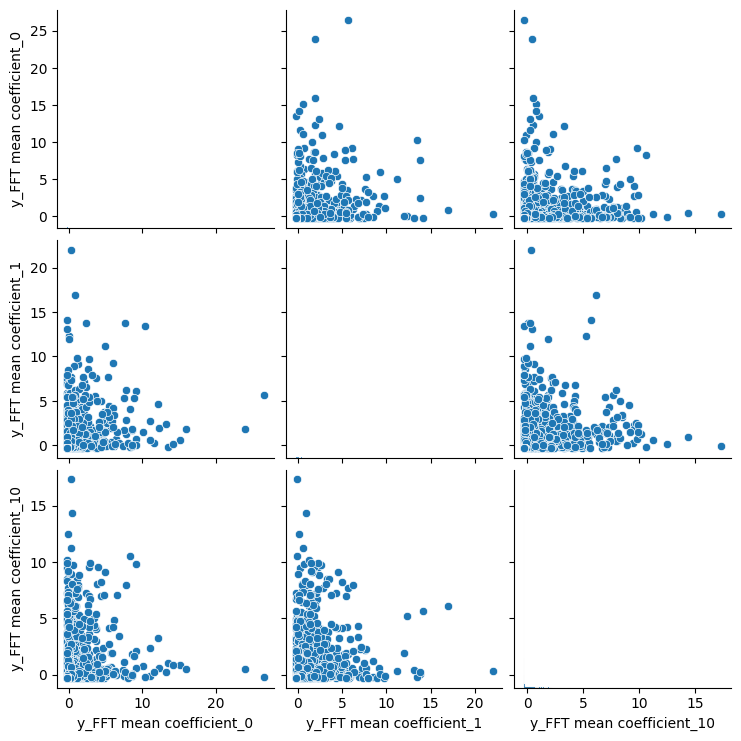

In [ ]:
df_features = df_features.loc[:,~df_features.columns.duplicated()]
df_features = df_features.loc[~df_features.index.duplicated(), :]
sns.pairplot(df_features.iloc[0:,12:15])

In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 -0.42              -0.04        0.94   
1                 -0.42              -0.04        0.07   
2                 -0.42              -0.04       -0.22   
3                 -0.42              -0.04        0.42   
4                 -0.42              -0.04       -0.44   
...                 ...                ...         ...   
7271              -0.40              -0.04       -0.33   
7272              -0.41              -0.04       -0.18   
7273              -0.40              -0.04       -0.17   
7274              -0.41              -0.04       -1.43   
7275              -0.41              -0.04        1.13   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                 0.48                -0.58   
1                          0.04                 0.41                -0.57   
2                          0.04                 0.56                -0.52   
3                          0.04                 0.48                -0.60   
4                          0.04                 0.51                -0.52   
...                         ...                  ...                  ...   
7271                       0.04                 0.23                -0.19   
7272                       0.04                 0.44                -0.36   
7273                       0.04                 0.17                -0.19   
7274                       0.04                 0.41                -0.38   
7275                       0.04                 0.38                -0.31   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
...        ...       ...       ...       ...  ...                 ...   
7271  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
7272  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
7273  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
7274  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
7275  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                  -0.81               -0.29   
1                                  -0.81               -0.29   
2                                   0.54               -0.29   
3                                   0.54               -0.29   
4                                  -0.81               -0.29   
...                                  ...                 ...   
7271                                1.88               -0.29   
7272                               -0.81               -0.29   
7273                                0.54               -0.29   
7274                                0.54               -0.29   
7275                               -0.81               -0.29   

      z_Spectral variation  z_Wavelet absolute mean_0  \
0                 6.96e-01                      -0.34   
1                 1.23e+00                      -0.30   
2                 4.68e-01                      -0.30   
3                 1.43e+00                      -0.24   
4                 1.08e+00                      -0.27   
...                    ...                        ...   
7271             -8.24e-01                       0.22   
7272             -4.24e-01                      -0.72   
7273             -7.16e-01                       0.17   
7274             -5.66e-01                      -0.29   
7275             -6.94e-03                      -0.21   

      z_Wavelet absolute mean_1  z_Wavelet absolute m

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(df_features)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 -0.42              -0.04        0.94   
1                 -0.42              -0.04        0.07   
2                 -0.42              -0.04       -0.22   
3                 -0.42              -0.04        0.42   
4                 -0.42              -0.04       -0.44   
...                 ...                ...         ...   
7271              -0.40              -0.04       -0.33   
7272              -0.41              -0.04       -0.18   
7273              -0.40              -0.04       -0.17   
7274              -0.41              -0.04       -1.43   
7275              -0.41              -0.04        1.13   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                 0.48                -0.58   
1                          0.04                 0.41                -0.57   
2                          0.04                 0.56                -0.52   
3                          0.04                 0.48                -0.60   
4                          0.04                 0.51                -0.52   
...                         ...                  ...                  ...   
7271                       0.04                 0.23                -0.19   
7272                       0.04                 0.44                -0.36   
7273                       0.04                 0.17                -0.19   
7274                       0.04                 0.41                -0.38   
7275                       0.04                 0.38                -0.31   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
...        ...       ...       ...       ...  ...                 ...   
7271  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
7272  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
7273  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
7274  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
7275  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                  -0.81               -0.29   
1                                  -0.81               -0.29   
2                                   0.54               -0.29   
3                                   0.54               -0.29   
4                                  -0.81               -0.29   
...                                  ...                 ...   
7271                                1.88               -0.29   
7272                               -0.81               -0.29   
7273                                0.54               -0.29   
7274                                0.54               -0.29   
7275                               -0.81               -0.29   

      z_Spectral variation  z_Wavelet absolute mean_0  \
0                 6.96e-01                      -0.34   
1                 1.23e+00                      -0.30   
2                 4.68e-01                      -0.30   
3                 1.43e+00                      -0.24   
4                 1.08e+00                      -0.27   
...                    ...                        ...   
7271             -8.24e-01                       0.22   
7272             -4.24e-01                      -0.72   
7273             -7.16e-01                       0.17   
7274             -5.66e-01                      -0.29   
7275             -6.94e-03                      -0.21   

      z_Wavelet absolute mean_1  z_Wavelet absolute m

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df_features)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}", f"  Train size: index={len(train_index)}")
    print(f"  Test:  index={test_index}", f"  Train size: index={len(test_index)}")

Fold 0:
  Train: index=[ 728  729  730 ... 7273 7274 7275]   Train size: index=6548
  Test:  index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 

In [ ]:
features_names = df_features.columns[0:-1].values
targets_names = df_features.columns[-1:].values

confids = df_features['wconfid'].unique()

print(features_names)
print(targets_names)

['y_Absolute energy' 'y_Autocorrelation' 'y_Centroid'
 'y_ECDF Percentile Count_0' 'y_ECDF Percentile_0' 'y_ECDF Percentile_1'
 'y_ECDF_2' 'y_ECDF_4' 'y_ECDF_5' 'y_ECDF_8' 'y_ECDF_9' 'y_Entropy'
 'y_FFT mean coefficient_0' 'y_FFT mean coefficient_1'
 'y_FFT mean coefficient_10' 'y_FFT mean coefficient_2'
 'y_FFT mean coefficient_3' 'y_FFT mean coefficient_5'
 'y_FFT mean coefficient_6' 'y_FFT mean coefficient_7'
 'y_FFT mean coefficient_8' 'y_FFT mean coefficient_9'
 'y_Fundamental frequency' 'y_Histogram_0' 'y_Histogram_1' 'y_Histogram_2'
 'y_Histogram_3' 'y_Histogram_4' 'y_Histogram_6' 'y_Histogram_7'
 'y_Histogram_8' 'y_Histogram_9' 'y_Human range energy'
 'y_Interquartile range' 'y_Kurtosis' 'y_LPCC_0' 'y_LPCC_1' 'y_LPCC_10'
 'y_LPCC_3' 'y_LPCC_4' 'y_LPCC_5' 'y_LPCC_6' 'y_MFCC_0' 'y_MFCC_1'
 'y_MFCC_10' 'y_MFCC_11' 'y_MFCC_2' 'y_MFCC_3' 'y_MFCC_4' 'y_MFCC_5'
 'y_MFCC_6' 'y_MFCC_7' 'y_MFCC_8' 'y_MFCC_9' 'y_Max'
 'y_Max power spectrum' 'y_Maximum frequency' 'y_Mean' 'y_Mean diff'
 'y

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df_features

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 -0.42              -0.04        0.94   
1                 -0.42              -0.04        0.07   
2                 -0.42              -0.04       -0.22   
3                 -0.42              -0.04        0.42   
4                 -0.42              -0.04       -0.44   
...                 ...                ...         ...   
7271              -0.40              -0.04       -0.33   
7272              -0.41              -0.04       -0.18   
7273              -0.40              -0.04       -0.17   
7274              -0.41              -0.04       -1.43   
7275              -0.41              -0.04        1.13   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                 0.48                -0.58   
1                          0.04                 0.41                -0.57   
2                          0.04                 0.56                -0.52   
3                          0.04                 0.48                -0.60   
4                          0.04                 0.51                -0.52   
...                         ...                  ...                  ...   
7271                       0.04                 0.23                -0.19   
7272                       0.04                 0.44                -0.36   
7273                       0.04                 0.17                -0.19   
7274                       0.04                 0.41                -0.38   
7275                       0.04                 0.38                -0.31   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral entropy  \
0     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.48   
1     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.15   
2     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.94   
3     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.33   
4     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                0.90   
...        ...       ...       ...       ...  ...                 ...   
7271  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.36   
7272  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.72   
7273  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.08   
7274  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.55   
7275  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...               -0.78   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                  -0.81               -0.29   
1                                  -0.81               -0.29   
2                                   0.54               -0.29   
3                                   0.54               -0.29   
4                                  -0.81               -0.29   
...                                  ...                 ...   
7271                                1.88               -0.29   
7272                               -0.81               -0.29   
7273                                0.54               -0.29   
7274                                0.54               -0.29   
7275                               -0.81               -0.29   

      z_Spectral variation  z_Wavelet absolute mean_0  \
0                 6.96e-01                      -0.34   
1                 1.23e+00                      -0.30   
2                 4.68e-01                      -0.30   
3                 1.43e+00                      -0.24   
4                 1.08e+00                      -0.27   
...                    ...                        ...   
7271             -8.24e-01                       0.22   
7272             -4.24e-01                      -0.72   
7273             -7.16e-01                       0.17   
7274             -5.66e-01                      -0.29   
7275             -6.94e-03                      -0.21   

      z_Wavelet absolute mean_1  z_Wavelet absolute m

In [ ]:
#print(df_features.iloc[0:,0:-2])
print(df_features['wconfid'])

0       1
1       1
2       1
3       1
4       1
       ..
7271    3
7272    3
7273    3
7274    3
7275    3
Name: wconfid, Length: 7276, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[0:,0:-1], df_features['wconfid'],
                 test_size=0.25, random_state=42)

In [ ]:
y_train

6496    1
5288    2
598     2
75      1
1339    1
       ..
5191    1
5226    1
5390    2
860     1
7270    3
Name: wconfid, Length: 5457, dtype: int64

In [ ]:
y_test

6058    1
5441    3
4475    2
3689    2
4515    2
       ..
5601    1
6263    2
2651    1
6612    2
1553    2
Name: wconfid, Length: 1819, dtype: int64

In [ ]:
#X_train, X_test, y_train, y_test
scaler = StandardScaler()

scaler = scaler.fit(X_train)

# print(scaler.mean_)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train,columns=features_names)

In [ ]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test,columns=features_names)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
to_drop = X_train.columns[X_train.var()<0.16]
print(len(to_drop),to_drop)

10 Index(['y_ECDF_2', 'y_ECDF_4', 'y_ECDF_5', 'y_ECDF_8', 'y_ECDF_9', 'z_ECDF_2',
       'z_ECDF_4', 'z_ECDF_5', 'z_ECDF_8', 'z_ECDF_9'],
      dtype='object')


In [ ]:
X_train = X_train.drop(to_drop,axis=1)

In [ ]:
X_train

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                  4.59              -0.04        0.74   
1                  0.46              -0.04       -2.09   
2                 -0.42              -0.04        1.16   
3                 -0.42              -0.04       -0.04   
4                 -0.42              -0.04       -0.34   
...                 ...                ...         ...   
5452               0.48              -0.04        0.74   
5453               0.53              -0.04       -2.57   
5454              -0.13              -0.04       -1.52   
5455              -0.42              -0.04       -1.11   
5456              -0.41              -0.04        0.90   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                -3.48                 3.19   
1                          0.04                -0.73                 1.11   
2                          0.04                 0.55                -0.64   
3                          0.04                 0.48                -0.48   
4                          0.04                 0.45                -0.71   
...                         ...                  ...                  ...   
5452                       0.04                -1.47                 2.16   
5453                       0.04                -0.44                 1.00   
5454                       0.04                -0.51                 0.38   
5455                       0.04                 0.51                -0.65   
5456                       0.04                 0.35                -0.29   

      y_Entropy  y_FFT mean coefficient_0  y_FFT mean coefficient_1  \
0          1.03                      3.36                      0.09   
1          1.03                     -0.14                      0.15   
2         -0.66                     -0.21                     -0.27   
3          0.03                     -0.22                     -0.28   
4          1.03                     -0.22                     -0.28   
...         ...                       ...                       ...   
5452       0.53                     -0.05                      0.07   
5453       1.03                      0.51                     -0.21   
5454       1.03                      0.13                     -0.21   
5455       1.03                     -0.22                     -0.27   
5456       0.53                     -0.22                     -0.28   

      y_FFT mean coefficient_10  ...  z_Spectral distance  z_Spectral entropy  \
0                     -2.64e-01  ...            -1.32e+00                0.84   
1                     -2.44e-01  ...             7.07e-01                0.82   
2                     -2.77e-01  ...             3.08e-02               -0.82   
3                     -2.75e-01  ...            -3.40e-03                0.79   
4                     -2.77e-01  ...             3.05e-02               -1.08   
...                         ...  ...                  ...                 ...   
5452                   6.99e-02  ...             1.06e+00                0.40   
5453                   1.11e+00  ...            -2.15e+00                1.22   
5454                   7.32e-03  ...            -1.52e-01               -0.44   
5455                  -2.74e-01  ...            -7.23e-02                0.68   
5456                  -2.71e-01  ...             4.83e-01               -0.94   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                   0.54               -0.28   
1                                   1.89                3.15   
2                                  -0.81               -0.28   
3                                   0.54               -0.28   
4                                   0.54               -0.28   
...                                  ...                 ...   
5452                               -0.81               -0.28   
5453                                0.54      

In [ ]:
X_test = X_test.drop(to_drop,axis=1)

In [ ]:
X_test

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                  3.79              -0.04        1.94   
1                 -0.42              -0.04       -0.94   
2                 -0.27              -0.04       -0.61   
3                 -0.37              -0.04       -0.16   
4                 -0.29              -0.04       -0.21   
...                 ...                ...         ...   
1814               3.04              -0.04        0.73   
1815               1.24              -0.04        2.04   
1816              -0.41              -0.04        0.37   
1817               0.67              -0.04        2.50   
1818              -0.42              -0.04        0.89   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                -3.64                 2.91   
1                          0.04                 0.56                -0.54   
2                          0.04                 0.06                -0.08   
3                          0.04                 0.02                -0.29   
4                          0.04                 0.15                 0.05   
...                         ...                  ...                  ...   
1814                       0.04                -1.48                 1.11   
1815                       0.04                -1.84                 1.66   
1816                       0.04                 0.54                -0.44   
1817                       0.04                -0.80                 0.54   
1818                       0.04                 0.53                -0.57   

      y_Entropy  y_FFT mean coefficient_0  y_FFT mean coefficient_1  \
0          1.03                      2.55                      8.88   
1          0.03                     -0.22                     -0.28   
2          0.03                     -0.22                     -0.28   
3          1.03                     -0.21                     -0.26   
4          0.53                     -0.03                     -0.27   
...         ...                       ...                       ...   
1814       1.03                     -0.15                     -0.02   
1815       1.03                      7.00                     -0.04   
1816       0.53                     -0.21                     -0.28   
1817       1.03                     -0.22                      1.02   
1818       0.03                     -0.21                     -0.28   

      y_FFT mean coefficient_10  ...  z_Spectral distance  z_Spectral entropy  \
0                         -0.22  ...                -1.06                0.96   
1                         -0.28  ...                -0.17                0.47   
2                          0.22  ...                 0.21               -1.91   
3                         -0.22  ...                -0.27               -0.69   
4                          0.10  ...                -0.21               -1.29   
...                         ...  ...                  ...                 ...   
1814                       0.42  ...                -0.56                1.03   
1815                       0.39  ...                 2.05                1.17   
1816                      -0.28  ...                -0.37               -0.38   
1817                      -0.28  ...                -0.44               -0.04   
1818                      -0.28  ...                 0.02                0.80   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                   0.54               -0.28   
1                                   0.54               -0.28   
2                                   0.54               -0.28   
3                                   0.54               -0.28   
4                                   0.54               -0.28   
...                                  ...                 ...   
1814                                1.89                3.15   
1815                                1.89      

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_features.iloc[0:,0:-2]

y_Absolute energy  y_Autocorrelation  y_Centroid  \
0                 -0.42              -0.04        0.94   
1                 -0.42              -0.04        0.07   
2                 -0.42              -0.04       -0.22   
3                 -0.42              -0.04        0.42   
4                 -0.42              -0.04       -0.44   
...                 ...                ...         ...   
7271              -0.40              -0.04       -0.33   
7272              -0.41              -0.04       -0.18   
7273              -0.40              -0.04       -0.17   
7274              -0.41              -0.04       -1.43   
7275              -0.41              -0.04        1.13   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
0                          0.04                 0.48                -0.58   
1                          0.04                 0.41                -0.57   
2                          0.04                 0.56                -0.52   
3                          0.04                 0.48                -0.60   
4                          0.04                 0.51                -0.52   
...                         ...                  ...                  ...   
7271                       0.04                 0.23                -0.19   
7272                       0.04                 0.44                -0.36   
7273                       0.04                 0.17                -0.19   
7274                       0.04                 0.41                -0.38   
7275                       0.04                 0.38                -0.31   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Skewness  \
0     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -1.14   
1     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -1.46   
2     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -2.01   
3     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -0.24   
4     2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -1.87   
...        ...       ...       ...       ...  ...         ...   
7271  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...       -0.34   
7272  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...        0.72   
7273  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...        0.12   
7274  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...        0.57   
7275  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...        0.45   

      z_Spectral distance  z_Spectral entropy  \
0                   -0.05                0.48   
1                   -0.10                0.15   
2                   -0.05                0.94   
3                   -0.07                0.33   
4                   -0.04                0.90   
...                   ...                 ...   
7271                 0.76               -0.36   
7272                 0.42               -0.72   
7273                 0.78               -0.08   
7274                 1.03               -0.55   
7275                 0.23               -0.78   

      z_Spectral positive turning points  z_Spectral roll-on  \
0                                  -0.81               -0.29   
1                                  -0.81               -0.29   
2                                   0.54               -0.29   
3                                   0.54               -0.29   
4                                  -0.81               -0.29   
...                                  ...                 ...   
7271                                1.88               -0.29   
7272                               -0.81               -0.29   
7273                                0.54               -0.29   
7274                                0.54               -0.29   
7275                               -0.81               -0.29   

      z_Spectral variation  z_Wavelet absolute mean_0  \
0                 6.96e-01                      -0.34   
1                 1.23e+00                      -0.30   
2                 4.68e-01                      -0.30   
3                

In [ ]:
# Load your dataset and split into X and y
X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[0:,0:-2], df_features['wconfid'],
                 test_size=0.25, random_state=42)


# Train a random forest classifier on the training dataset
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Compute and display feature importances
importances = clf.feature_importances_
features = X_train.columns.values
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
print(feature_importances)


                       feature  importance
0            y_Absolute energy    4.94e-02
1            y_Autocorrelation    1.32e-05
2                   y_Centroid    3.44e-03
3    y_ECDF Percentile Count_0    1.92e-05
4          y_ECDF Percentile_0    2.40e-02
..                         ...         ...
147       z_Spectral variation    6.12e-03
148  z_Wavelet absolute mean_0    3.80e-03
149  z_Wavelet absolute mean_1    8.01e-03
150  z_Wavelet absolute mean_2    1.34e-02
151         z_Wavelet energy_2    7.27e-03

[152 rows x 2 columns]


In [ ]:
importances

array([4.93843259e-02, 1.32492656e-05, 3.44449403e-03, 1.92156857e-05,
       2.39693873e-02, 1.35011583e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.99115726e-03,
       8.69109390e-03, 1.14374920e-02, 1.15795018e-02, 1.03540063e-02,
       2.89949479e-02, 2.18930294e-02, 1.61433403e-02, 5.12322652e-03,
       7.00182542e-03, 2.41661271e-02, 4.08067162e-03, 6.01230006e-04,
       5.99729266e-04, 1.48056244e-03, 3.41510867e-03, 1.17039076e-02,
       1.79430310e-03, 4.08216537e-03, 3.96406542e-04, 4.73333126e-04,
       3.99726310e-03, 1.79921083e-02, 2.44555250e-02, 2.67566760e-03,
       3.52018051e-03, 3.09176613e-03, 2.93325608e-03, 3.27090837e-03,
       3.29302008e-03, 4.08609930e-03, 5.83060225e-03, 5.31414065e-03,
       3.45498955e-03, 3.50483187e-03, 1.22465738e-02, 3.83919545e-03,
       5.52316748e-03, 6.32782411e-03, 3.77248545e-03, 2.99793436e-03,
       3.96611377e-03, 3.09377035e-03, 2.82830908e-02, 7.62599127e-03,
      

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

In [ ]:
clf

ExtraTreesClassifier(n_estimators=50)

In [ ]:
len(clf.feature_importances_)
# pd.DataFrame([X_train.columns.values,clf.feature_importances_],columns=['features','importance'])
features_score = pd.DataFrame(clf.feature_importances_)
features_score.columns = ['score']
features_score['features_name']= X_train.columns.values
features_score = features_score.sort_values('score',ascending=False)
features_score

score              features_name
27    0.02              y_Histogram_4
0     0.02          y_Absolute energy
66    0.02                 y_Skewness
140   0.02  z_Positive turning points
138   0.02  z_Negative turning points
..     ...                        ...
6     0.00                   y_ECDF_2
9     0.00                   y_ECDF_8
8     0.00                   y_ECDF_5
10    0.00                   y_ECDF_9
87    0.00                   z_ECDF_2

[152 rows x 2 columns]

In [ ]:
px.bar(features_score, x='features_name',y='score')

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new_train = model.transform(X_train)
X_new_train.shape


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



(5457, 59)

In [ ]:
X_new_train = X_train[features_score.features_name.iloc[0:84]]

In [ ]:
X_new_train

y_Histogram_4  y_Absolute energy  y_Skewness  z_Positive turning points  \
6496          -1.51               4.56       -1.53                       1.75   
5288          -1.51               0.45       -1.34                      -0.36   
598            0.97              -0.42        0.46                       0.35   
75             0.97              -0.42        0.45                      -0.36   
1339           1.71              -0.42        0.39                      -0.36   
...             ...                ...         ...                        ...   
5191          -1.76               0.48       -0.27                       0.35   
5226          -1.26               0.53        2.17                      -0.36   
5390          -1.76              -0.13       -0.77                      -0.36   
860            1.46              -0.42        0.65                       0.35   
7270           0.22              -0.41       -0.14                       1.05   

      z_Negative turning points  y_Histogram_3  y_Interquartile range  \
6496                       1.72           0.80                   2.24   
5288                      -0.39           0.80                   0.91   
598                        1.02          -0.69                  -0.63   
75                         1.02          -0.69                  -0.52   
1339                      -1.09          -0.69                  -0.63   
...                         ...            ...                    ...   
5191                       0.31          -0.69                   1.63   
5226                       0.31           1.55                   0.73   
5390                      -0.39           0.80                   0.38   
860                       -1.09          -0.69                  -0.58   
7270                       1.72           0.80                  -0.40   

      y_Fundamental frequency  y_ECDF Percentile_0  z_Entropy  ...  y_LPCC_1  \
6496                    -0.28                -3.42       0.95  ...      0.51   
5288                    -0.28                -0.71       0.95  ...     -0.54   
598                     -0.80                 0.55      -1.66  ...     -0.94   
75                       2.32                 0.48      -3.14  ...      0.44   
1339                     0.24                 0.45      -0.38  ...     -0.26   
...                       ...                  ...        ...  ...       ...   
5191                    -0.80                -1.45       0.74  ...     -0.11   
5226                     1.28                -0.43       0.74  ...     -1.12   
5390                     0.76                -0.49       0.95  ...      1.47   
860                     -0.80                 0.51      -1.92  ...     -0.32   
7270                     2.84                 0.35       0.46  ...      2.57   

      z_Wavelet absolute mean_0  z_MFCC_4  z_Max power spectrum  \
6496                       1.54      0.73                 -1.07   
5288                       1.09     -0.65                 -1.21   
598                       -0.30     -0.77                  1.77   
75                        -0.33      0.18                 -1.13   
1339                      -0.29     -0.65                 -0.21   
...                         ...       ...                   ...   
5191                       1.87     -2.03                 -0.16   
5226                       1.62     -1.02                 -0.44   
5390                       0.54     -1.60                  1.14   
860                       -0.32     -0.98                 -0.38   
7270                       0.26      2.50                  1.64   

      z_FFT mean coefficient_6  z_FFT mean coefficient_9  y_MFCC_4  z_Median  \
6496                     -0.08                      5.03 -1.70e-01      1.96   
5288                      0.23                      0.01 -3.18e-01      2.15   
598                      -0.33                     -0.31 -1.48e-01      0.02   
75                       -0.33                     -0.31 -5.67e-01    

In [ ]:
X_new_test = X_test[features_score.features_name.iloc[0:84]]

In [ ]:
fig = px.histogram(pd.DataFrame(y_train,columns=['wconfid']), x='wconfid', title='Data concerning each confid', color="wconfid")
fig.show()
del fig

In [ ]:
y_train.value_counts()

wconfid
2    1838
3    1822
1    1797
Name: count, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_new_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
y_predict = clf.predict(X_new_test)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.76      0.64      0.69       634
           2       0.80      0.47      0.59       593
           3       0.63      1.00      0.77       592

    accuracy                           0.70      1819
   macro avg       0.73      0.70      0.69      1819
weighted avg       0.73      0.70      0.69      1819



In [ ]:
PCA_flag = True

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train

y_Absolute energy  y_Autocorrelation  y_Centroid  \
6496               4.56              -0.04        0.74   
5288               0.45              -0.04       -2.08   
598               -0.42              -0.04        1.16   
75                -0.42              -0.04       -0.03   
1339              -0.42              -0.04       -0.33   
...                 ...                ...         ...   
5191               0.48              -0.04        0.74   
5226               0.53              -0.04       -2.56   
5390              -0.13              -0.04       -1.51   
860               -0.42              -0.04       -1.11   
7270              -0.41              -0.04        0.90   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
6496                       0.04                -3.42                 3.21   
5288                       0.04                -0.71                 1.12   
598                        0.04                 0.55                -0.64   
75                         0.04                 0.48                -0.48   
1339                       0.04                 0.45                -0.71   
...                         ...                  ...                  ...   
5191                       0.04                -1.45                 2.18   
5226                       0.04                -0.43                 1.01   
5390                       0.04                -0.49                 0.38   
860                        0.04                 0.51                -0.65   
7270                       0.04                 0.35                -0.29   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral distance  \
6496  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -1.33   
5288  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.70   
598   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
75    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.01   
1339  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
...        ...       ...       ...       ...  ...                  ...   
5191  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 1.06   
5226  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -2.17   
5390  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.16   
860   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.08   
7270  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.48   

      z_Spectral entropy  z_Spectral positive turning points  \
6496                0.84                                0.54   
5288                0.82                                1.88   
598                -0.82                               -0.81   
75                  0.79                                0.54   
1339               -1.09                                0.54   
...                  ...                                 ...   
5191                0.40                               -0.81   
5226                1.22                                0.54   
5390               -0.44                                0.54   
860                 0.67                                0.54   
7270               -0.95                               -0.81   

      z_Spectral roll-on  z_Spectral variation  z_Wavelet absolute mean_0  \
6496               -0.29                 -1.62                       1.54   
5288                3.01                 -0.90                       1.09   
598                -0.29                  1.72                      -0.30   
75                 -0.29                  1.84                      -0.33   
1339               -0.29                  1.48                      -0.29   
...                  ...                   ...                        ...   
5191               -0.29                 -1.06                       1.87   
5226               -0.29                 -2.26                       1.62   
5390               -0.29         

In [ ]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [ ]:
features_v               = pd.DataFrame()
features_v['Feature']    = train.columns[0:-1]
# features_v['Importance'] = clf.feature_importances_
features_v['Importance'] = importances
features_v               = features_v.sort_values(by=['Importance'], ascending=False)
features_v               = features_v.reset_index()

features_v

index                   Feature  Importance
0        0         y_Absolute energy        0.05
1       16  y_FFT mean coefficient_3        0.03
2       54                     y_Max        0.03
3       82         z_Absolute energy        0.03
4      143       z_Spectral distance        0.03
..     ...                       ...         ...
147      9                  y_ECDF_8        0.00
148      8                  y_ECDF_5        0.00
149     10                  y_ECDF_9        0.00
150     91                  z_ECDF_9        0.00
151     87                  z_ECDF_2        0.00

[152 rows x 3 columns]

In [ ]:
import time

feature_names = train.columns[0:-1].values
forest = RandomForestClassifier(random_state=0)
forest.fit(df_features.iloc[0:,0:-2], df_features.wconfid)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


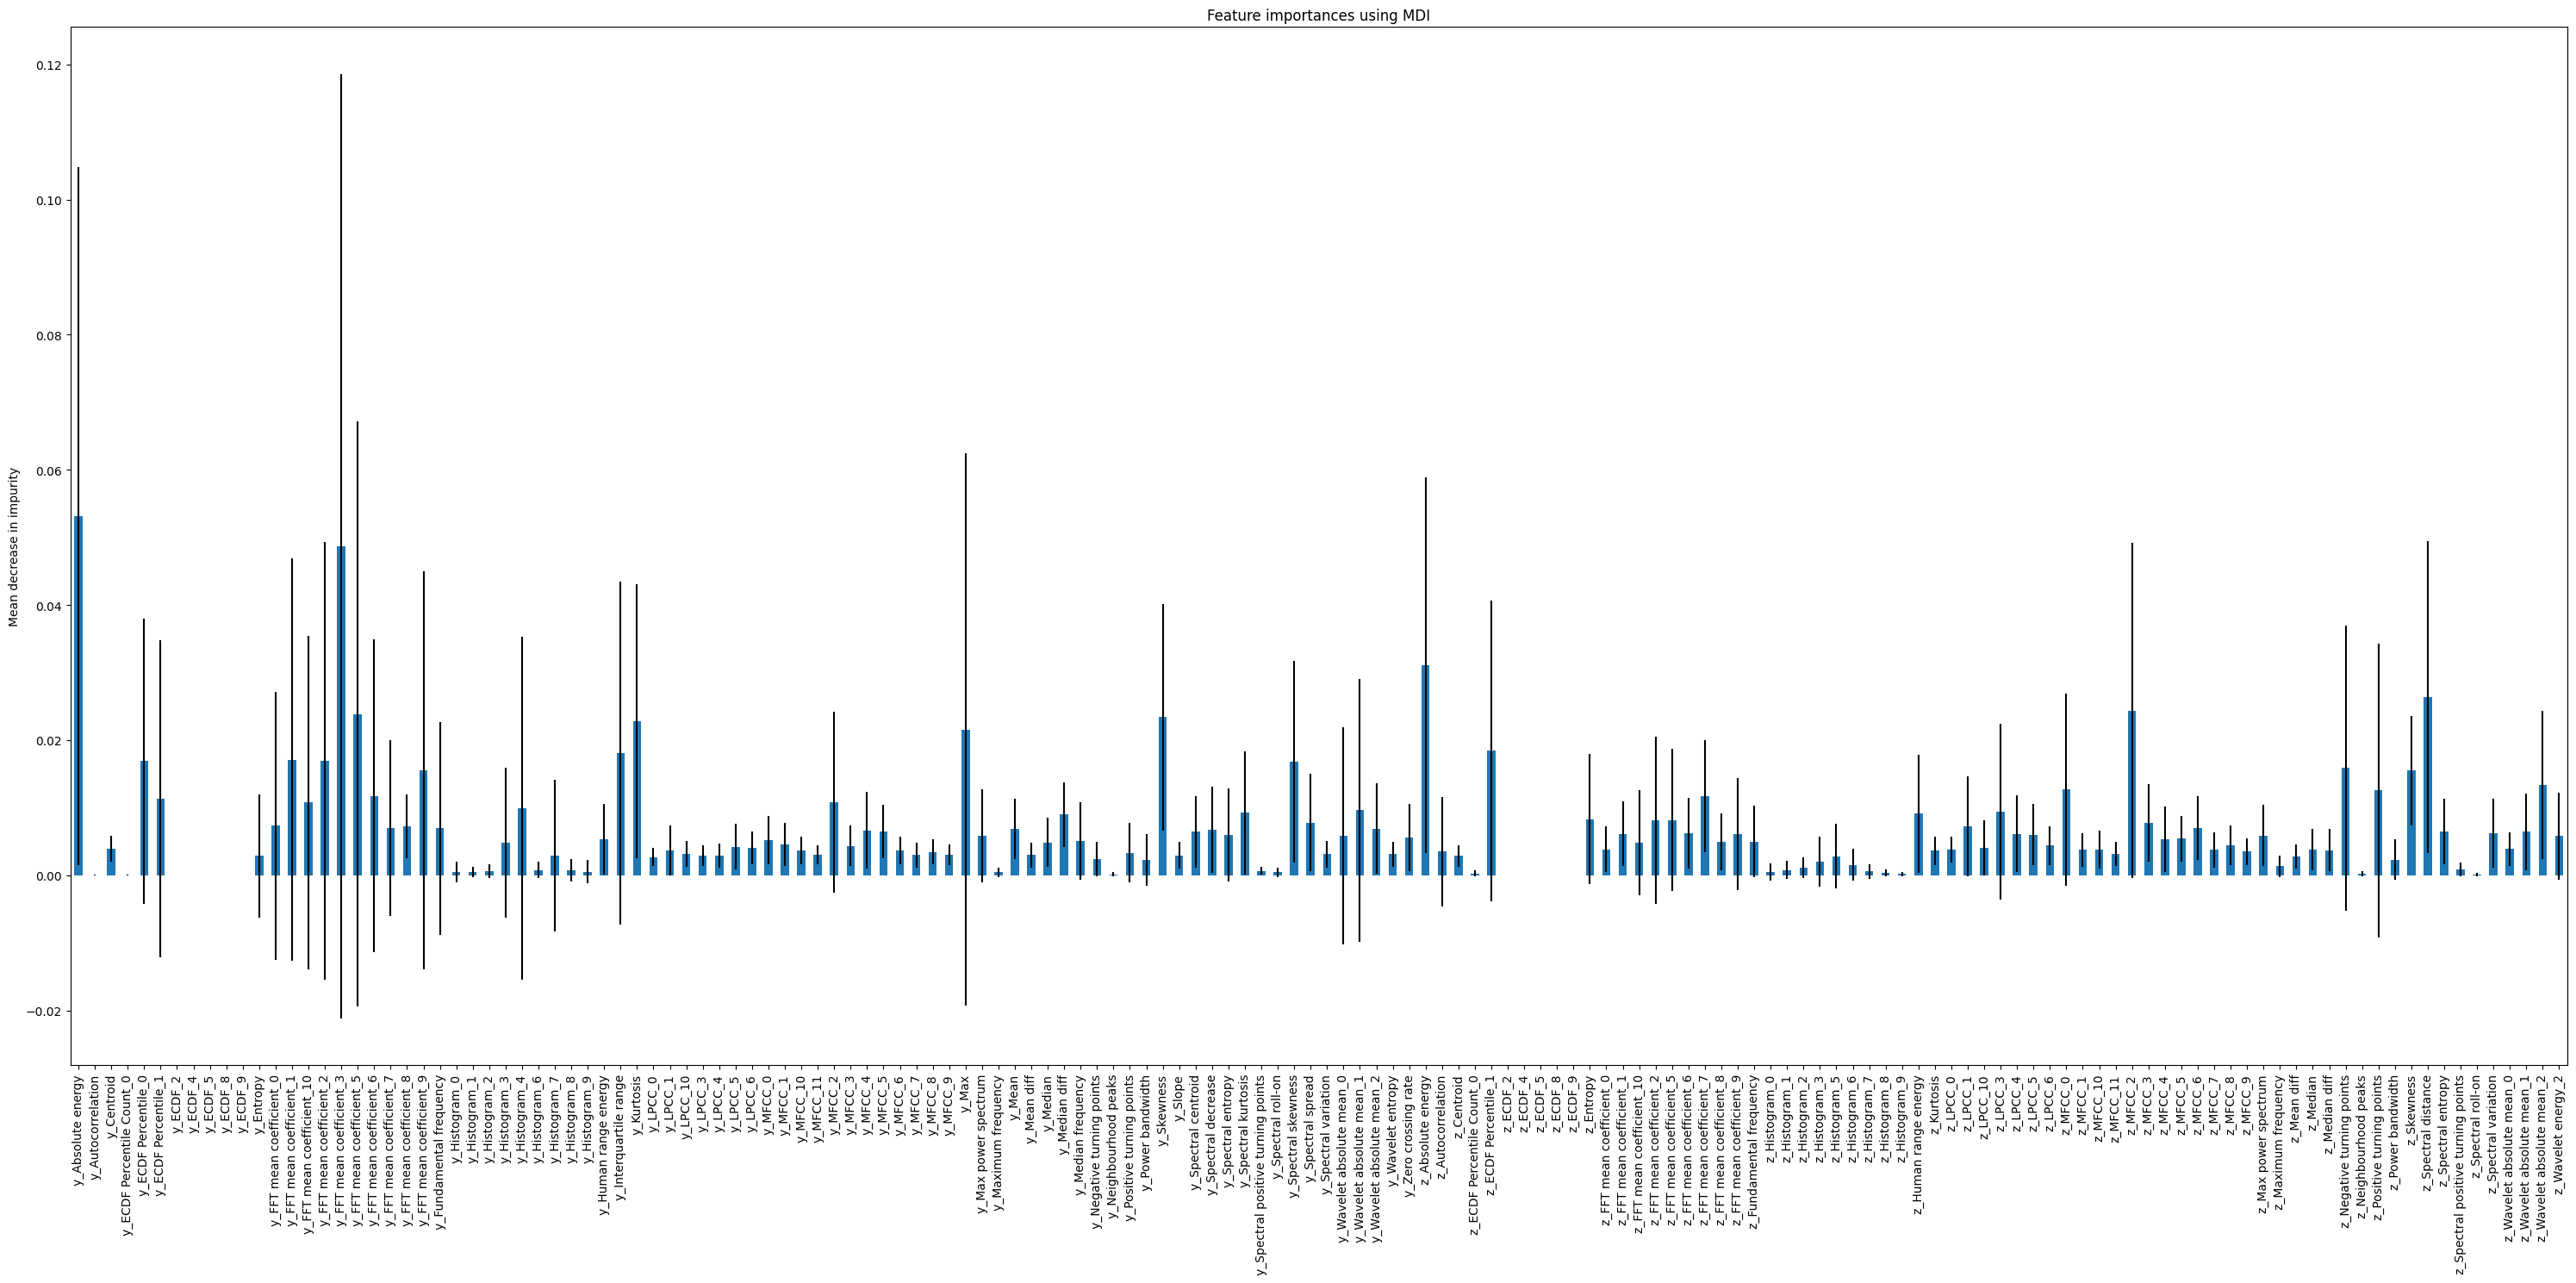

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(30,15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, test.iloc[0:,0:-1], test.wconfid, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 64.174 seconds


In [ ]:
result.importances_std

array([0.00102112, 0.        , 0.        , 0.        , 0.00025193,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00016493,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00057396, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00021

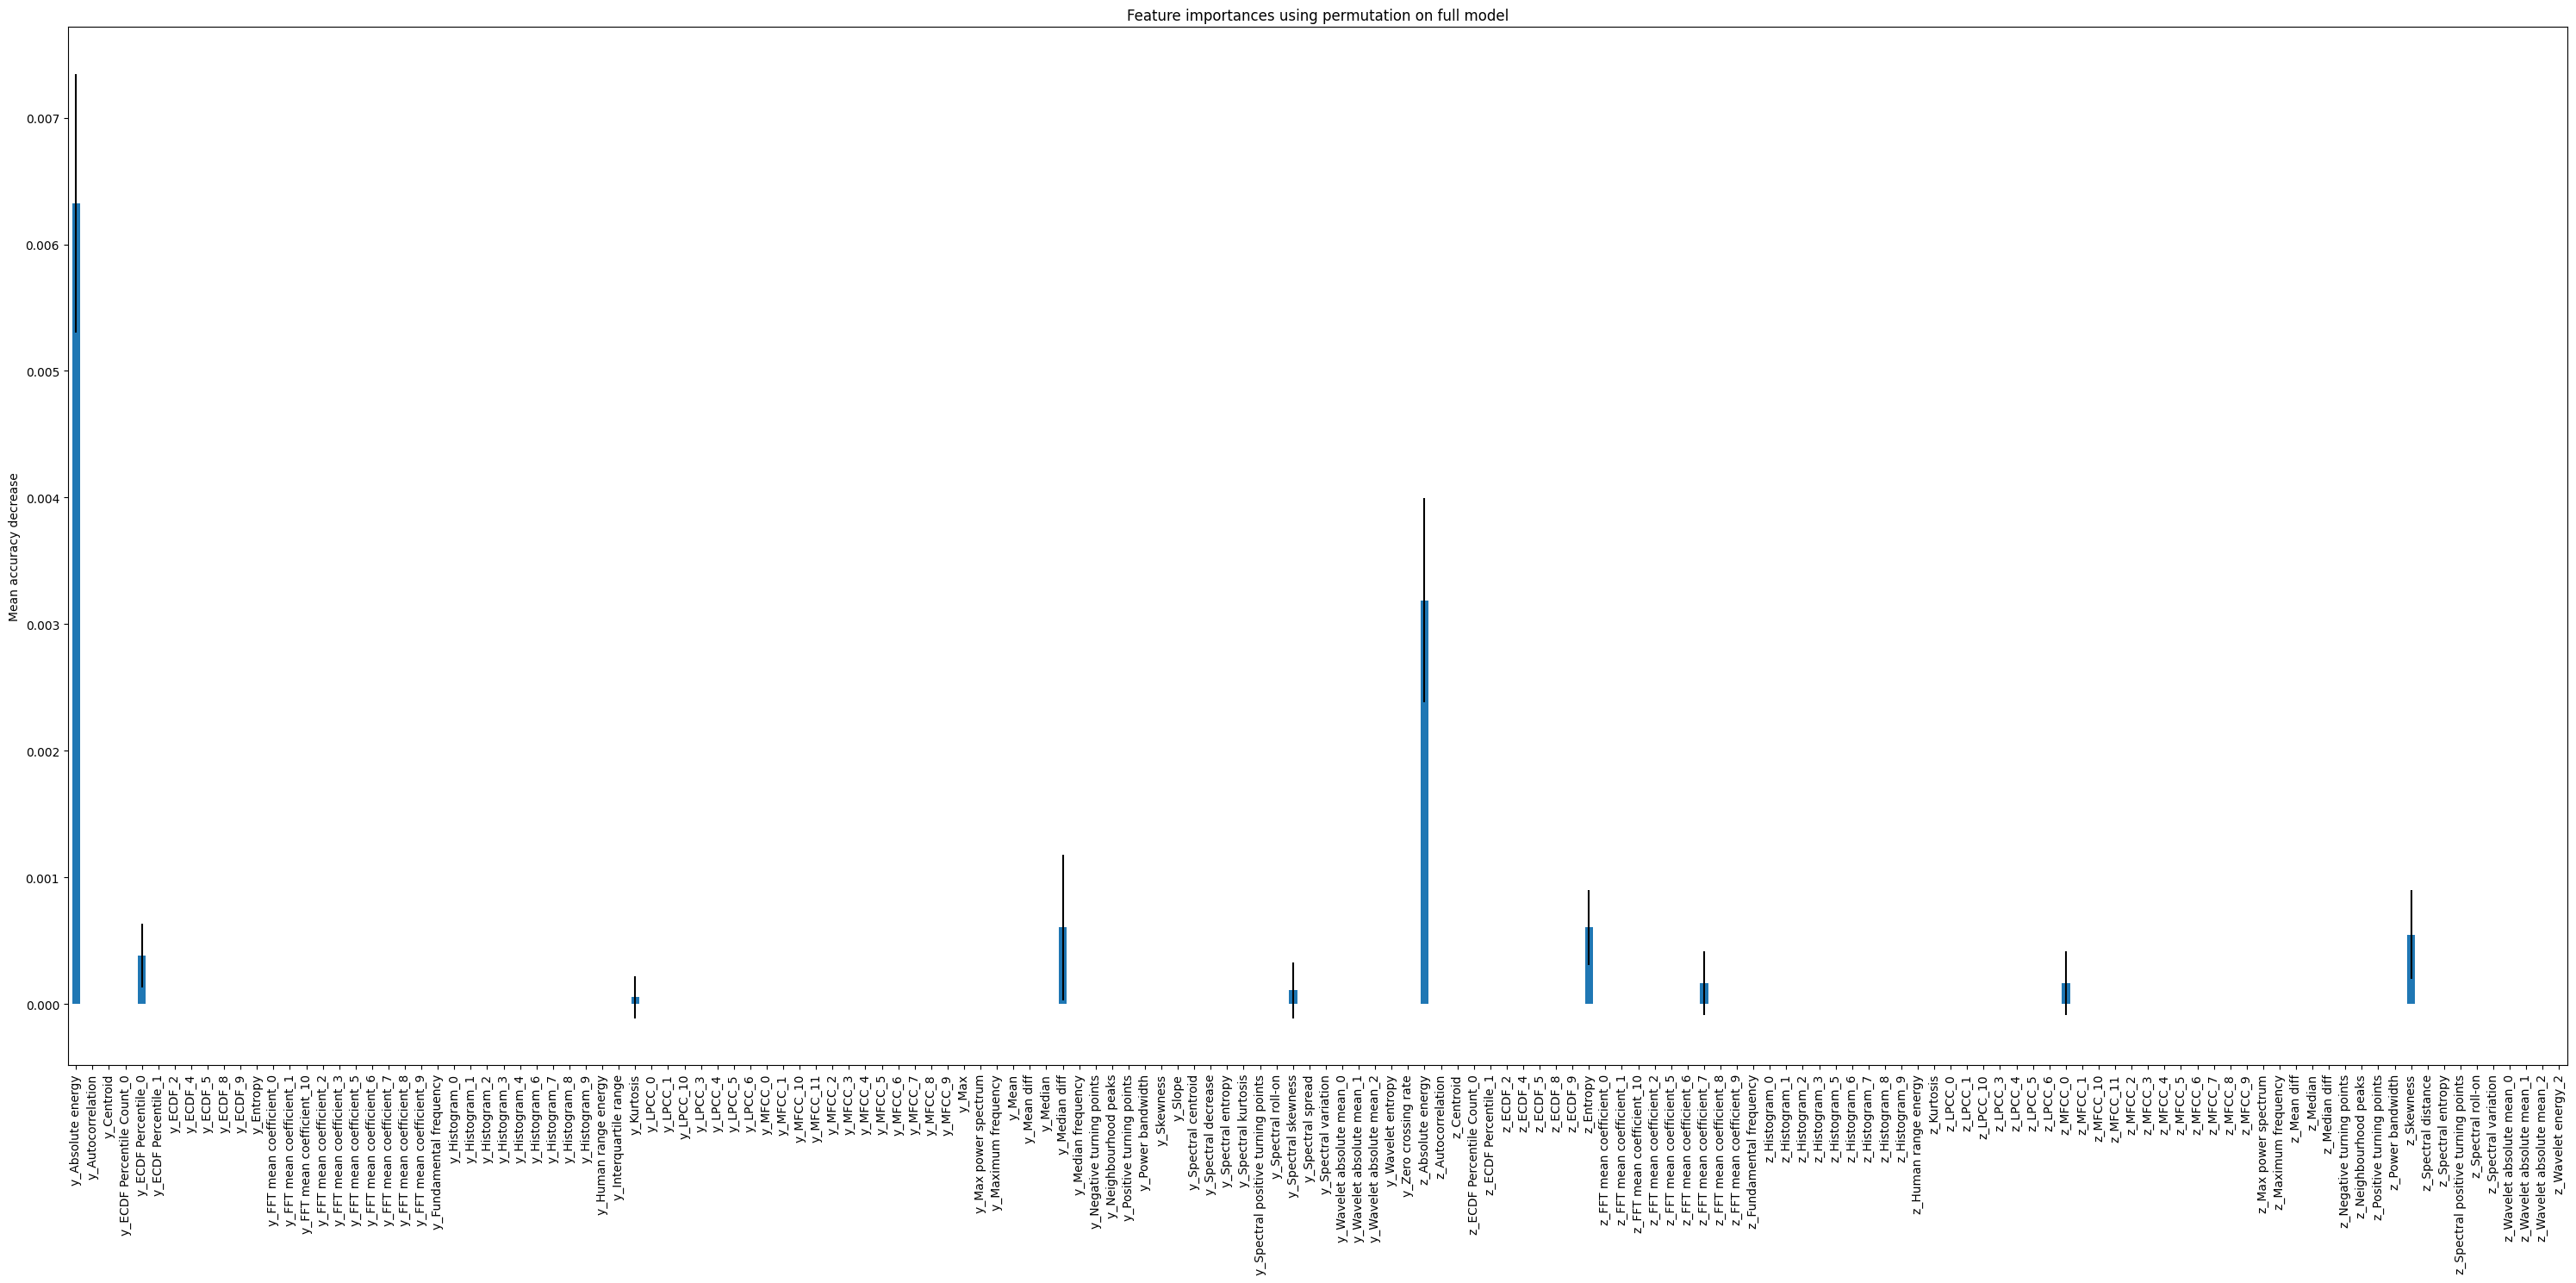

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
forest_importances.plot.bar(yerr=result.importances_std , ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
print('Feature :', features_v.Feature[0] )
fig = px.box(train, x="wconfid", y=features_v.Feature[0], points="all")
fig.show()
del fig

Feature : y_Absolute energy


In [ ]:
print('Feature :', features_v.Feature[1] )
fig = px.box(train, x="wconfid", y=features_v.Feature[1], points="all")
fig.show()
del fig

Feature : y_FFT mean coefficient_3


In [ ]:
print('Feature :', features_v.Feature[2] )
fig = px.box(train, x="wconfid", y=features_v.Feature[2], points="all")
fig.show()
del fig

Feature : y_Max


In [ ]:
import math

In [ ]:
# Infinite Feature Selection.

# Inputs:
#   x_train: matrix T (samples) by n (number of features).
#   y_train: column vector of labels (-1,1).
#   verbose: boolean variable.

# Outputs:
#   RANKED: vector of indicies of x_train from the best to the worst feature.
class InfFS:

    def __init__(self):
        h=0.1
        #print("HI")
    # Take in input the matrix e the label vector and return a matrix
    # of data for every different label.
    def takeLabel(self, x_train, y_train ):
        counter = x_train.shape[0] -1
        s_n = x_train
        s_p = x_train
        while(1):
            if( y_train[counter] == 1 ):
                s_n = np.delete(s_n, counter, axis = 0 )
            else:
                s_p = np.delete(s_p, counter, axis = 0 )
            counter = counter - 1
            if( counter == - 1 ):
                break
        return s_p, s_n

    # Function that help to define priors_corr.
    def defPriorsCorr(self,mu_s_n, mu_s_p):
        pcorr = mu_s_p
        counter = 0
        while( counter < len(pcorr) ):
            pcorr[counter] = (pcorr[counter] - mu_s_n[counter])*(pcorr[counter] - mu_s_n[counter])
            counter = counter + 1
        return pcorr

    # Function to subtract the min value of the matrix to all it's elements.
    def SubtractMin(self, corr_ij ):
        m = 10100
        for i in range(0,corr_ij.shape[0]): # Find the min.
            for j in range(0,corr_ij.shape[1]):
                if( corr_ij[i,j] < m ):
                    m = corr_ij[i,j]

        for i in range(0,corr_ij.shape[0]): # Subtract the min value.
            for j in range(0,corr_ij.shape[1]):
                corr_ij[i,j] = corr_ij[i,j] - m

        return corr_ij

    # Function to divide every element of the matrix to his maximum value.
    def DivideByMax(self,corr_ij):
        m = -1
        for i in range(0,corr_ij.shape[0]): # Find the max.s
            for j in range(0,corr_ij.shape[1]):
                if( corr_ij[i,j] > m ):
                    m = corr_ij[i,j]

        for i in range(0,corr_ij.shape[0]): # Divide by the maximum value.
            for j in range(0,corr_ij.shape[1]):
                corr_ij[i,j] = corr_ij[i,j] / m

        return corr_ij

    # Handmaded bsxfunction that take the max.
    def bsxfun(self, STD ):
        m = np.zeros( (STD.shape[0], STD.shape[0]) )
        for i in range( 0,STD.shape[0] ):
            for j in range( 0,STD.shape[0] ):
                if( STD[i] > STD[j] ):
                    m[i,j] = STD[i]
                else:
                    m[i,j] = STD[j]
        return m

    def infFS(self,x_train, y_train, alpha, supervision, verbose):
        # Start of point one.

        if supervision:
            s_p, s_n = self.takeLabel( x_train, y_train)
            mu_s_n = s_n.mean(0)
            mu_s_p = s_p.mean(0)
            priors_corr = self.defPriorsCorr(mu_s_n, mu_s_p)
            st = np.power(np.std(s_p, ddof = 1, axis = 0),2)
            st = st + np.power(np.std(s_n,ddof = 1, axis = 0),2)
            for i in range(0,len(st)):
                if st[i] == 0:
                    st[i] = 10000
            corr_ij = priors_corr
            for i in range(0,len(corr_ij)):
                corr_ij[i] = corr_ij[i] / st[i]
            corr_ij = np.dot( corr_ij.T[:,None], corr_ij[None,:])
            corr_ij = self.SubtractMin(corr_ij)
            corr_ij = self.DivideByMax(corr_ij)
        else:
            corr_ij, pval = stats.spearmanr(x_train)
            for i in range( 0,corr_ij.shape[0] ):
                for j in range( 0,corr_ij.shape[1] ):
                    if( math.isnan(corr_ij[i,j]) or corr_ij[i,j] < -1 or corr_ij[i,j] > 1 ):
                        corr_ij[i,j] = 0

        # After if.
        STD = np.std(x_train, ddof = 1, axis = 0)
        STDMatrix = self.bsxfun( STD )
        STDMatrix = self.SubtractMin(STDMatrix)
        sigma_ij = self.DivideByMax(STDMatrix)
        for i in range( 0,sigma_ij.shape[0] ):
            for j in range( 0,sigma_ij.shape[1] ):
                if( math.isnan(sigma_ij[i,j]) or sigma_ij[i,j] < -1 or sigma_ij[i,j] > 1 ):
                    sigma_ij[i,j] = 0

        # End of point one.

        # Start of the point two.
        if (verbose):
            print("2) Building the graph G = <V,E> \n");
        A =  ( alpha*corr_ij + (1-alpha)*sigma_ij );
        # End of the point two.

        # Start of the point three.
        if (verbose):
            print("3) Letting paths tend to infinite \n");

        I = np.identity( A.shape[0] )
        r = ( 0.9/ max( np.linalg.eigvals(A) ) ) # Setting the r values.
        y = I - ( r * A )
        S = np.linalg.inv( y ) - I
        # End of point three.

        # Start of point four.
        if (verbose):
            print("4) Estimating energy scores \n")

        WEIGHT = np.sum( S , axis=1 )
        # End of point four.

        # Start of point five.
        if(verbose):
            print("5) Features ranking")

        RANKED = np.argsort(WEIGHT)
        RANKED = np.flip(RANKED,0)
        RANKED = RANKED.T
        WEIGHT = WEIGHT.T
        return RANKED, WEIGHT
        # End of point five.


In [ ]:
INFFS_flag = True
if INFFS_flag:
    inf = InfFS()
    [RANKED, WEIGHT] = inf.infFS(train.iloc[0:,0:-1].values, train['wconfid'].values, alpha=0.1, supervision=1, verbose=1)

2) Building the graph G = <V,E> 

3) Letting paths tend to infinite 

4) Estimating energy scores 

5) Features ranking


In [ ]:
if PCA_flag:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=100)
    components = pca.fit_transform(train.iloc[0:,0:-2])
    total_var = pca.explained_variance_ratio_.sum() * 100
    fig = px.scatter_3d(components, x=0, y=1, z=2, color=train.wconfid,title=f'Total Explained Variance: {total_var:.2f}%',labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
    fig.show()
    del total_var, fig #components, pca

In [ ]:
y_test

6058    1
5441    3
4475    2
3689    2
4515    2
       ..
5601    1
6263    2
2651    1
6612    2
1553    2
Name: wconfid, Length: 1819, dtype: int64

In [ ]:
train

y_Absolute energy  y_Autocorrelation  y_Centroid  \
6496               4.56              -0.04        0.74   
5288               0.45              -0.04       -2.08   
598               -0.42              -0.04        1.16   
75                -0.42              -0.04       -0.03   
1339              -0.42              -0.04       -0.33   
...                 ...                ...         ...   
5191               0.48              -0.04        0.74   
5226               0.53              -0.04       -2.56   
5390              -0.13              -0.04       -1.51   
860               -0.42              -0.04       -1.11   
7270              -0.41              -0.04        0.90   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
6496                       0.04                -3.42                 3.21   
5288                       0.04                -0.71                 1.12   
598                        0.04                 0.55                -0.64   
75                         0.04                 0.48                -0.48   
1339                       0.04                 0.45                -0.71   
...                         ...                  ...                  ...   
5191                       0.04                -1.45                 2.18   
5226                       0.04                -0.43                 1.01   
5390                       0.04                -0.49                 0.38   
860                        0.04                 0.51                -0.65   
7270                       0.04                 0.35                -0.29   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral distance  \
6496  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -1.33   
5288  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.70   
598   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
75    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.01   
1339  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
...        ...       ...       ...       ...  ...                  ...   
5191  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 1.06   
5226  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -2.17   
5390  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.16   
860   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.08   
7270  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.48   

      z_Spectral entropy  z_Spectral positive turning points  \
6496                0.84                                0.54   
5288                0.82                                1.88   
598                -0.82                               -0.81   
75                  0.79                                0.54   
1339               -1.09                                0.54   
...                  ...                                 ...   
5191                0.40                               -0.81   
5226                1.22                                0.54   
5390               -0.44                                0.54   
860                 0.67                                0.54   
7270               -0.95                               -0.81   

      z_Spectral roll-on  z_Spectral variation  z_Wavelet absolute mean_0  \
6496               -0.29                 -1.62                       1.54   
5288                3.01                 -0.90                       1.09   
598                -0.29                  1.72                      -0.30   
75                 -0.29                  1.84                      -0.33   
1339               -0.29                  1.48                      -0.29   
...                  ...                   ...                        ...   
5191               -0.29                 -1.06                       1.87   
5226               -0.29                 -2.26                       1.62   
5390               -0.29         

if PCA_flag:
    columns = []
    for i in range(0,100):
        columns.append("PCA_" + str(i))

    components             = pd.DataFrame(components,columns = columns)
    columns
    
   #  components['pctid']  = train.pctid
    components['wconfid'] = train.wconfid
    train                  = components

    components             = pca.transform(test.iloc[0:,0:-2])
    components             = pd.DataFrame(components,columns = columns)
    # components['pctid']  = test.pctid
    components['wconfid'] = test.wconfid
    test                   = components

    display(train.shape)
    display(test.shape)

    #del columns, components, pca, PCA_flag

In [ ]:
train

y_Absolute energy  y_Autocorrelation  y_Centroid  \
6496               4.56              -0.04        0.74   
5288               0.45              -0.04       -2.08   
598               -0.42              -0.04        1.16   
75                -0.42              -0.04       -0.03   
1339              -0.42              -0.04       -0.33   
...                 ...                ...         ...   
5191               0.48              -0.04        0.74   
5226               0.53              -0.04       -2.56   
5390              -0.13              -0.04       -1.51   
860               -0.42              -0.04       -1.11   
7270              -0.41              -0.04        0.90   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
6496                       0.04                -3.42                 3.21   
5288                       0.04                -0.71                 1.12   
598                        0.04                 0.55                -0.64   
75                         0.04                 0.48                -0.48   
1339                       0.04                 0.45                -0.71   
...                         ...                  ...                  ...   
5191                       0.04                -1.45                 2.18   
5226                       0.04                -0.43                 1.01   
5390                       0.04                -0.49                 0.38   
860                        0.04                 0.51                -0.65   
7270                       0.04                 0.35                -0.29   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral distance  \
6496  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -1.33   
5288  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.70   
598   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
75    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.01   
1339  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
...        ...       ...       ...       ...  ...                  ...   
5191  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 1.06   
5226  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -2.17   
5390  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.16   
860   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.08   
7270  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.48   

      z_Spectral entropy  z_Spectral positive turning points  \
6496                0.84                                0.54   
5288                0.82                                1.88   
598                -0.82                               -0.81   
75                  0.79                                0.54   
1339               -1.09                                0.54   
...                  ...                                 ...   
5191                0.40                               -0.81   
5226                1.22                                0.54   
5390               -0.44                                0.54   
860                 0.67                                0.54   
7270               -0.95                               -0.81   

      z_Spectral roll-on  z_Spectral variation  z_Wavelet absolute mean_0  \
6496               -0.29                 -1.62                       1.54   
5288                3.01                 -0.90                       1.09   
598                -0.29                  1.72                      -0.30   
75                 -0.29                  1.84                      -0.33   
1339               -0.29                  1.48                      -0.29   
...                  ...                   ...                        ...   
5191               -0.29                 -1.06                       1.87   
5226               -0.29                 -2.26                       1.62   
5390               -0.29         

if PCA_flag:
    # create a list of column names for the components DataFrame
    columns = [f"PCA_{i}" for i in range(100)]

    # create a DataFrame from the principal components with the new column names
    components = pd.DataFrame(components, columns=columns)

    # add the 'activity' column from the original DataFrame to the components DataFrame
    components['wconfid'] = train['wconfid'].values
    train = components.dropna()

    # transform the test data using the PCA object and create a DataFrame with the new column names
    components = pca.transform(test.iloc[:, :-1])
    components = pd.DataFrame(components, columns=columns)

    # add the 'activity' column from the original DataFrame to the components DataFrame
    components['wconfid'] = test['wconfid'].values
    test = components.dropna()

    # display the shape of the train and test DataFrames
    display(train.shape)
    display(test.shape)

    # remove unnecessary variables from memory
    del columns, components, pca, PCA_flag

components

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# performs t-sne with different perplexity values and their repective plots..

def perform_tsne(X_data, y_data, perplexities, n_iter=100, img_name_prefix='t-sne'):
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(n_components=3, verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        # prepare the data for seaborn
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1],'z':X_reduced[:,2],'label':y_data})

        fig = px.scatter_3d(df, x='x', y='y', z='z',color='label', symbol='label',opacity=0.7, size_max=18)
        #draw the plot in appropriate place in the grid
        #sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['^','v','s','o', '1','2'])
#         plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        #img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        #print('saving this plot as image in present working directory...')
        #plt.savefig(img_name)
        #plt.show()
        # tight layout
        fig.show()
        print('Done')
    del X_reduced, df, fig

In [ ]:
null_data = test[test.isnull().any(axis=1)]
print(test.shape)
print(null_data.shape)
null_data = train[train.isnull().any(axis=1)]
print('\n')
print(train.shape)
print(null_data.shape)

(1819, 153)
(0, 153)


(5457, 153)
(0, 153)


In [ ]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [ ]:
train

y_Absolute energy  y_Autocorrelation  y_Centroid  \
6496               4.56              -0.04        0.74   
5288               0.45              -0.04       -2.08   
598               -0.42              -0.04        1.16   
75                -0.42              -0.04       -0.03   
1339              -0.42              -0.04       -0.33   
...                 ...                ...         ...   
5191               0.48              -0.04        0.74   
5226               0.53              -0.04       -2.56   
5390              -0.13              -0.04       -1.51   
860               -0.42              -0.04       -1.11   
7270              -0.41              -0.04        0.90   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
6496                       0.04                -3.42                 3.21   
5288                       0.04                -0.71                 1.12   
598                        0.04                 0.55                -0.64   
75                         0.04                 0.48                -0.48   
1339                       0.04                 0.45                -0.71   
...                         ...                  ...                  ...   
5191                       0.04                -1.45                 2.18   
5226                       0.04                -0.43                 1.01   
5390                       0.04                -0.49                 0.38   
860                        0.04                 0.51                -0.65   
7270                       0.04                 0.35                -0.29   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral distance  \
6496  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -1.33   
5288  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.70   
598   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
75    2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.01   
1339  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   
...        ...       ...       ...       ...  ...                  ...   
5191  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 1.06   
5226  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -2.17   
5390  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.16   
860   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -0.08   
7270  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.48   

      z_Spectral entropy  z_Spectral positive turning points  \
6496                0.84                                0.54   
5288                0.82                                1.88   
598                -0.82                               -0.81   
75                  0.79                                0.54   
1339               -1.09                                0.54   
...                  ...                                 ...   
5191                0.40                               -0.81   
5226                1.22                                0.54   
5390               -0.44                                0.54   
860                 0.67                                0.54   
7270               -0.95                               -0.81   

      z_Spectral roll-on  z_Spectral variation  z_Wavelet absolute mean_0  \
6496               -0.29                 -1.62                       1.54   
5288                3.01                 -0.90                       1.09   
598                -0.29                  1.72                      -0.30   
75                 -0.29                  1.84                      -0.33   
1339               -0.29                  1.48                      -0.29   
...                  ...                   ...                        ...   
5191               -0.29                 -1.06                       1.87   
5226               -0.29                 -2.26                       1.62   
5390               -0.29         

In [ ]:
# y_pre_tsne

In [ ]:
X_pre_tsne = train.drop(['wconfid'], axis=1)
y_pre_tsne = train['wconfid']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[30])
# del X_pre_tsne, y_pre_tsne


performing tsne with perplexity 30 and with 100 iterations at max
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5457 samples in 0.005s...
[t-SNE] Computed neighbors for 5457 samples in 0.799s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5457
[t-SNE] Computed conditional probabilities for sample 2000 / 5457
[t-SNE] Computed conditional probabilities for sample 3000 / 5457
[t-SNE] Computed conditional probabilities for sample 4000 / 5457
[t-SNE] Computed conditional probabilities for sample 5000 / 5457
[t-SNE] Computed conditional probabilities for sample 5457 / 5457
[t-SNE] Mean sigma: 2.731376
[t-SNE] Computed conditional probabilities in 0.235s
[t-SNE] Iteration 50: error = 79.5048370, gradient norm = 0.0149504 (50 iterations in 7.813s)
[t-SNE] Iteration 100: error = 76.7978058, gradient norm = 0.0028039 (50 iterations in 4.539s)
[t-SNE] Iteration 150: error = 76.5349731, gradient norm = 0.0017262 (50 iterations in 5.823s)
[t-SNE] Iteration 200: error =

Done


In [ ]:
y_train = train.wconfid
X_train = train.drop(['wconfid'], axis=1)
y_test = test.wconfid
X_test = test.drop(['wconfid'], axis=1)
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)

Training data size :  (5457, 152)
Test data size :  (1819, 152)


In [ ]:
train.head(3)

y_Absolute energy  y_Autocorrelation  y_Centroid  \
6496               4.56              -0.04        0.74   
5288               0.45              -0.04       -2.08   
598               -0.42              -0.04        1.16   

      y_ECDF Percentile Count_0  y_ECDF Percentile_0  y_ECDF Percentile_1  \
6496                       0.04                -3.42                 3.21   
5288                       0.04                -0.71                 1.12   
598                        0.04                 0.55                -0.64   

      y_ECDF_2  y_ECDF_4  y_ECDF_5  y_ECDF_8  ...  z_Spectral distance  \
6496  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                -1.33   
5288  2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.70   
598   2.78e-17 -2.78e-17  5.55e-17 -5.55e-17  ...                 0.02   

      z_Spectral entropy  z_Spectral positive turning points  \
6496                0.84                                0.54   
5288                0.82                                1.88   
598                -0.82                               -0.81   

      z_Spectral roll-on  z_Spectral variation  z_Wavelet absolute mean_0  \
6496               -0.29                 -1.62                       1.54   
5288                3.01                 -0.90                       1.09   
598                -0.29                  1.72                      -0.30   

      z_Wavelet absolute mean_1  z_Wavelet absolute mean_2  \
6496                       0.13                       0.98   
5288                       1.38                      -0.11   
598                       -0.22                      -0.19   

      z_Wavelet energy_2  wconfid  
6496                3.21        1  
5288                1.10        2  
598                -0.53        2  

[3 rows x 153 columns]

In [ ]:
labels=['1','2', '3']

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    del cm, tick_marks, i, j, fmt

In [ ]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):


    # to store results at various phases
    results = dict()

    # time at which model starts training
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))


    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred


    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))


    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))

    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()

    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)

    # add the trained  model to the results
    results['model'] = model

    return results



In [ ]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))




In [ ]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.impute import SimpleImputer

# create an imputer object with the mean strategy
imputer = SimpleImputer(strategy='mean')

# fit the imputer on the training data and transform both the training and test data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [ ]:
np.isnan(X_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:02:06.295323


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.002556


---------------------
|      Accuracy      |
---------------------

    0.7982407916437603


--------------------
| Confusion Matrix |
--------------------

 [[500  77  57]
 [ 92 400 101]
 [ 18  22 552]]


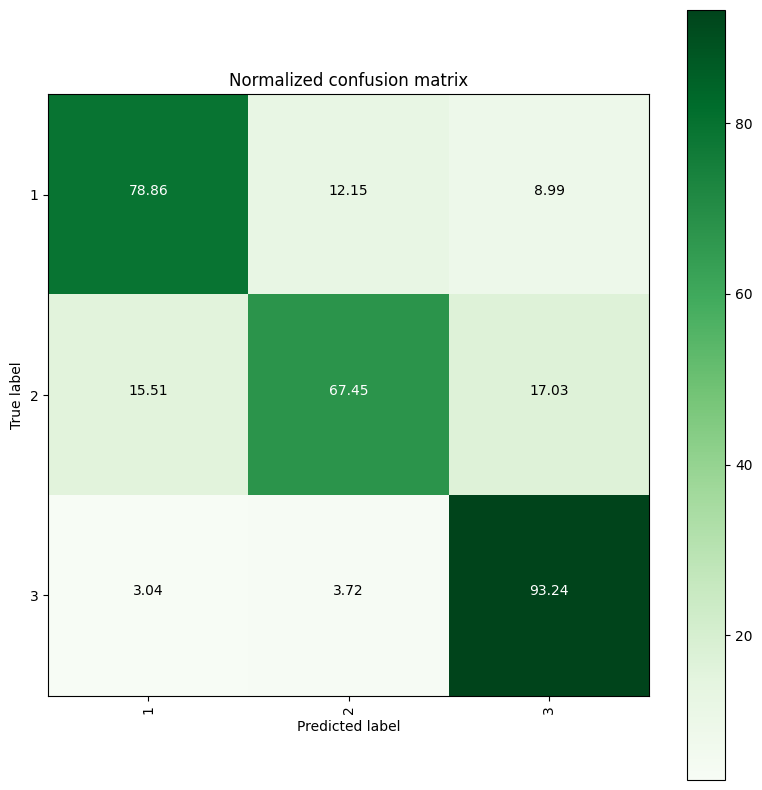

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           1       0.82      0.79      0.80       634
           2       0.80      0.67      0.73       593
           3       0.78      0.93      0.85       592

    accuracy                           0.80      1819
   macro avg       0.80      0.80      0.79      1819
weighted avg       0.80      0.80      0.79      1819



In [ ]:
# start Grid search
# 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
parameters = {'solver':['liblinear'], 'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

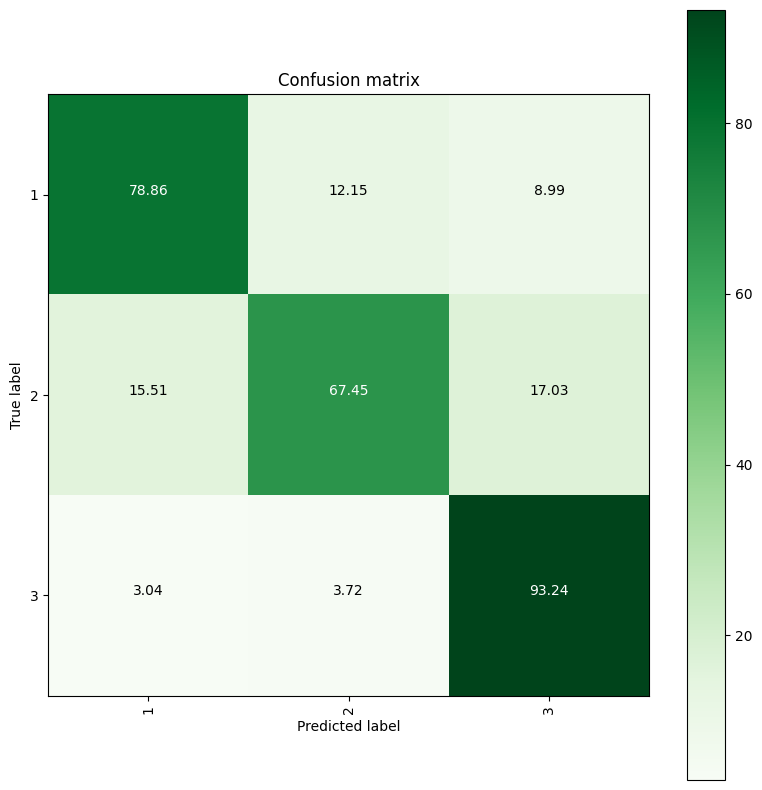

In [ ]:
plt.figure(figsize=(8,8))
plt.grid(False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [ ]:
# observe the attributes of the model
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=30, penalty='l1', solver='liblinear')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 30, 'penalty': 'l1', 'solver': 'liblinear'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.7975077881619939



In [ ]:
from sklearn.svm import LinearSVC

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Done 
 

training_time(HH:MM:SS.ms) - 0:01:45.823374


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.003168


---------------------
|      Accuracy      |
---------------------

    0.7960417811984607


--------------------
| Confusion Matrix |
--------------------

 [[501  78  55]
 [ 94 391 108]
 [ 21  15 556]]


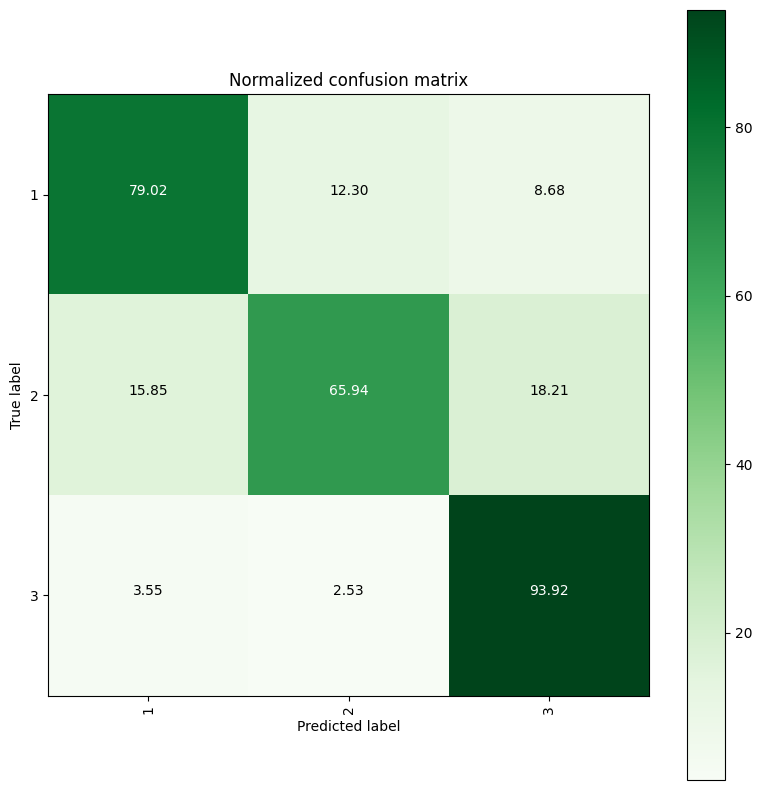

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           1       0.81      0.79      0.80       634
           2       0.81      0.66      0.73       593
           3       0.77      0.94      0.85       592

    accuracy                           0.80      1819
   macro avg       0.80      0.80      0.79      1819
weighted avg       0.80      0.80      0.79      1819



In [ ]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [ ]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=2, tol=5e-05)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 2}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.7954890663873249



training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:05.634605


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.002235


---------------------
|      Accuracy      |
---------------------

    0.8048378229796591


--------------------
| Confusion Matrix |
--------------------

 [[483 117  34]
 [ 50 483  60]
 [ 24  70 498]]


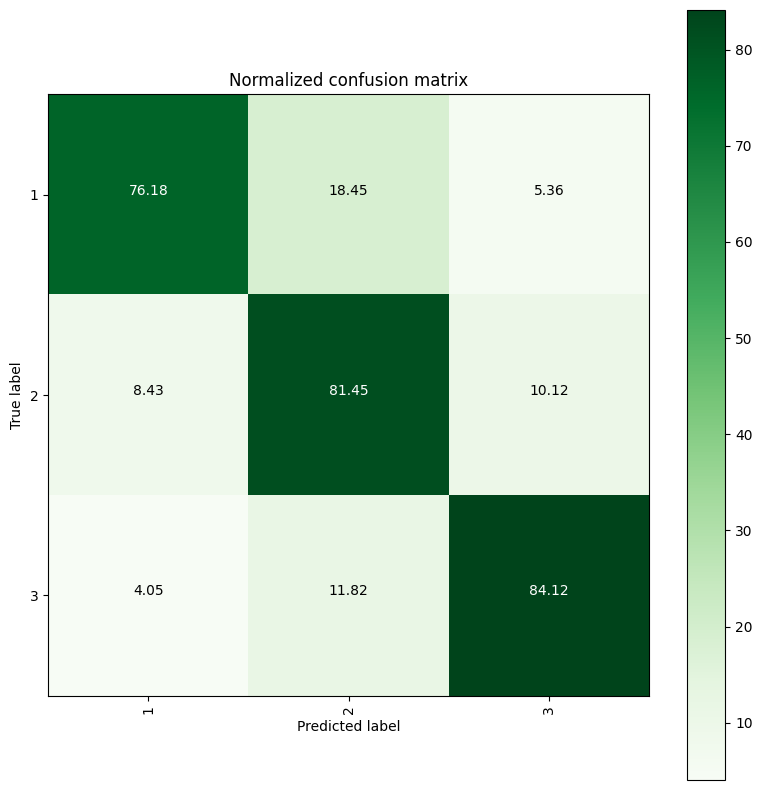

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           1       0.87      0.76      0.81       634
           2       0.72      0.81      0.76       593
           3       0.84      0.84      0.84       592

    accuracy                           0.80      1819
   macro avg       0.81      0.81      0.81      1819
weighted avg       0.81      0.80      0.81      1819

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(max_depth=7)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 7}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.8

In [ ]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:04.765661


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.002306


---------------------
|      Accuracy      |
---------------------

    0.8070368334249588


--------------------
| Confusion Matrix |
--------------------

 [[486 116  32]
 [ 51 484  58]
 [ 24  70 498]]


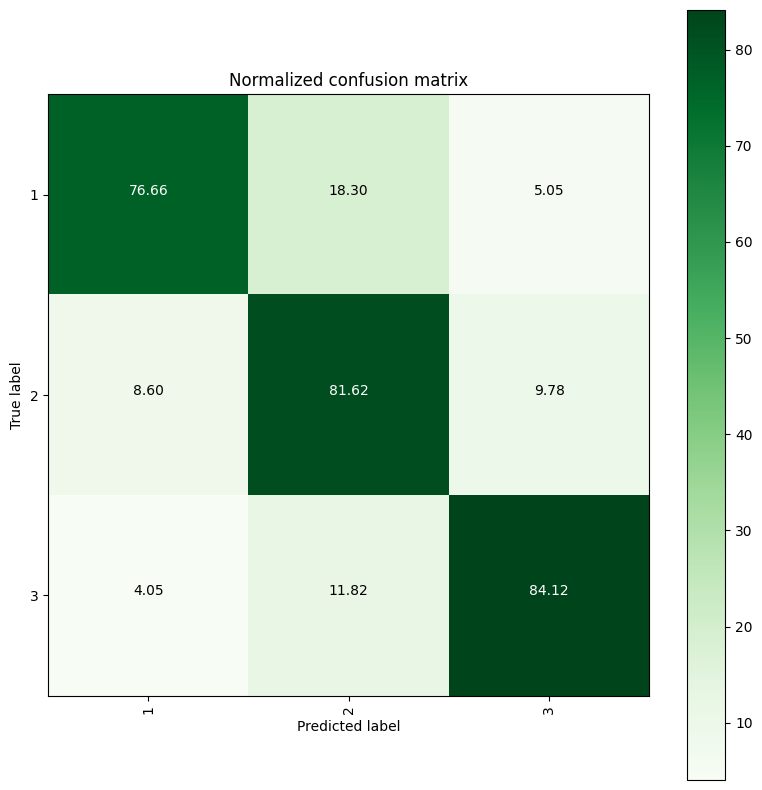

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           1       0.87      0.77      0.81       634
           2       0.72      0.82      0.77       593
           3       0.85      0.84      0.84       592

    accuracy                           0.81      1819
   macro avg       0.81      0.81      0.81      1819
weighted avg       0.81      0.81      0.81      1819

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(max_depth=7)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 7}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.8

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth':np.arange(3,10,2)}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
rf_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rf_grid_results['model'])


In [ ]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,100-(log_reg_grid_results['accuracy'] * 100)))
print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,100-(lr_svc_grid_results['accuracy'] * 100)))
print('DecisionTree        : {:.04}%       {:.04}% '.format(dt_grid_results['accuracy'] * 100,100-(dt_grid_results['accuracy'] * 100)))
print('RandomForest        : {:.04}%       {:.04}% '.format(rf_grid_results['accuracy'] * 100,100-(rf_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 79.82%       20.18%
Linear SVC          : 79.6%       20.4% 
DecisionTree        : 80.48%       19.52% 
RandomForest        : 80.7%       19.3% 


In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Assuming you have already trained a binary classification model and made predictions
# y_true = [0, 1, 1, 0, 1, 0, 0, 1, 0, 1] # True labels (0 or 1) for the test data
# y_scores = [0.2, 0.8, 0.7, 0.4, 0.9, 0.1, 0.3, 0.6, 0.25, 0.95] # Predicted probabilities for the test data

# # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
# fpr, tpr, thresholds = roc_curve(y_train, y_test)

# # Calculate the area under the curve (AUC)
# auc = roc_auc_score(y_train, y_test)

# # Plot the ROC curve
# plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.show()

In [ ]:
y_train

6496    1
5288    2
598     2
75      1
1339    1
       ..
5191    1
5226    1
5390    2
860     1
7270    3
Name: wconfid, Length: 5457, dtype: int64